In [1]:
import sys
import os
sys.path.append(os.path.abspath("..")) 
import importlib

In [2]:
# %pip install matplotlib yfinance pandas-datareader

In [3]:
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
import matplotlib.cm as cm

import math
from IPython.display import display
import yfinance as yf

import matplotlib.pyplot as plt
from tqdm import tqdm 
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
import src
try: 
    for module in [src.models, src.data, src.utils, src.train, src.verification, src.visualisation, src.evaluation]:
        if module:
            importlib.reload(module)
    print("Reloading")
except:
    print("Not reloading")

from src.models import *
from src.data import *
from src.utils import *
from src.train import *
from src.verification import *
from src.visualisation import *
from src.evaluation import *

Not reloading


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
trainval_start = "2006-04-02"
trainval_end = "2019-12-31"
test_start = "2020-01-01"
# test_start = "2020-01-01"
test_end = "2022-12-31"

# trainval_end = (pd.to_datetime(trainval_end) - pd.tseries.offsets.BDay(53)).strftime("%Y-%m-%d")
# test_start = (pd.to_datetime(test_start) - pd.tseries.offsets.BDay(53)).strftime("%Y-%m-%d")

In [7]:
returns_df, close_df =  get_asset_dataset(trainval_start, test_end)

asset_names = list(returns_df.columns)
n_assets = len(asset_names)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  3 of 3 completed


In [8]:
trainval_mask = (close_df.index >= trainval_start) & (close_df.index <= trainval_end)
trainval_indices = close_df[trainval_mask].index

val_size = int(0.2 * len(trainval_indices))
train_indices = trainval_indices[:-val_size]
val_indices = trainval_indices[-val_size:]

test_mask = (close_df.index >= test_start) & (close_df.index <= test_end)
test_indices = close_df[test_mask].index

/tmp/ipykernel_3239423/1400509521.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10')


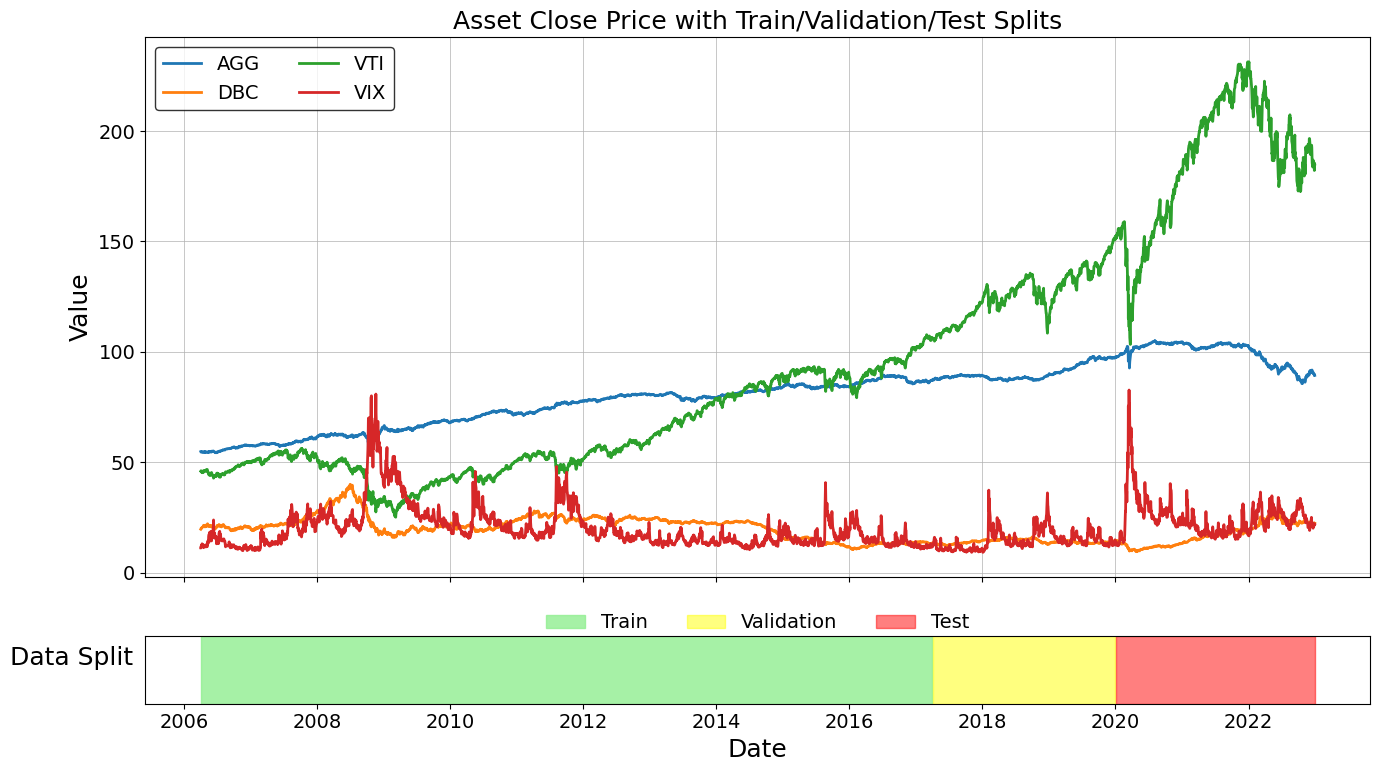

In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
colors = cm.get_cmap('tab10')

# -----------------------------------------------------------------------------
# ASSUMPTIONS:
#  - `close_df` is a pandas.DataFrame with a datetime-like index,
#    and columns corresponding to each ticker/asset.
#  - `train_indices`, `val_indices`, `test_indices` are each lists/arrays of
#    datetime-like index labels (e.g. pandas Timestamp) in `close_df.index` that define the three splits.
#  - `colors` is a colormap or function such that `colors(i)` returns a distinct color for asset i.
# -----------------------------------------------------------------------------

# Increase default font sizes for PDF readability
plt.rcParams.update({
    "font.size": 16,            # base font size for labels, ticks, legend text
    "axes.titlesize": 18,       # title font size
    "axes.labelsize": 18,       # x/y axis label font size
    "xtick.labelsize": 14,      # x-axis tick label font size
    "ytick.labelsize": 14,      # y-axis tick label font size
    "legend.fontsize": 14,      # legend text font size
})

# Compute start and end dates for each split
train_start = min(train_indices)
train_end = max(train_indices)
val_start = min(val_indices)
val_end = max(val_indices)
test_start = min(test_indices)
test_end = max(test_indices)

# Create subplots: main plot on top, timeline on bottom
fig, (ax_main, ax_timeline) = plt.subplots(
    2, 1, sharex=True,
    gridspec_kw={'height_ratios': [8, 1]},
    figsize=(14, 8)
)

# 1) Plot each asset on the main axes
for i, ticker in enumerate(close_df.columns):
    asset_color = colors(i)
    # Plot Train, Validation, Test segments: only label Train for legend
    for idx, label in zip([train_indices, val_indices, test_indices], ["Train", "Val", "Test"]):
        plot_label = ticker if label == "Train" else "_nolegend_"
        ax_main.plot(
            close_df.loc[idx, ticker],
            color=asset_color,
            linewidth=2,
            label=plot_label
        )

ax_main.set_title("Asset Close Price with Train/Validation/Test Splits")
ax_main.set_ylabel("Value")
ax_main.grid(True, linewidth=0.5)
ax_main.legend(loc="upper left", fontsize="14", ncol=2, frameon=True, edgecolor="black")

# 2) Create the timeline: colored boxes for each split
#    We'll use ax_timeline.axvspan to draw colored regions at y=[0, 1] for each split.
ax_timeline.axvspan(train_start, train_end, color="lightgreen", alpha=0.8, label="Train")
ax_timeline.axvspan(val_start, val_end, color="yellow", alpha=0.5, label="Validation")
ax_timeline.axvspan(test_start, test_end, color="red", alpha=0.5, label="Test")

# Remove y-axis details for timeline
ax_timeline.set_yticks([])
ax_timeline.set_ylabel("Data Split", rotation=0, labelpad=40)
ax_timeline.yaxis.set_label_coords(-0.06, 0.5)
ax_timeline.grid(False)

# Format x-axis as dates
ax_timeline.xaxis.set_major_locator(mdates.AutoDateLocator())
ax_timeline.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))

# Add legend for the timeline in the timeline subplot
ax_timeline.legend(loc="center", ncol=3, frameon=False, bbox_to_anchor=(0.5, 1.2))

plt.xlabel("Date")
plt.tight_layout(h_pad=1.0)
plt.show()


In [10]:
lookback = 50   
horizon = 5     
allocation_step = 5

X_train, y_train, train_idx = create_windows(returns_df, train_indices, lookback, horizon)
X_val, y_val, val_idx = create_windows(returns_df, val_indices, lookback, horizon)
X_test, y_test, test_idx = create_windows(returns_df, test_indices, lookback, horizon)

batch_size = 32

X_train_tensor_ = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor_ = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

X_test_tensor_ = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

num_samples, seq_len, num_assets = X_train_tensor_.shape
flattened = X_train_tensor_.reshape(-1, num_assets)

mean = flattened.mean(dim=0)  # shape (num_assets,)
std = flattened.std(dim=0)    # shape (num_assets,)

std[std == 0] = 1.0

X_train_tensor = standardize(X_train_tensor_, mean, std)
X_val_tensor = standardize(X_val_tensor_, mean, std)
X_test_tensor = standardize(X_test_tensor_, mean, std)

saved_mean = mean
saved_std = std

In [11]:
# asset_std = X_train_tensor.reshape(-1, X_train_tensor.shape[-1]).std(dim=0)
sigma = 0.025
jitter = Jitter(sigma=sigma)

train_dataset = AugmentedTimeSeriesDataset(X_train_tensor, y_train_tensor, transform=jitter)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Experiments

In [12]:
def run_experiment(model, data, experiment={}):
    params = experiment.get("params", {})
    rebalance_freq = params.get("rebalance_freq", 5)
    x, y = data
    model.eval()
    n = y.shape[0]

    x = x.to(device)

    print(rebalance_freq)

    portfolio_values,weights,holdings = get_portfolio_value(model, (x,y), rebalance_freq)

    weights = torch.tensor(weights).squeeze(1)
    holdings = torch.tensor(holdings).squeeze(1)


    # returns = portfolio_values.
    cum_returns = portfolio_values - 1

    returns = (portfolio_values[1:] - portfolio_values[:-1]) / portfolio_values[:-1]

    # Daily metrics
    mean_return = np.mean(returns)
    std_return = np.std(returns)
    sharpe = sharpe_ratio(returns)

    metrics = {
        "expected_return": cum_returns[-1].item(),
        "sharpe_ratio": sharpe,
        "max_drawdown": max_drawdown(portfolio_values),
        "mean_entropy": mean_entropy(weights),
        "mean_return": mean_return,
        "std_return": std_return,
    }

    raw = {
        "weights": weights,
        "returns": returns,
        "cum_returns": cum_returns,
        "holdings": holdings,
    }

    return {"metrics": metrics, "raw": raw}




In [13]:
class CustomSoftmax(nn.Module):
    def __init__(self, dim: int = -1, eps: float = 1e-5):
        super().__init__()
        self.dim = dim
        self.eps = eps

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        e = torch.exp(x)
        return e / (e.sum(dim=self.dim, keepdim=True) + self.eps)
class CNNAllocatorCausal3(nn.Module):
    def __init__(self, input_channels=4, time_steps=50, hidden_size=100):
        super().__init__()
        self.time_steps = time_steps

        # ZeroPad2d pads last two dims. Here (pad_left, pad_right, pad_top, pad_bottom).
        # We want to pad 2 zeros on the "time" axis (height) at the top.
        self.pad1 = nn.ZeroPad2d((0, 0, 2, 0))
        self.conv1 = nn.Conv2d(
            in_channels=input_channels,
            out_channels=32,
            kernel_size=(3, 1),
            dilation=(1, 1),
            padding=(0, 0)   # no internal padding; we handle it via pad1
        )

        self.pad2 = nn.ZeroPad2d((0, 0, 2, 0))
        self.conv2 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=(3, 1),
            dilation=(1, 1),
            padding=(0, 0)   # no internal padding; we handle it via pad2
        )

        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * time_steps, hidden_size)
        self.fc2 = nn.Linear(hidden_size, input_channels)
        self.softmax = CustomSoftmax(dim=-1)

    def forward(self, x):
        # x: (batch_size, time_steps, input_channels)
        x = x.transpose(1, 2)      # → (B, C, T)
        x = x.unsqueeze(-1)        # → (B, C, T, 1)

        # First causal conv:
        x = self.pad1(x)           # → (B, C, T+2, 1)  (padding=2 on top)
        x = self.relu(self.conv1(x))  # → (B, 32, T, 1)

        # Second causal conv:
        x = self.pad2(x)           # → (B, 32, T+2, 1)
        x = self.relu(self.conv2(x))  # → (B, 64, T, 1)

        # Flatten and FC
        x = self.flatten(x)        # → (B, 64 * T)
        x = self.relu(self.fc1(x)) # → (B, hidden_size)
        x = self.fc2(x)            # → (B, input_channels)
        return self.softmax(x)

In [14]:
def default_linestyle_map(params):
    return "-"

def display_train_results(experiments):
    plt.figure(figsize=(10, 6))
    colors = cm.get_cmap('tab10')

    for idx, (label, experiment) in enumerate(experiments.items()):
        if "train_results" not in experiment:
            continue
        # label = label_from_params(experiment["params"], experiments)
        
        data = experiment["train_results"]
        epochs = list(range(1, len(data["train_losses"]) + 1))
        color = colors(idx % 10) 

        plt.plot(epochs, data["train_losses"], label=f"{label} - Train", linestyle='-', color=color)
        plt.plot(epochs, data["val_losses"], label=f"{label} - Val", linestyle='--', color=color)

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Losses")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def display_experiment_results(experiments, dataset_key, dataset_idx, linestyle_map=default_linestyle_map, label_from_params=None, additional_detail=False):
    metrics_df  = pd.DataFrame({k: v['results'][dataset_key]["metrics"] for k, v in experiments.items()}).T
    metrics_df = metrics_df.applymap(lambda x: f"{x:.3g}" if isinstance(x, float) else x)
    display(metrics_df)

    plt.figure(figsize=(10, 6))
    for label, params, cr in [(k, v["params"], v['results'][dataset_key]["raw"]["cum_returns"]) for k, v in experiments.items()]:

        print(cr.shape)
        plt.plot(dataset_idx[::5], cr[::5], label=label, linestyle=linestyle_map(params))

    plt.title(f"Cumulative Returns of Different Models ({dataset_key.title()})")
    plt.xlabel("Time Step")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    ncols = 2
    nrows = math.ceil(len(experiments.items()) / ncols)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10 * ncols, 5 * nrows))
    axes = axes.flatten()

    # Loop through and plot
    for i, (label, weights) in enumerate([(k, v['results'][dataset_key]["raw"]["weights"]) for k, v in experiments.items()]):
        ax = axes[i]
        ax.stackplot(dataset_idx, weights.T.detach().numpy(), labels=asset_names)
        ax.set_title(f'Stacked Area Plot of Asset Allocations ({label})')
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Proportion')
        ax.legend(loc='upper left')
        ax.grid(True)

    # Hide any unused axes
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

    if additional_detail:

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10 * ncols, 5 * nrows))
        axes = axes.flatten()

        # Loop through and plot
        for i, (label, holding) in enumerate([(k, v['results'][dataset_key]["raw"]["holdings"]) for k, v in experiments.items()]):
            ax = axes[i]
            ax.plot(dataset_idx, holding.detach().numpy(), label=asset_names)
            ax.set_title(f'Stacked Area Plot of Asset Allocations ({label})')
            ax.set_xlabel('Time Step')
            ax.set_ylabel('Proportion')
            ax.legend(loc='upper left')
            ax.grid(True)

        # Hide any unused axes
        for j in range(i + 1, len(axes)):
            axes[j].set_visible(False)

        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(10, 6))

        for params, weights in [(k, v['results'][dataset_key]["raw"]["weights"]) for k, v in experiments.items()]:
            if "epochs" not in params:
                continue
            plt.plot(dataset_idx, entropy(weights).detach().numpy(), label=label)

        plt.axhline(np.log(n_assets), color='gray', linestyle='--', label='Max Entropy (Uniform)')
        plt.title(f'Allocation Entropy Over Time ({dataset_key.title()})')
        plt.xlabel('Date')
        plt.ylabel('Entropy')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return metrics_df    

# Standard Training

In [15]:
# class SimpleAssetAllocationModel(nn.Module):
#     def __init__(self, input_channels=4, output_channels=4):
#         super(SimpleAssetAllocationModel, self).__init__()
        
#         input_size = input_channels
#         self.fc1 = nn.Linear(input_size, 64)
#         self.fc2 = nn.Linear(64, 32)
#         self.fc3 = nn.Linear(32, output_channels)
#         self.softmax = CustomSoftmax(dim=-1)

#         # self.fc4 = nn.Linear(4*50, 4)

#     def forward(self, x):

#         x = torch.flatten(x, start_dim=-2)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return self.softmax(x)    

In [16]:
# class CNNAllocatorCausal(nn.Module):
#     def __init__(self, input_channels=4, time_steps=50, hidden_size=100, dropout_rate=0.1):
#         super().__init__()

#         self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=32, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(dropout_rate)
#         self.flatten = nn.Flatten()
#         self.fc1 = nn.Linear(64 * time_steps, hidden_size)
#         self.fc2 = nn.Linear(hidden_size, input_channels)
#         self.softmax = CustomSoftmax(dim=-1)

#     def forward(self, x):
#         x = x.transpose(1, 2)

#         x = self.relu(self.conv1(x))
#         x = self.relu(self.conv2(x))

#         x = self.flatten(x)
#         x = self.relu(self.fc1(x))

#         x = self.fc2(x)
        
#         return self.softmax(x)
    
# import torch.nn as nn

# # class CNNAllocatorCausal(nn.Module):
# #     def __init__(self, input_channels=4, time_steps=50, hidden_size=100):
# #         super().__init__()

# #         # First causal convolution: kernel_size=3, dilation=1 → left padding = 2
# #         self.pad1 = nn.ConstantPad1d((2, 0), 0)
# #         self.conv1 = nn.Conv1d(
# #             in_channels=input_channels,
# #             out_channels=32,
# #             kernel_size=3,
# #             dilation=1,
# #             padding=0
# #         )

# #         # Second causal convolution: kernel_size=3, dilation=1 → left padding = 2
# #         self.pad2 = nn.ConstantPad1d((2, 0), 0)
# #         self.conv2 = nn.Conv1d(
# #             in_channels=32,
# #             out_channels=64,
# #             kernel_size=3,
# #             dilation=1,
# #             padding=0
# #         )

# #         self.relu = nn.ReLU()
# #         self.flatten = nn.Flatten()
# #         self.fc1 = nn.Linear(64 * time_steps, hidden_size)
# #         self.fc2 = nn.Linear(hidden_size, input_channels)
# #         self.softmax = CustomSoftmax(dim=-1)

# #     def forward(self, x):
# #         # x: (batch_size, time_steps, input_channels)
# #         # transpose to (batch_size, input_channels, time_steps)
# #         x = x.transpose(1, 2)

# #         # First causal conv
# #         x = self.pad1(x)
# #         x = self.relu(self.conv1(x))

# #         # Second causal conv
# #         x = self.pad2(x)
# #         x = self.relu(self.conv2(x))

# #         x = self.flatten(x)
# #         x = self.relu(self.fc1(x))
# #         x = self.fc2(x)
# #         return self.softmax(x)

In [17]:
# class CNNAllocatorCausal(nn.Module):
#     def __init__(self, input_channels=4, time_steps=50, hidden_size=100):
#         super().__init__()
#         self.time_steps = time_steps

#         # ZeroPad2d pads last two dims. Here (pad_left, pad_right, pad_top, pad_bottom).
#         # We want to pad 2 zeros on the "time" axis (height) at the top.
#         self.pad1 = nn.ZeroPad2d((0, 0, 2, 0))
#         self.conv1 = nn.Conv2d(
#             in_channels=input_channels,
#             out_channels=32,
#             kernel_size=(3, 1),
#             dilation=(1, 1),
#             padding=(0, 0)   # no internal padding; we handle it via pad1
#         )

#         self.pad2 = nn.ZeroPad2d((0, 0, 2, 0))
#         self.conv2 = nn.Conv2d(
#             in_channels=32,
#             out_channels=64,
#             kernel_size=(3, 1),
#             dilation=(1, 1),
#             padding=(0, 0)   # no internal padding; we handle it via pad2
#         )

#         self.relu = nn.ReLU()
#         self.flatten = nn.Flatten()
#         self.fc1 = nn.Linear(64 * time_steps, hidden_size)
#         self.fc2 = nn.Linear(hidden_size, input_channels)
#         self.softmax = CustomSoftmax(dim=-1)

#     def forward(self, x):
#         # x: (batch_size, time_steps, input_channels)
#         x = x.transpose(1, 2)      # → (B, C, T)
#         x = x.unsqueeze(-1)        # → (B, C, T, 1)

#         # First causal conv:
#         x = self.pad1(x)           # → (B, C, T+2, 1)  (padding=2 on top)
#         x = self.relu(self.conv1(x))  # → (B, 32, T, 1)

#         # Second causal conv:
#         x = self.pad2(x)           # → (B, 32, T+2, 1)
#         x = self.relu(self.conv2(x))  # → (B, 64, T, 1)

#         # Flatten and FC
#         x = self.flatten(x)        # → (B, 64 * T)
#         x = self.relu(self.fc1(x)) # → (B, hidden_size)
#         x = self.fc2(x)            # → (B, input_channels)
#         return self.softmax(x)

In [18]:
class CNNAllocatorCausal2(nn.Module):
    def __init__(self, input_channels=4, time_steps=50, hidden_size=100, dropout_rate=0.1):
        super().__init__()

        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * time_steps, hidden_size)
        self.fc2 = nn.Linear(hidden_size, input_channels)
        self.softmax = CustomSoftmax(dim=-1)

    def forward(self, x):
        x = x.transpose(1, 2)

        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))

        x = self.flatten(x)
        x = self.relu(self.fc1(x))

        x = self.fc2(x)
        
        return self.softmax(x)

In [19]:
class CNNAllocatorCausal(nn.Module):
    def __init__(self, input_channels=4, time_steps=50, hidden_size=100, dropout_rate=0.1):
        super().__init__()

        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * time_steps, hidden_size)
        self.fc2 = nn.Linear(hidden_size, input_channels)
        self.softmax = CustomSoftmax(dim=-1)

    def forward(self, x):
        x = x.transpose(1, 2)

        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))

        x = self.flatten(x)
        x = self.relu(self.fc1(x))

        x = self.fc2(x)
        
        return self.softmax(x)

In [20]:
import torch
import torch.nn as nn

class GRU(nn.Module):
    def __init__(self, input_size=4, hidden_size=4, output_size=4):
        super(GRU, self).__init__()
        # single GRUCell instead of full GRU layer
        self.gru_cell = nn.GRUCell(input_size=input_size, hidden_size=hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # x: (batch_size, seq_len=50, input_size=4)
        batch_size = x.size(0)
        hidden = torch.zeros(batch_size, self.gru_cell.hidden_size, device=x.device)
        
        # manually unroll the GRUCell over time
        for t in range(30):#x.size(1)):
            hidden = self.gru_cell(x[:, t, :], hidden)
        
        # hidden now holds the last time-step’s hidden state
        return self.softmax(self.fc(hidden))

# # Example usage:
# model = UnrolledGRU()
# batch = torch.randn(32, 50, 4)    # batch of 32 sequences
# y_pred = model(batch)             # y_pred.shape == (32, 4)


In [21]:
def loss_fn_fn(params):
    lambda_entropy = params["lambda_entropy"]
    def loss_fn(x, y, model, _):
        weights = model(x)

        asset_returns = ((1 + y).prod(1)-1)
        portfolio_returns = (asset_returns*weights).sum(1)
        natural_loss = -portfolio_returns.mean() 
        clamped_weights = weights.clamp(min=1e-8)
        entropy_loss = lambda_entropy * (-(clamped_weights * clamped_weights.log()).sum(dim=1).mean())
        return natural_loss -  entropy_loss
    return loss_fn 
    
def standard_model_fn(params):
    if params["model"] == "CNN":
        return CNNAllocatorCausal3(4, lookback).to(device)
    
    if params["model"] == "GRU":
        return GRU(4, 4, 4).to(device)
    if params["model"] == "CNN_old":
        return CNNAllocatorCausal(4, lookback).to(device)
    if params["model"] == "TCN":
        return TCN().to(device)
    elif params["model"] == "MLP":
        return SimpleAssetAllocationModel(4*lookback).to(device)
    elif params["model"] == "LSTM":
        hidden_size = 2#params["lstm_hidden_layers"]
        num_layers = 1#params["lstm_hidden_layers"]
        return LSTM(n_assets, hidden_size, num_layers, n_assets).to(device)
    elif params["model"] == "LSTM_Unrolled":
        hidden_size = 2#params["lstm_hidden_layers"]
        num_layers = 1#params["lstm_hidden_layers"]
        return LSTM_Unrolled(n_assets, hidden_size, num_layers, n_assets).to(device)
    elif params["model"] == "Transformer":
        return Transformer(input_size=50,  output_size=4, d_model=2, nhead=2, num_layers=2, dim_head=4).to(device)

    raise Exception("Model not found")

In [22]:
# model = CNNAllocatorCausal(4, lookback)



In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# class CustomSoftmax(nn.Module):
#     def __init__(self, dim):
#         super().__init__()
#         self.dim = dim

#     def forward(self, x):
#         return torch.softmax(x, dim=self.dim)

class CNNAllocatorCausal(nn.Module):
    def __init__(self, input_channels=4, time_steps=50, hidden_size=100):
        super().__init__()
        self.time_steps = time_steps

        # ZeroPad2d pads last two dims. Here (pad_left, pad_right, pad_top, pad_bottom).
        # We want to pad 2 zeros on the "time" axis (height) at the top.
        self.pad1 = nn.ZeroPad2d((0, 0, 2, 0))
        self.conv1 = nn.Conv2d(
            in_channels=input_channels,
            out_channels=32,
            kernel_size=(3, 1),
            dilation=(1, 1),
            padding=(0, 0)   # no internal padding; we handle it via pad1
        )

        self.pad2 = nn.ZeroPad2d((0, 0, 2, 0))
        self.conv2 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=(3, 1),
            dilation=(1, 1),
            padding=(0, 0)   # no internal padding; we handle it via pad2
        )

        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * time_steps, hidden_size)
        self.fc2 = nn.Linear(hidden_size, input_channels)
        self.softmax = CustomSoftmax(dim=-1)

    def forward(self, x):
        # x: (batch_size, time_steps, input_channels)
        x = x.transpose(1, 2)      # → (B, C, T)
        x = x.unsqueeze(-1)        # → (B, C, T, 1)

        # First causal conv:
        x = self.pad1(x)           # → (B, C, T+2, 1)  (padding=2 on top)
        x = self.relu(self.conv1(x))  # → (B, 32, T, 1)

        # Second causal conv:
        x = self.pad2(x)           # → (B, 32, T+2, 1)
        x = self.relu(self.conv2(x))  # → (B, 64, T, 1)

        # Flatten and FC
        x = self.flatten(x)        # → (B, 64 * T)
        x = self.relu(self.fc1(x)) # → (B, hidden_size)
        x = self.fc2(x)            # → (B, input_channels)
        return self.softmax(x)


# ----------------------------
# Quick check with dummy input
# ----------------------------
if __name__ == "__main__":
    model = CNNAllocatorCausal(input_channels=4, time_steps=50, hidden_size=100)
    dummy_input = torch.randn(2, 50, 4)  # B=2, T=50, C=4
    output = model(dummy_input)
    print("Dummy input shape:", dummy_input.shape)  # (2, 50, 4)
    print("Output shape:     ", output.shape)       # (2, 4)


Dummy input shape: torch.Size([2, 50, 4])
Output shape:      torch.Size([2, 4])


In [24]:
def get_experiment_model(model_fn, experiment_path, params_grid, loss_fn_fn, dataset_fn, device="cuda"):
    experiments = {}

    train_result_path = os.path.join(experiment_path, "train_results.csv")
    os.makedirs(os.path.dirname(train_result_path), exist_ok=True)
    if os.path.exists(train_result_path):
        with open(train_result_path, 'r') as file:
            train_results = json.load(file)
    else:
        train_results = {}

    param_sets = grid_to_sets(params_grid)

    for params in param_sets:
        # name = f"{}"
        epochs = params.get("epochs", 10)
        checkpoint_freq = params.get("checkpoint_freq", epochs)
        
        paths = {}
        for epoch in range(1, epochs + 1):
            if epoch % checkpoint_freq == 0 or epochs==epoch: 
                name = model_file_name(params | {"checkpoint": epoch})
                model_path = os.path.join(experiment_path, name)
                paths[epoch] = model_path

        load_checkpoint = params.get("checkpoint", None)
        print(load_checkpoint)
        if load_checkpoint is not None:
            paths = {load_checkpoint: paths[load_checkpoint]}
            del params["checkpoint"]
            print(paths)
        print([os.path.exists(p) for p in paths.values()])
            
      
       
        if all([os.path.exists(p) for p in paths.values()]):
            for checkpoint, path in paths.items():
                print("Loading", path)
                checkpoint_params = params | {"checkpoint": checkpoint}
                name = model_file_name(checkpoint_params)
                model_path = os.path.join(experiment_path, name)
                model = model_fn(params)
                model.load_state_dict(torch.load(model_path, map_location=device))
                experiments[name] = {"model": model, "params": checkpoint_params, "results": {}, "train_results": train_results[model_path]}
        else:
            print("Training", model_file_name(params))
            if "seed" in params:
                set_seed(params["seed"])
            unbounded_model = model_fn(params)
            model = get_bounded_model2(unbounded_model)
            # model = unbounded_model
            loss_fn = loss_fn_fn(params)
            train_losses = []
            val_losses = []
            lr = params.get("learning_rate", 0.001)
            weight_decay = params.get("weight_decay", 1e-5)
            
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
            train_time = 0
            pbar = tqdm(range(1, epochs + 1), desc="Epochs", unit="ep")

            train_loader, val_loader = dataset_fn(params)

            best_val_loss = np.inf
            patience_count = 0

            for epoch in pbar:

                start_time = time.time()
                train_loss  = train_step(model, device, train_loader, optimizer, loss_fn, epoch, params,"train")
                train_time += time.time() - start_time

                val_loss = train_step(model, device, val_loader, optimizer, loss_fn, epoch, params, "eval")
                train_losses.append(train_loss)
                val_losses.append(val_loss)

                # if epoch > 20:
                #     if best_val_loss > val_loss:
                #         patience_count = 0
                #         best_val_loss = val_loss
                #     else:
                #         patience_count+=1

                #     if patience_count > 10:
                #         print("Early stopping")
                #         epoch = epochs

                # print(patience_count)

                pbar.set_postfix(train_loss=f"{train_loss:.5f}",val_loss=f"{val_loss:.10f}")

                if epoch % checkpoint_freq == 0 or epoch == epochs:
                    checkpoint_params = params | {"checkpoint": epoch} #{"checkpoint": epoch}
                    name = model_file_name(checkpoint_params)
                   
                    model_path = os.path.join(experiment_path, name)
                    print("Saving", name)
                    train_results[model_path] = {"train_time": train_time, "train_losses": train_losses.copy(), "val_losses": val_losses.copy()}
                    torch.save(unbounded_model.state_dict(), model_path)

                    checkpoint_model = model_fn(params)
                    checkpoint_model.load_state_dict(torch.load(model_path, map_location=device))
                    experiments[name] = {"model": checkpoint_model, "params": checkpoint_params, "results": {}, "train_results": train_results[model_path]}
                    with open(train_result_path, 'w') as file: 
                        json.dump(train_results, file, indent=4)

                if epoch == epochs:
                    break
    experiments = name_experiments(experiments)
    return experiments

## CNN - Hyperparameter tuning 

In [25]:
class DilatedConvClassifierCausal(nn.Module):
    def __init__(
        self,
        in_channels: int = 4,
        base_channels: int = 16,
        kernel_size: int = 3,
        dilations: list[int] = None,
        seq_len: int = 50,
        hidden_dim: int = 100,
        num_classes: int = 4,
        p_dropout: float = 0.3
    ):
        super().__init__()
        # Default dilation schedule: [1, 2, 4]
        self.dilations = dilations or [1, 2]
        self.seq_len = seq_len

        # Build the causal dilated convolutional feature extractor
        layers = []
        ch = in_channels
        for d in self.dilations:
            # padding only on the left for causality
            pad = (kernel_size - 1) * d
            layers.append(nn.ConstantPad1d((pad, 0), 0))
            layers.append(
                nn.Conv1d(
                    in_channels=ch,
                    out_channels=base_channels,
                    kernel_size=kernel_size,
                    dilation=d,
                    padding=0  # no symmetric padding
                )
            )
            layers.append(nn.ReLU())
            ch = base_channels
        self.features = nn.Sequential(*layers)

        # Fully-connected classifier
        self.fc1 = nn.Linear(base_channels * seq_len, hidden_dim)
        self.dropout = nn.Dropout(p=p_dropout)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (batch_size, seq_len, in_channels)
        Returns:
            probs: (batch_size, num_classes)
        """
        # reorder to (B, C, T)
        x = x.permute(0, 2, 1)

        # Causal dilated convs
        x = self.features(x)  # -> (B, base_channels, seq_len)

        # Flatten temporal dimension
        x = x.view(x.size(0), -1)  # -> (B, base_channels * seq_len)

        # Classifier
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return self.softmax(x)

# Example usage:
if __name__ == "__main__":
    # Dummy input: batch of 10 sequences, each with length 50 and 4 channels
    x = torch.randn(10, 50, 4)

    model = DilatedConvClassifierCausal()
    out = model(x)
    print(out.shape)  # -> torch.Size([10, 4])
    print(out)        # probability distribution o

torch.Size([10, 4])
tensor([[0.2416, 0.2394, 0.2512, 0.2677],
        [0.2299, 0.2534, 0.2561, 0.2606],
        [0.2455, 0.2305, 0.2598, 0.2641],
        [0.2395, 0.2299, 0.2615, 0.2691],
        [0.2381, 0.2379, 0.2573, 0.2667],
        [0.2409, 0.2291, 0.2601, 0.2699],
        [0.2429, 0.2317, 0.2599, 0.2654],
        [0.2472, 0.2344, 0.2462, 0.2722],
        [0.2443, 0.2466, 0.2402, 0.2689],
        [0.2450, 0.2328, 0.2613, 0.2610]], grad_fn=<SoftmaxBackward0>)


In [26]:
class FinalCNN(nn.Module):
    def __init__(self, input_channels=4, time_steps=50, hidden_size=100, dropout_rate=0.1):
        super().__init__()

        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * time_steps, hidden_size)
        self.fc2 = nn.Linear(hidden_size, input_channels)
        self.softmax = CustomSoftmax(dim=-1)

    def forward(self, x):
        x = x.transpose(1, 2)

        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))

        x = self.flatten(x)
        x = self.relu(self.fc1(x))

        x = self.fc2(x)

        # print(x,  self.softmax(x), self.softmax(x/10))
        
        return self.softmax(x)

In [27]:
def mod_sharpe_fn(p):
    def loss_fn(x, y, model, _):
        eps = 1e-8

        # get weights and expand over time
        w0 = model(x)                                   # [28, A]
        w  = w0.unsqueeze(1).repeat(1, horizon, 1)      # [28, T, A]

        # per-period returns
        r  = (w * y).sum(dim=2)                         # [28, T]

        # flatten across batch and time
        flat_r = r.reshape(-1)                          # [28*T]

        # global Sharpe
        μ      = flat_r.mean()                          # scalar
        σ      = flat_r.std(unbiased=False)             # scalar
        sharpe = μ / (σ + eps)

        # we want to maximize Sharpe → minimize −Sharpe
        return -sharpe
    return loss_fn



In [28]:
# component = nn.Conv1d(
#             in_channels=4,
#             out_channels=16,
#             kernel_size=3,
#             dilation=2,
#         )
# component(x).shape

In [29]:
def loss23(p):

    def loss_fn(x, y, model, _):
        eps = 1e-8

        # get asset weights, expand to [batch, horizon, assets]
        w0 = model(x)                        # [batch, assets]
        w  = w0.unsqueeze(1).repeat(1, horizon, 1)  # [batch, horizon, assets]

        # compute per-period portfolio returns: sum over assets
        # returns_per_period[b, t] = sum_a w[b,t,a] * y[b,t,a]
        returns_per_period = (w * y).sum(dim=2)  # [batch, horizon]

        # for each sample, compute mean & std over time
        mean_ret = returns_per_period.mean(dim=1)                # [batch]
        std_ret  = returns_per_period.std(dim=1, unbiased=False) # [batch]

        # per-sample Sharpe and then average across the batch
        sharpe   = mean_ret / (std_ret + eps)  # [batch]
        avg_sharpe = sharpe.mean()     
        
        
        flat_returns = returns_per_period.flatten()
        global_sharpe = flat_returns.mean() / (flat_returns.std(unbiased=False) + eps)
        return -global_sharpe        # scalar
    
    return loss_fn

        # loss = – Sharpe
        # return -avg_sharpe




In [30]:
def loss_fn(x, y, model, _):
    eps = 1e-8

    # get weights and expand over time
    w0 = model(x)                                   # [28, A]
    w  = w0.unsqueeze(1).repeat(1, horizon, 1)      # [28, T, A]

    # per-period returns
    r  = (w * y).sum(dim=2)                         # [28, T]

    # flatten across batch and time
    flat_r = r.reshape(-1)                          # [28*T]

    # global Sharpe
    μ      = flat_r.mean()                          # scalar
    σ      = flat_r.std(unbiased=False)             # scalar
    sharpe = μ / (σ + eps)

    # we want to maximize Sharpe → minimize −Sharpe
    return -sharpe


In [31]:
def test_fn(blank):
    def loss_fn(x, y, model, _):
        β   = 0.1#risk_penalty  # e.g. 0.5 or tune via validation
        eps = 1e-8

        w0 = model(x)                                  # [B, A]
        w  = w0.unsqueeze(1).repeat(1, horizon, 1)     # [B, T, A]
        r  = (w * y).sum(dim=2)                        # [B, T]

        μ  = r.mean(dim=1)                             # [B]
        σ  = r.std(dim=1, unbiased=False)              # [B]

        # mean-variance loss
        mv = μ - β * σ
        return -mv.mean()

    return loss_fn


In [32]:
params_grids = [{
    "seed": [10, 8, 4,5],
    "epochs": [45, 60],
    "lambda_entropy": [0.000],#, 0.4],#, 0.0025],#[0.0001, 0.001, 0.01, 0.025, 0.05, 0.1],
    "model": ["CNN"],
    # "lstm_hidden_layers" : [1],
    # "lstm_hidden_layers" : [1],
    # "lstm"
    "learning_rate": [0.001],
    # "checkpoint_freq": [10],
    # "rebalance_freq": [5],
    "loss": ["Standard"],
    "jitter" : [1.5],
    "weight_decay": [1e-5]
    # "warmup": [10]
}
]


def dataset_fn(params):
    jitter = Jitter(sigma=params.get("jitter", 0.025))
    train_dataset = AugmentedTimeSeriesDataset(X_train_tensor, y_train_tensor, transform=jitter)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader


experiment_path = "alpha-beta-CROWN/complete_verifier/trained_models"
experiments = get_experiment_model(lambda x: FinalCNN().to(device), experiment_path, params_grids, test_fn, dataset_fn, device=device)

for model_name, experiment in experiments.items():
    model = experiment["model"]
    experiment["params"]["rebalance_freq"] = 5
    # experiment["results"]["train"] = run_experiment(model, (X_train_tensor, y_train_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["val"] = run_experiment(model, (X_val_tensor, y_val_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

None
[True]
Loading alpha-beta-CROWN/complete_verifier/trained_models/seed=10,epochs=45,lambda_entropy=0.0,model=CNN,learning_rate=0.001,loss=Standard,jitter=1.5,weight_decay=1e-05,checkpoint=45.pth
None
[True]
Loading alpha-beta-CROWN/complete_verifier/trained_models/seed=10,epochs=60,lambda_entropy=0.0,model=CNN,learning_rate=0.001,loss=Standard,jitter=1.5,weight_decay=1e-05,checkpoint=60.pth
None
[True]
Loading alpha-beta-CROWN/complete_verifier/trained_models/seed=8,epochs=45,lambda_entropy=0.0,model=CNN,learning_rate=0.001,loss=Standard,jitter=1.5,weight_decay=1e-05,checkpoint=45.pth
None
[True]
Loading alpha-beta-CROWN/complete_verifier/trained_models/seed=8,epochs=60,lambda_entropy=0.0,model=CNN,learning_rate=0.001,loss=Standard,jitter=1.5,weight_decay=1e-05,checkpoint=60.pth
None
[True]
Loading alpha-beta-CROWN/complete_verifier/trained_models/seed=4,epochs=45,lambda_entropy=0.0,model=CNN,learning_rate=0.001,loss=Standard,jitter=1.5,weight_decay=1e-05,checkpoint=45.pth
None
[Tr

Hyperparam Search over seeds


,epochs,lambda_entropy,model,learning_rate,loss,jitter,weight_decay,checkpoint,rebalance_freq,mean_val_expected_return
0,45,0.0,CNN,0.001,Standard,1.5,0.00001,45,5,2.002063
1,60,0.0,CNN,0.001,Standard,1.5,0.00001,60,5,1.219189


/tmp/ipykernel_3239423/3805463404.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10')


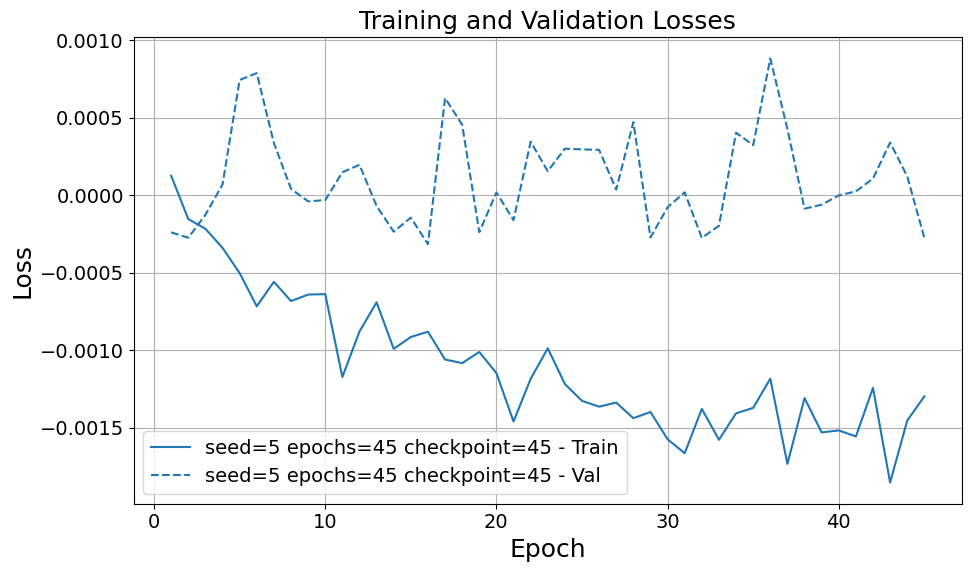

--------------------
Test RESULTS
--------------------


/tmp/ipykernel_3239423/3805463404.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metrics_df = metrics_df.applymap(lambda x: f"{x:.3g}" if isinstance(x, float) else x)


,expected_return,sharpe_ratio,max_drawdown,mean_entropy,mean_return,std_return
seed=5 epochs=45 checkpoint=45,4.07,0.0669,0.386,0.448,0.0026,0.0388


(701,)


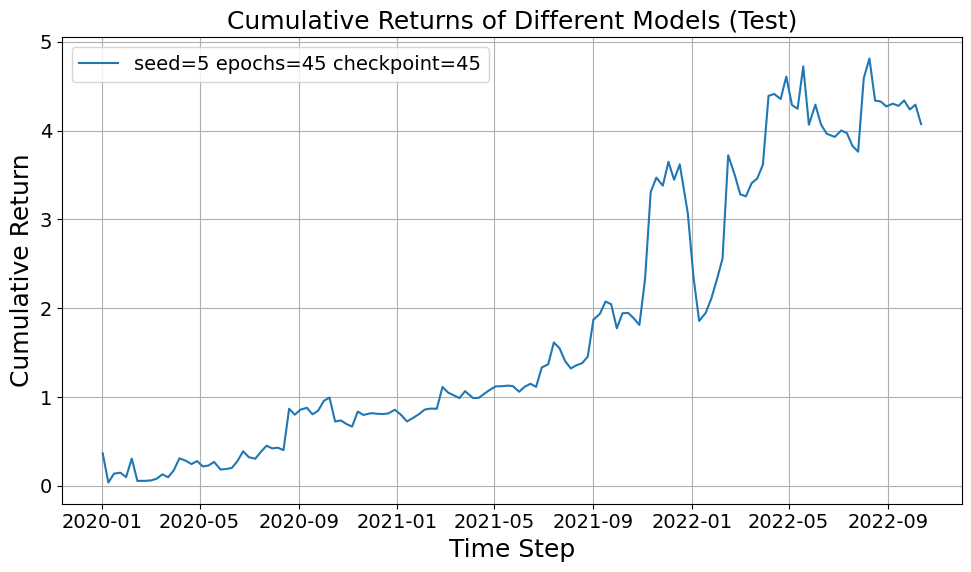

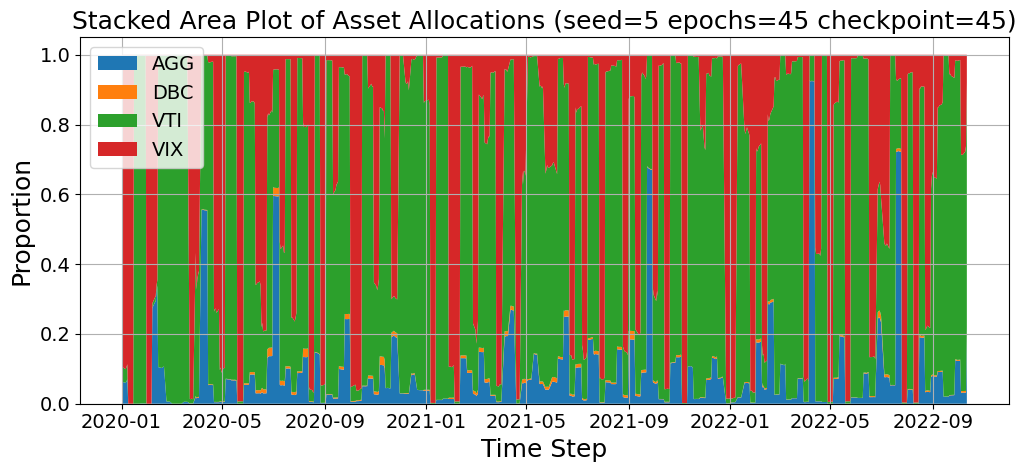

--------------------
Val RESULTS
--------------------


/tmp/ipykernel_3239423/3805463404.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metrics_df = metrics_df.applymap(lambda x: f"{x:.3g}" if isinstance(x, float) else x)


,expected_return,sharpe_ratio,max_drawdown,mean_entropy,mean_return,std_return
seed=5 epochs=45 checkpoint=45,2.18,0.0664,0.406,0.584,0.00247,0.0372


(637,)


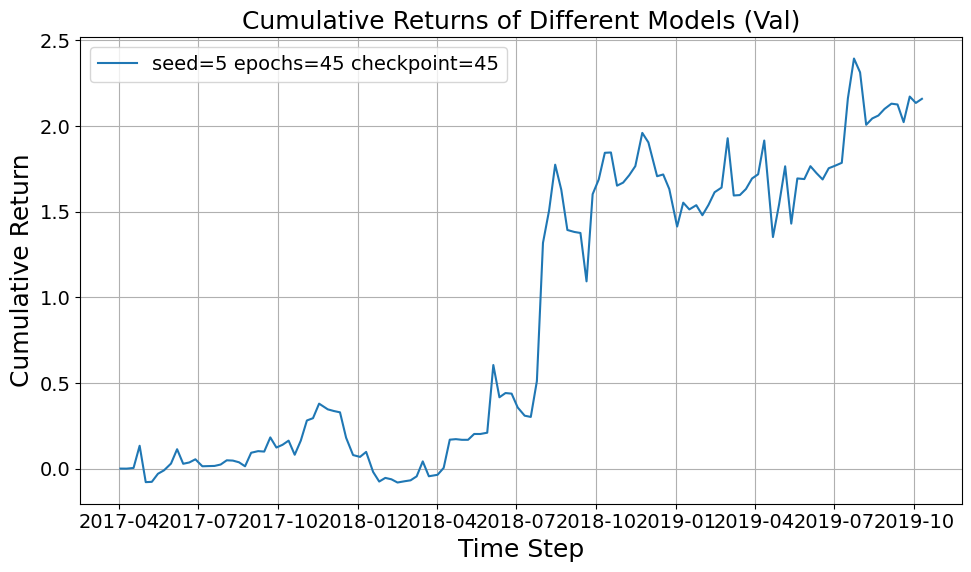

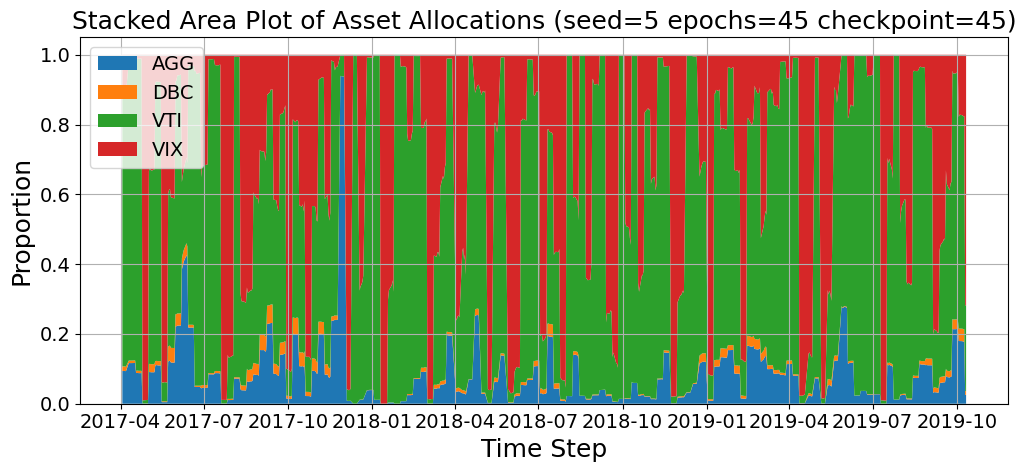

In [33]:
def hyperparam_search(experiments, metric="val_expected_return"):
    params_df = pd.DataFrame({k: v['params'] for k, v in experiments.items()}).T
    results_df = params_df
    for df_name in ["val", "test"]:
        df  = pd.DataFrame({k: v['results'][df_name]["metrics"] for k, v in experiments.items()}).T
        df = df.add_prefix(f'{df_name}_')
        results_df = pd.concat([results_df, df], axis=1)

    metric = "val_expected_return"
    params = params_df.columns 
    group_by_params = [p for p in params if p!= "seed"]
    agg_results_df = results_df.groupby(group_by_params)[metric].mean().reset_index().sort_values(metric, ascending=False).dropna().rename(columns={metric: f"mean_{metric}"})
    print("Hyperparam Search over seeds")
    display(agg_results_df)
    best_params = agg_results_df[group_by_params].iloc[0].to_dict()

    for col, val in best_params.items():
        results_df = results_df[results_df[col] == val]

    results_df = results_df.sort_values(metric, ascending=False)[params].iloc[0]
    return results_df.to_dict()

best_params = best_CNN_params = hyperparam_search(experiments)
filtered_experiements = { ek: e for ek,e in experiments.items() if all([(best_params[pk] == e["params"][pk] ) for pk in best_params])}
display_train_results(filtered_experiements)
# filtered_experiements = experiments
for dataset_key, dataset_idx in zip(["test", "val"], [test_idx,val_idx]):
    print("-"*20)
    print(dataset_key.capitalize() + " RESULTS")
    print("-"*20)
    display_experiment_results(filtered_experiements, dataset_key, dataset_idx )

In [34]:
true_filtered_experiements = { ek: e for ek,e in experiments.items() if all([(best_params[pk] == e["params"][pk]) for pk in best_params])}


In [35]:
experiments["Uniform Baseline"] = {"model": UniformModel(), "params": {"label": "Uniform Baseline"}, "results": {}}
for model_name, experiment in experiments.items():
    model = experiment["model"]
    # experiment["results"]["train"] = run_experiment(model, (X_train_tensor, y_train_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["val"] = run_experiment(model, (X_val_tensor, y_val_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5


In [36]:
best_params

{'seed': 5,
 'epochs': 45,
 'lambda_entropy': 0.0,
 'model': 'CNN',
 'learning_rate': 0.001,
 'loss': 'Standard',
 'jitter': 1.5,
 'weight_decay': 1e-05,
 'checkpoint': 45,
 'rebalance_freq': 5}

In [37]:

standard_experiment = list(true_filtered_experiements.values())[0]
model_path = os.path.join(experiment_path, model_file_name(standard_experiment["params"]))
model_path

'alpha-beta-CROWN/complete_verifier/trained_models/seed=5,epochs=45,lambda_entropy=0.0,model=CNN,learning_rate=0.001,loss=Standard,jitter=1.5,weight_decay=1e-05,checkpoint=45,rebalance_freq=5.pth'

/tmp/ipykernel_3239423/3805463404.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metrics_df = metrics_df.applymap(lambda x: f"{x:.3g}" if isinstance(x, float) else x)


,expected_return,sharpe_ratio,max_drawdown,mean_entropy,mean_return,std_return
final,4.07,0.0669,0.386,0.448,0.0026,0.0388
baseline,0.443,0.0325,0.186,1.38,0.000591,0.0182


(701,)
(701,)


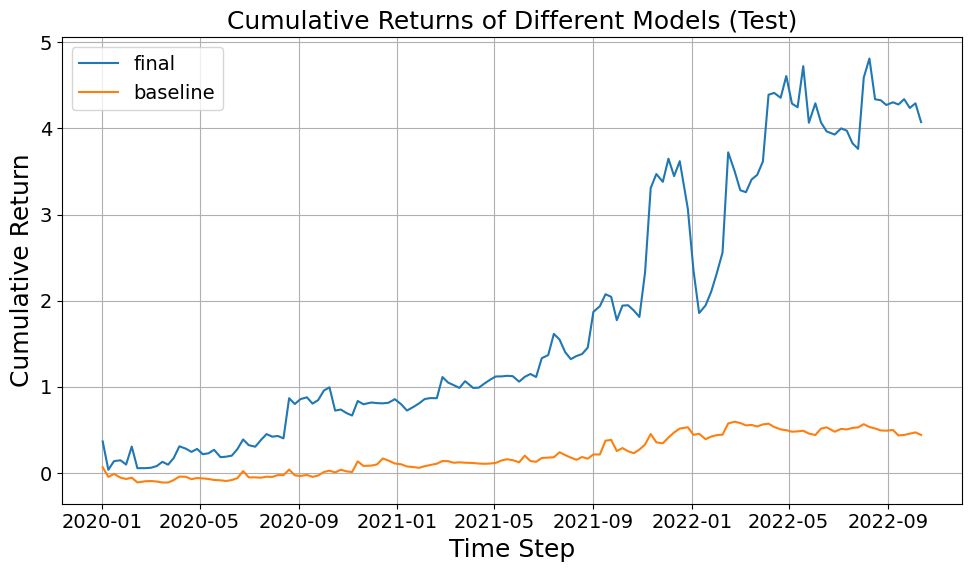

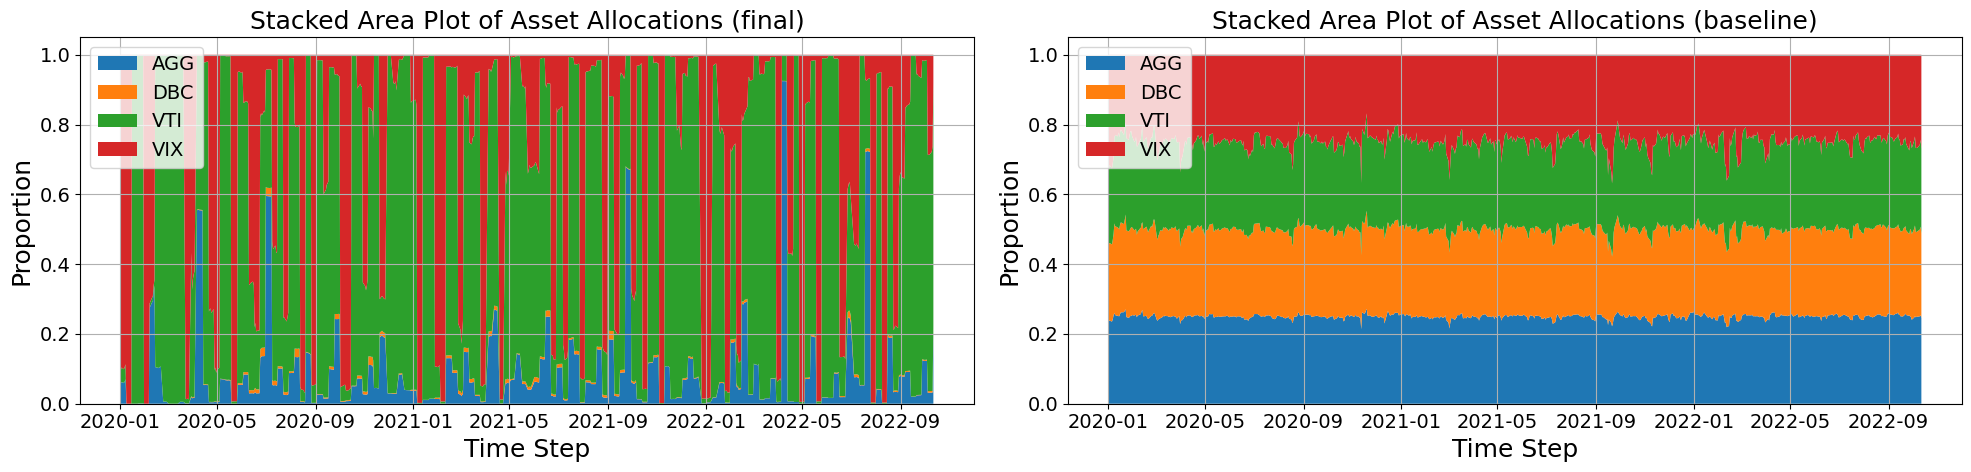

,expected_return,sharpe_ratio,max_drawdown,mean_entropy,mean_return,std_return
final,4.07,0.0669,0.386,0.448,0.0026,0.0388
baseline,0.443,0.0325,0.186,1.38,0.000591,0.0182


In [38]:
display_experiment_results({"final": standard_experiment, "baseline": experiments["Uniform Baseline"]}, "test", test_idx)

In [39]:

experiment = list(true_filtered_experiements.values())[0]
standard_cnn_path = os.path.join(experiment_path, model_file_name(experiment["params"]))


In [40]:
import pickle
from IPython import get_ipython


def run_abcrown_from_dict_ipython(args_dict, debug_file):
    cmd = "python alpha-beta-CROWN/complete_verifier/abcrown.py"

    output_path = args_dict["output_file"]
    results_path = args_dict["results_file"]
    cex_path = args_dict["cex_path"]

    

    if os.path.isfile(output_path):
        os.remove(output_path)
    if os.path.isfile(results_path):
        os.remove(results_path)

    with open(cex_path, "w") as f:
        json.dump( {"x": [], "adv_output": []}, f, indent=2)

    # data =

    
    # Append each argument with "--" prefix
    for key, value in args_dict.items():
        cmd += f" --{key} {value}"

    # cmd = f"{cmd} > {debug_file}"

    get_ipython().system(cmd)



In [41]:
# default_params = {
#     "config": "jamie.yaml",
#     "device": "cuda",
#     "start": "0",
#     "end": "4",
#     "conv_mode": "matrix",
#     "load_model": model_path,

# }

# results = {}#20

# force_run = True

# test_eps = [0.005, 0.01, 0.02, 0.05, 0.1]
# test_delta = [0.05, 0.1, 0.2, 0.3]

# test_eps = [0.01]
# test_delta = [0.1]


# for eps in test_eps:
#     results[eps] = {}
#     for delta in test_delta:
#         path = model_path[:-4] + f"_e={eps}_d={delta}"
#         output_path = path + "_output.pkl"
#         results_path = path + "_results.txt" 
#         debug_path = path + "_debug.txt"  

#         print(debug_path)

#         if not os.path.isfile(output_path) or not os.path.isfile(results_path) or force_run:
#             print(f"No results found, running at {eps}, {delta}")
#             args = default_params | {
#                 "epsilon": eps,
#                 "delta": delta,
#                 "output_file": output_path,
#                 "results_file": results_path,
                
#             }
#             run_abcrown_from_dict_ipython(args, debug_path)

        
#         if os.path.isfile(output_path) and os.path.isfile(results_path):
#             print("loading results")
#             with open(output_path, "rb") as f:
#                 output_data = pickle.load(f)
#             with open(results_path, "rb") as f:
#                 results_data = pickle.load(f)   
#         else:
#             print("failed to load results")
#             output_data = None
#             results_data = None    

#         results[eps][delta] = {"results_data": results_data, "output_data": output_data}

#         to_df = []
#         for eps, eps_dict in results.items():
#             for delta, delta_dict in eps_dict.items():
#                 summary_agg = {}
#                 if delta_dict["results_data"] is not None:
#                     summary = delta_dict["results_data"]["summary"]
#                     for k, v in summary.items():
#                         summary_agg[k] = len(v)

#                 to_df.append({
#                     "eps": eps,
#                     "delta": delta,
#                 } | summary_agg)

#         display(pd.DataFrame(to_df))


In [42]:
# w = torch.zeros()

# torch.min(w * ub, w * lb)

y = torch.zeros(2, 5, 4) 

w0 = torch.zeros(2, 4)                        # [B, A]
w  = w0.unsqueeze(1).repeat(1, horizon, 1)     # [B, T, A]
r  = (w * y).sum(dim=2)                        # [B, T]

# perturbation = PerturbationLpNorm(norm=np.inf, eps=robust_eps)
# x_perturbed = BoundedTensor(x, perturbation)
# ub, lb = model.compute_bounds(x=(x_perturbed,), method=params["loss"])

ub, lb = torch.zeros(2, 4) , torch.zeros(2, 4) 
ub = ub.unsqueeze(1).repeat(1, horizon, 1)
lb = lb.unsqueeze(1).repeat(1, horizon, 1)

wr = torch.min(y * ub, y * lb).sum(dim=2) 

wr

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [43]:
def robust_loss_fn_fn(params):
    if params["loss"] == "Standard":

        lambda_entropy = params["lambda_entropy"]
        def loss_fn(x, y, model, _):
            weights_ = model(x)  
            weights = weights_.unsqueeze(1).repeat(1, horizon, 1)

            portfolio_returns = (weights * y).sum(1).sum(1)

            natural_loss = -portfolio_returns.mean() 

            clamped_weights = weights.clamp(min=1e-8)
            entropy_loss = lambda_entropy * (-(clamped_weights * clamped_weights.log()).sum(dim=1).mean())

            return natural_loss -  entropy_loss, {}
        
        return loss_fn
        

        # def loss_fn(x, y, model, _):
        #     weights = model(x)

        #     asset_returns = ((1 + y).prod(1)-1)
        #     portfolio_returns = (asset_returns*weights).sum(1)
        #     natural_loss = -portfolio_returns.mean() 
        #     clamped_weights = weights.clamp(min=1e-8)
        #     entropy_loss = lambda_entropy * (-(clamped_weights * clamped_weights.log()).sum(dim=1).mean())
        #     return natural_loss -  entropy_loss
        # return loss_fn 
    
        # def loss_fn(x, y, model, _):
        #     weights = model(x)


        #     asset_returns = ((1 + y).prod(1)-1)

        #     portfolio_returns = (asset_returns*weights).sum(1)

        #     natural_loss = -portfolio_returns.mean() 

        #     clamped_weights = weights.clamp(min=1e-8)
        #     entropy_loss = lambda_entropy * (-(clamped_weights * clamped_weights.log()).sum(dim=1).mean())

        #     return natural_loss -  entropy_loss
        # return loss_fn 
    elif params["loss"] == "CROWN-IBP" or params["loss"] == "IBP":
        lambda_entropy = params["lambda_entropy"]
        true_alpha = params["alpha"]
        robust_eps = params["robust_eps"]
        warmup = params["warmup"]
        # eps_vector = torch.tensor(robust_eps, dtype=torch.float32, device=device)

        def loss_fn(x, y, model, epoch):

            alpha = true_alpha * (min(epoch, warmup)/ warmup)
            β   = 0.1#risk_penalty  # e.g. 0.5 or tune via validation

            w0 = model(x)                                  # [B, A]
            w  = w0.unsqueeze(1).repeat(1, horizon, 1)     # [B, T, A]
            r  = (w * y).sum(dim=2)                        # [B, T]

            if params["alpha"] > 0:
                perturbation = PerturbationLpNorm(norm=np.inf, eps=robust_eps)
                x_perturbed = BoundedTensor(x, perturbation)
                ub, lb = model.compute_bounds(x=(x_perturbed,), method=params["loss"])
                ub = ub.unsqueeze(1).repeat(1, horizon, 1)
                lb = lb.unsqueeze(1).repeat(1, horizon, 1)

                wr = torch.min(y * ub, y * lb).sum(dim=2)
                 
            else:
                wr = torch.zeros_like(r)

            μ  = r.mean(dim=1)  
            wr = wr.mean(dim=1)                     # [B]
            σ  = r.std(dim=1, unbiased=False)              # [B]


            # print(μ.mean(), wr.mean(), alpha, epoch)


            mv = μ * (1-alpha) + alpha * wr - β * σ
            return -mv.mean(), {"standard": μ.mean().item(), "robust": wr.mean().item()}


        return loss_fn
            

        # def loss_fn(x, y, model, epoch):

        #     alpha = true_alpha * (max(epoch, warmup)/ warmup)

            
        #     weights = model(x)

        #     # eps_tensor =eps_vector.repeat(x.shape[0], 50, 1)
        #     perturbation = PerturbationLpNorm(norm=np.inf, eps=robust_eps)
        #     x_perturbed = BoundedTensor(x, perturbation)
        #     ub, lb = model.compute_bounds(x=(x_perturbed,), method=params["loss"])

        #     asset_returns = ((1 + y).prod(1)-1)

        #     portfolio_returns = (asset_returns*weights).sum(1)
        #     worst_returns = torch.min(asset_returns * ub, asset_returns * lb).sum(1)

        #     natural_loss = -portfolio_returns.mean() 
        #     robust_loss = -worst_returns.mean() 

        #     clamped_weights = weights.clamp(min=1e-8)
        #     entropy_loss = -lambda_entropy * (-(clamped_weights * clamped_weights.log()).sum(dim=1).mean())

        #     return natural_loss * (1-alpha) + robust_loss * alpha + entropy_loss
        # return loss_fn
    
    elif params["loss"] in ["MTL-IBP", "Exp-IBP", "CC-IBP"]:
        lambda_entropy = params["lambda_entropy"]
        alpha = params["alpha"]
        robust_eps = params["robust_eps"]
        eps = robust_eps
        eps_vector = torch.tensor(eps, dtype=torch.float32, device=device)
        def pgd_attack_loss(x, y):
            loss = ((1 + y).prod(1) * x).sum(1)
            return loss
        def loss_fn(x, y, model):
            model.eval()
            output_adv = model(pgd_attack(model, x, y, eps_vector, pgd_attack_loss, n_steps=10))
            model.train()
            
            eps_tensor =eps_vector.repeat(x.shape[0], 50, 1)
            perturbation = PerturbationLpNorm(norm=np.inf, eps=eps_tensor)
            x_perturbed = BoundedTensor(x, perturbation)
            ub, lb = model.compute_bounds(x=(x_perturbed,), method="IBP")
            asset_returns = ((1 + y).prod(1)-1)

            weights = model(x)
            clamped_weights = weights.clamp(min=1e-8)
            entropy_loss = -lambda_entropy * (-(clamped_weights * clamped_weights.log()).sum(dim=1).mean())

            if params["loss"] == "CC-IBP":
                returns = torch.min(asset_returns * (output_adv * alpha + ub * (1-alpha)), asset_returns * (output_adv * alpha + lb * (1-alpha))).sum(1)
                loss = returns.mean()

                return loss + entropy_loss

            else:
                worst_returns = torch.min(asset_returns * ub, asset_returns * lb).sum(1)
                robust_loss = -worst_returns.mean() 
                output_adv
                adv_returns = (output_adv * asset_returns).sum(1)
                adv_loss = -adv_returns.mean() 

                if params["loss"] == "MTL-IBP":
                    loss = (adv_loss *(1 - alpha)) + (robust_loss * alpha) + entropy_loss
                elif params["loss"] == "Exp-IBP":
                    loss = (adv_loss **(1 - alpha)) + (robust_loss ** alpha) + entropy_loss

                return loss
        return loss_fn
    
    raise Exception("not foiund")

In [44]:
def get_bounded_model2(model):

    model = model.to(device)

    beta_crown_args = {
                "enable_alpha_crown": True,   # α-CROWN
                "enable_beta_crown": True,    # β-CROWN (branch-and-bound)
                "optimizer": "adam",          
                "iteration": 5,              # α/β optimization steps
                "lr_alpha": 0.5,
                "lr_beta": 0.05,
                "pruning_in_iteration": True
            }

    bound_opts = {
            "optimize_bound_args": beta_crown_args,
            "conv_mode": "matrix"
        }
    return BoundedModule(model, X_train_tensor, bound_opts=bound_opts)

In [45]:
# from auto_LiRPA.utils import graph_optimizer
# optimized_model = graph_optimizer(model)  

# # Now wrap in BoundedModule
# # bm = BoundedModule(optimized_model, torch.zeros(1, 50, 4))

In [46]:

# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class CustomSoftmax(nn.Module):
#     def __init__(self, dim: int = -1, eps: float = 1e-5):
#         super().__init__()
#         self.dim = dim
#         self.eps = eps

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         e = torch.exp(x)
#         return e / (e.sum(dim=self.dim, keepdim=True) + self.eps)
# class CNNAllocatorCausal3(nn.Module):
#     def __init__(self, input_channels=4, time_steps=50, hidden_size=100):
#         super().__init__()
#         self.time_steps = time_steps

#         # ZeroPad2d pads last two dims. Here (pad_left, pad_right, pad_top, pad_bottom).
#         # We want to pad 2 zeros on the "time" axis (height) at the top.
#         self.pad1 = nn.ZeroPad2d((0, 0, 2, 0))
#         self.conv1 = nn.Conv2d(
#             in_channels=input_channels,
#             out_channels=32,
#             kernel_size=(3, 1),
#             dilation=(1, 1),
#             padding=(0, 0)   # no internal padding; we handle it via pad1
#         )

#         self.pad2 = nn.ZeroPad2d((0, 0, 2, 0))
#         self.conv2 = nn.Conv2d(
#             in_channels=32,
#             out_channels=64,
#             kernel_size=(3, 1),
#             dilation=(1, 1),
#             padding=(0, 0)   # no internal padding; we handle it via pad2
#         )

#         self.relu = nn.ReLU()
#         self.flatten = nn.Flatten()
#         self.fc1 = nn.Linear(64 * time_steps, hidden_size)
#         self.fc2 = nn.Linear(hidden_size, input_channels)
#         self.softmax = CustomSoftmax(dim=-1)

#     def forward(self, x):
#         # x: (batch_size, time_steps, input_channels)
#         x = x.transpose(1, 2)      # → (B, C, T)
#         x = x.unsqueeze(-1)        # → (B, C, T, 1)

#         # First causal conv:
#         x = self.pad1(x)           # → (B, C, T+2, 1)  (padding=2 on top)
#         x = self.relu(self.conv1(x))  # → (B, 32, T, 1)

#         # Second causal conv:
#         x = self.pad2(x)           # → (B, 32, T+2, 1)
#         x = self.relu(self.conv2(x))  # → (B, 64, T, 1)

#         # Flatten and FC
#         x = self.flatten(x)        # → (B, 64 * T)
#         x = self.relu(self.fc1(x)) # → (B, hidden_size)
#         x = self.fc2(x)            # → (B, input_channels)
#         return self.softmax(x)


# # ----------------------------
# # Quick check with dummy input
# # # ----------------------------
# # if __name__ == "__main__":
# #     model = CNNAllocatorCausal(input_channels=4, time_steps=50, hidden_size=100)
# #     dummy_input = torch.randn(2, 50, 4)  # B=2, T=50, C=4
# #     output = model(dummy_input)
# #     print("Dummy input shape:", dummy_input.shape)  # (2, 50, 4)
# #     print("Output shape:     ", output.shape)       # (2, 4)

# model = get_bounded_model2(CNNAllocatorCausal3())

In [47]:
# x = torch.zeros(1, 50, 4).to("cuda")

In [48]:
# import torch
# import torch.nn as nn

# class Chomp1d(nn.Module):
#     """Remove the extra right‐pad to preserve causality."""
#     def __init__(self, chomp_size):
#         super().__init__()
#         self.chomp_size = chomp_size
#     def forward(self, x):
#         # x shape: (batch, channels, seq_len + chomp_size)
#         return x[:, :, :-self.chomp_size]

# class CausalConv1d(nn.Module):
#     """1D causal convolution with dilation and automatic cropping."""
#     def __init__(self, in_channels, out_channels, kernel_size, dilation):
#         super().__init__()
#         # pad so that conv output len = input len + padding*2 - dilation*(k-1) 
#         # we'll crop the extra on the right
#         self.padding = (kernel_size - 1) * dilation
#         self.conv = nn.Conv1d(
#             in_channels, out_channels, kernel_size,
#             padding=self.padding, dilation=dilation
#         )
#         self.chomp = Chomp1d(self.padding)

#     def forward(self, x):
#         x = self.conv(x)
#         return self.chomp(x)

# class TCN(nn.Module):
#     def __init__(self, num_inputs=4, seq_len=50, num_classes=4):
#         super().__init__()
#         # first TCN layer: 4 → 16 channels
#         self.conv1 = CausalConv1d(
#             in_channels=num_inputs, out_channels=16,
#             kernel_size=3, dilation=1
#         )
#         self.relu1 = nn.ReLU()

#         # second TCN layer: 16 → 32 channels, dilated
#         self.conv2 = CausalConv1d(
#             in_channels=16, out_channels=32,
#             kernel_size=3, dilation=2
#         )
#         self.relu2 = nn.ReLU()

#         # flatten 32 × 50 = 1600 features
#         self.flatten = nn.Flatten()

#         # dense layers: 1600 → 100 → 4
#         self.fc1 = nn.Linear(32 * seq_len, 100)
#         self.relu3 = nn.ReLU()
#         self.fc2 = nn.Linear(100, num_classes)

#         # final softmax over classes
#         self.softmax = nn.Softmax(dim=1)

#     def forward(self, x):
#         # x: (batch, T_t, N) → (batch, N, T_t)
#         x = x.permute(0, 2, 1)
#         x = self.relu1(self.conv1(x))
#         x = self.relu2(self.conv2(x))
#         x = self.flatten(x)
#         x = self.relu3(self.fc1(x))
#         x = self.softmax(self.fc2(x))
#         return x

import torch
import torch.nn as nn
import torch.nn.functional as F

class Chomp1d(nn.Module):
    """Remove the extra right-pad to preserve causality."""
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size
    def forward(self, x):
        return x[:, :, :-self.chomp_size]

class CausalConv1d(nn.Module):
    """1D causal convolution with dilation and automatic cropping."""
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super().__init__()
        self.padding = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(
            in_channels, out_channels, kernel_size,
            padding=self.padding, dilation=dilation
        )
        self.chomp = Chomp1d(self.padding)

    def forward(self, x):
        return self.chomp(self.conv(x))

class FixedReceptiveFieldTCN(nn.Module):
    def __init__(self, num_inputs=4, seq_len=50, num_classes=4):
        super().__init__()
        # layer 1: exactly as before
        self.conv1 = CausalConv1d(
            in_channels=num_inputs, out_channels=16,
            kernel_size=3, dilation=1
        )
        # layer 2: increased kernel & dilation so RF ≥ 50
        # receptive field = 1 + (3−1)*1 + (7−1)*8 = 1 + 2 + 48 = 51
        self.conv2 = CausalConv1d(
            in_channels=16, out_channels=32,
            kernel_size=7, dilation=8
        )

        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(32 * seq_len, 100)
        self.fc2 = nn.Linear(100, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.permute(0, 2, 1)             # → (B, 4, 50)
        x = self.relu(self.conv1(x))      # (B,16,50)
        x = self.relu(self.conv2(x))      # (B,32,50)
        x = self.flatten(x)               # (B,32*50)
        x = self.relu(self.fc1(x))        # (B,100)
        x = self.softmax(self.fc2(x))     # (B,4)
        return x


# Example instantiation and parameter count check:
if __name__ == "__main__":
    model = FixedReceptiveFieldTCN(num_inputs=4, seq_len=50, num_classes=4)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")  # → 162,280
    print(model(torch.zeros(22, 50,4)).shape)


Total parameters: 164,328
torch.Size([22, 4])


In [49]:

def loss_fn(x, y, model, _):
    weights_ = model(x)  
    weights = weights_.unsqueeze(1).repeat(1, horizon, 1)

    portfolio_returns = (weights * y).sum(1).sum(1)

    natural_loss = -portfolio_returns.mean() 

    clamped_weights = weights.clamp(min=1e-8)
    entropy_loss = 0 * (-(clamped_weights * clamped_weights.log()).sum(dim=1).mean())

    return natural_loss -  entropy_loss
        
        # return loss_fn

In [50]:
# x = X_test_tensor[:100].to(device)
# y = y_test_tensor[:100].to(device)

# x_ = X_train_tensor[:100].to(device)
# y_ = y_train_tensor[:100].to(device)

# # loss_fn(x, y, model, _),loss_fn(x_, y_, model, _),

In [51]:
model(x)

tensor([[0.2566, 0.2505, 0.2582, 0.2347],
        [0.2552, 0.2536, 0.2571, 0.2342],
        [0.2660, 0.2501, 0.2504, 0.2336],
        [0.2547, 0.2527, 0.2520, 0.2405],
        [0.2621, 0.2475, 0.2550, 0.2354],
        [0.2599, 0.2492, 0.2563, 0.2346],
        [0.2618, 0.2541, 0.2584, 0.2257],
        [0.2511, 0.2564, 0.2546, 0.2378],
        [0.2571, 0.2480, 0.2601, 0.2348],
        [0.2575, 0.2501, 0.2548, 0.2377]], grad_fn=<SoftmaxBackward0>)

In [52]:
FinalCNN()

FinalCNN(
  (conv1): Conv1d(4, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3200, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
  (softmax): CustomSoftmax()
)

In [72]:


best_CNN_params = {'seed': [0,1,2],
 'epochs': [100],
 'lambda_entropy': [0.025],
 'model': ['CNN'],
 'learning_rate': [0.001],
 'rebalance_freq': [5],
 'jitter': [0.03],
  "loss": ["CROWN-IBP"],
  "alpha": [0, 0.25, 0.5, 0.75, 1],
  "robust_eps": [0.005],
  "warmup": [20],
  "checkpoint_freq": [10],
}


best_CNN_params = {'seed': [0,1],
 'epochs': [60],
 'lambda_entropy': [0.025],
 'model': ['CNN'],
 'learning_rate': [0.001],
 'rebalance_freq': [5],
 'jitter': [0.03],
  "loss": ["CROWN-IBP"],
  "alpha": [0, 0.25, 0.5, 0.75, 1],
  "robust_eps": [0.005],
  "warmup": [20],
  "checkpoint_freq": [10],
}


# tp check how to make each seed more similar
best_CNN_params = {'seed': [0,1,2,3],
 'epochs': [10],
 'lambda_entropy': [0.025],
 'model': ['CNN'],
 'learning_rate': [0.001],
 'rebalance_freq': [5],
 'jitter': [0.03, 0],
  "loss": ["Standard"],
  # "alpha": [0, 0.25, 0.5, 0.75, 1],
  # "robust_eps": [0.005],
  # "warmup": [20],
  # "checkpoint_freq": [10],
}



params_grids = [{
    "seed": [10, 5, 6, 8],
    "epochs": [60],
    "lambda_entropy": [0.000],#, 0.4],#, 0.0025],#[0.0001, 0.001, 0.01, 0.025, 0.05, 0.1],
    "model": ["CNN"],
    "learning_rate": [0.001],
    "loss": ["CROWN-IBP"],
    "jitter" : [1.5],
    "weight_decay": [1e-5],
    "robust_eps": [0.01],
    "alpha": [0, 0.0625, 0.125, 0.25, 0.375, 0.5, 0.75, 1],
    "warmup": [20]
},
{
    "seed": [10],
    "epochs": [60],
    "lambda_entropy": [0.000],#, 0.4],#, 0.0025],#[0.0001, 0.001, 0.01, 0.025, 0.05, 0.1],
    "model": ["CNN"],
    "learning_rate": [0.001],
    "loss": ["Standard"],
    "jitter" : [1.5],
    "weight_decay": [1e-5],
    # "robust_eps": [0.01],
    # "alpha": [0.25, 0.5],#, 0.75, 1],
    # "warmup": [20]
}
]


def dataset_fn(params):
    jitter = Jitter(sigma=params.get("jitter", 0.025))
    train_dataset = AugmentedTimeSeriesDataset(X_train_tensor, y_train_tensor, transform=jitter)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader


experiment_path = "alpha-beta-CROWN/complete_verifier/trained_models"
experiments = get_experiment_model(lambda x: FinalCNN().to(device), experiment_path, params_grids, robust_loss_fn_fn, dataset_fn, device=device)

for model_name, experiment in experiments.items():
    model = experiment["model"]
    # experiment["params"]["rebalance_freq"] = 5

    # if experiment["params"]["loss"] == "Standard":
        # experiment["params"]["alpha"] = 0
        # experiment["params"]["alpha"] = 0
    # experiment["results"]["train"] = run_experiment(model, (X_train_tensor, y_train_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["val"] = run_experiment(model, (X_val_tensor, y_val_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)


None
[True]
Loading alpha-beta-CROWN/complete_verifier/trained_models/seed=10,epochs=60,lambda_entropy=0.0,model=CNN,learning_rate=0.001,loss=CROWN-IBP,jitter=1.5,weight_decay=1e-05,robust_eps=0.01,alpha=0,warmup=20,checkpoint=60.pth
None
[True]
Loading alpha-beta-CROWN/complete_verifier/trained_models/seed=10,epochs=60,lambda_entropy=0.0,model=CNN,learning_rate=0.001,loss=CROWN-IBP,jitter=1.5,weight_decay=1e-05,robust_eps=0.01,alpha=0.0625,warmup=20,checkpoint=60.pth
None
[True]
Loading alpha-beta-CROWN/complete_verifier/trained_models/seed=10,epochs=60,lambda_entropy=0.0,model=CNN,learning_rate=0.001,loss=CROWN-IBP,jitter=1.5,weight_decay=1e-05,robust_eps=0.01,alpha=0.125,warmup=20,checkpoint=60.pth
None
[True]
Loading alpha-beta-CROWN/complete_verifier/trained_models/seed=10,epochs=60,lambda_entropy=0.0,model=CNN,learning_rate=0.001,loss=CROWN-IBP,jitter=1.5,weight_decay=1e-05,robust_eps=0.01,alpha=0.25,warmup=20,checkpoint=60.pth
None
[True]
Loading alpha-beta-CROWN/complete_verifi

Epochs:   2%|▏         | 1/60 [00:00<00:27,  2.13ep/s, train_loss=-0.00003, val_loss=-0.0001204096]

{'standard': 0.03665085762622766, 'robust': 0.0}
{'standard': 0.024529315807740204, 'robust': 0.0}


Epochs:   3%|▎         | 2/60 [00:00<00:25,  2.27ep/s, train_loss=-0.00019, val_loss=-0.0002719671]

{'standard': 0.05696642080874881, 'robust': 0.0}
{'standard': 0.023547698998299893, 'robust': 0.0}


Epochs:   5%|▌         | 3/60 [00:01<00:24,  2.33ep/s, train_loss=-0.00035, val_loss=-0.0001375814]

{'standard': 0.08311554000101751, 'robust': 0.0}
{'standard': 0.029240327057777904, 'robust': 0.0}


Epochs:   7%|▋         | 4/60 [00:01<00:23,  2.36ep/s, train_loss=-0.00032, val_loss=-0.0002551769]

{'standard': 0.12320941881625913, 'robust': 0.0}
{'standard': 0.028596327800187282, 'robust': 0.0}


Epochs:   8%|▊         | 5/60 [00:02<00:25,  2.15ep/s, train_loss=-0.00043, val_loss=-0.0001477007]

{'standard': 0.15744147024088306, 'robust': 0.0}
{'standard': 0.0332920701475814, 'robust': 0.0}


Epochs:  10%|█         | 6/60 [00:02<00:24,  2.22ep/s, train_loss=-0.00073, val_loss=0.0000240572] 

{'standard': 0.2000417008093791, 'robust': 0.0}
{'standard': 0.04135691572446376, 'robust': 0.0}


Epochs:  12%|█▏        | 7/60 [00:03<00:22,  2.35ep/s, train_loss=-0.00075, val_loss=-0.0005023128]

{'standard': 0.20234264274404268, 'robust': 0.0}
{'standard': 0.02621112893393729, 'robust': 0.0}


Epochs:  13%|█▎        | 8/60 [00:03<00:21,  2.45ep/s, train_loss=-0.00076, val_loss=0.0001760953] 

{'standard': 0.21882315454422496, 'robust': 0.0}
{'standard': 0.04792008065851405, 'robust': 0.0}


Epochs:  15%|█▌        | 9/60 [00:03<00:20,  2.43ep/s, train_loss=-0.00079, val_loss=0.0001104018]

{'standard': 0.22070316632743925, 'robust': 0.0}
{'standard': 0.043220908381044865, 'robust': 0.0}


Epochs:  17%|█▋        | 10/60 [00:04<00:20,  2.40ep/s, train_loss=-0.00096, val_loss=-0.0002971991]

{'standard': 0.23182814332540147, 'robust': 0.0}
{'standard': 0.057246650161687285, 'robust': 0.0}


Epochs:  18%|█▊        | 11/60 [00:04<00:20,  2.41ep/s, train_loss=-0.00089, val_loss=-0.0003150588]

{'standard': 0.24024388016550802, 'robust': 0.0}
{'standard': 0.04088746855268255, 'robust': 0.0}


Epochs:  20%|██        | 12/60 [00:05<00:19,  2.40ep/s, train_loss=-0.00081, val_loss=-0.0005217086]

{'standard': 0.22196340610389598, 'robust': 0.0}
{'standard': 0.0424538126681, 'robust': 0.0}


Epochs:  22%|██▏       | 13/60 [00:05<00:19,  2.40ep/s, train_loss=-0.00097, val_loss=-0.0000153103]

{'standard': 0.24344631665735506, 'robust': 0.0}
{'standard': 0.051260216190712526, 'robust': 0.0}


Epochs:  23%|██▎       | 14/60 [00:05<00:19,  2.38ep/s, train_loss=-0.00098, val_loss=-0.0004754094]

{'standard': 0.2625571453681914, 'robust': 0.0}
{'standard': 0.05097223323537037, 'robust': 0.0}


Epochs:  23%|██▎       | 14/60 [00:06<00:20,  2.26ep/s, train_loss=-0.00098, val_loss=-0.0004754094]


KeyboardInterrupt: 

# Runtime analysis here!

In [90]:
import torch
import torch.nn as nn
import torch.optim as optim


def pgd_attack_loss(allocations, returns):
    """
    Compute negative mean return over the horizon: used for adversarial attack.
    allocations: (B, N_assets)
    returns: (B, horizon, N_assets)
    """
    horizon = returns.size(1)
    alloc_expanded = allocations.unsqueeze(1).repeat(1, horizon, 1)
    per_step = (alloc_expanded * returns).sum(dim=2)  # (B, horizon)
    mean_return = per_step.mean(dim=1)               # (B,)
    return -mean_return


def pgd_attack(model, X, returns, epsilon=0.05, alpha=0.1, num_iter=20, device='cuda'):
    """
    PGD to find worst-case (lowest mean) return adversarial perturbation.
    Assumes inputs X are standardized (zero mean, unit variance) 
    and so does not clamp to [0,1], only enforces epsilon-ball in feature space.
    """
    was_training = model.training
    model.eval()

    X_adv = X.detach().clone().to(device)
    X_orig = X_adv.clone()
    returns = returns.to(device)

    # random initialization within epsilon-ball
    X_adv = X_orig + torch.empty_like(X_orig).uniform_(-epsilon, epsilon)

    for _ in range(num_iter):
        with torch.enable_grad():
            X_adv.requires_grad_()
            alloc = model(X_adv)
            loss = pgd_attack_loss(alloc, returns).mean()
            grad = torch.autograd.grad(loss, X_adv)[0]

        # ascent step
        X_adv = X_adv.detach() + alpha * torch.sign(grad)
        # project back into epsilon-ball around original X
        delta = torch.clamp(X_adv - X_orig, -epsilon, epsilon)
        X_adv = (X_orig + delta).detach()

    if was_training:
        model.train()
    else:
        model.eval()
    return X_adv


def pgd_loss_fn_fn(params):
    """
    Returns a loss function for adversarial robustness using PGD with warmup for alpha_mix.
    Designed for standardized inputs (zero mean, unit variance).
    Expects params:
      epsilon (default=0.05), pgd_alpha (default=0.1), pgd_iters (default=20),
      alpha_mix (default=0.5), beta (default=0.1), warmup (default=10)
    """
    epsilon   = params.get("epsilon",   0.01)
    pgd_alpha = params.get("pgd_alpha", 0.1)
    pgd_iters = params.get("pgd_iters", 20)
    alpha_mix = params.get("alpha_mix", 0.25)
    beta      = params.get("beta",      0.1)
    warmup    = params.get("warmup",    20)

    def loss_fn(x, returns, model, epoch, bounded_model):
        # compute scheduled mix weight

        current_mix = alpha_mix * min(epoch, warmup) / warmup
        # print(alpha_mix, min(epoch, warmup), epoch)

        # adversarial example under standardized feature scale
        X_adv = pgd_attack(model, x, returns,
                            epsilon=epsilon, alpha=pgd_alpha,
                            num_iter=pgd_iters, device=x.device)
        # forward passes
        alloc_clean = model(x)
        alloc_adv   = model(X_adv)
        horizon = returns.size(1)

        # compute return trajectories
        r_clean = (alloc_clean.unsqueeze(1).repeat(1, horizon, 1) * returns).sum(dim=2)
        r_adv   = (alloc_adv.unsqueeze(1).repeat(1, horizon, 1) * returns).sum(dim=2)

        # statistics
        mu    = r_clean.mean(dim=1)
        mu_a  = r_adv.mean(dim=1)
        sigma = r_clean.std(dim=1, unbiased=False)

        # mixed objective: increase adversarial weight gradually
        mixed = mu * (1 - current_mix) + current_mix * mu_a - beta * sigma
        loss = - mixed.mean()

        extra = {
            "mu":        mu.mean().item(),
            "mu_a":      mu_a.mean().item(),
            # "sigma":     sigma.mean().item(),
            # "alpha_mix": current_mix
        }
        return loss, extra

    return loss_fn


In [ ]:
models = [get_bounded_model2(FinalCNN()), get_bounded_model2(LSTM_Unrolled(n_assets, 8, 1, n_assets))]

In [141]:
names = ["CNN", "LSTM"]

models = models[:1]
N = 100

In [142]:
for model, name in zip(models, names):
    start_time = time.perf_counter()
    for i in range(N):
        perturbation = PerturbationLpNorm(norm=np.inf, eps=0.01)
        x_perturbed = BoundedTensor(torch.randn(32, 50,4), perturbation).to(device)
        ub, lb = model.compute_bounds(x=(x_perturbed,), method="IBP")
    end_time = time.perf_counter()
    elapsed_time = end_time - start_time

    print(name, elapsed_time/N)


CNN 0.0037634082400472835


In [143]:
for model, name in zip(models, names):
    start_time = time.perf_counter()
    for i in range(N):
        perturbation = PerturbationLpNorm(norm=np.inf, eps=0.01)
        x_perturbed = BoundedTensor(torch.randn(32, 50,4), perturbation).to(device)
        ub, lb = model.compute_bounds(x=(x_perturbed,), method="CROWN-IBP")
    end_time = time.perf_counter()
    elapsed_time = end_time - start_time

    print(name, elapsed_time/N)

CNN 0.012627768120146356


In [ ]:
def pgd_attack2(model, x_init, y, eps, loss_fn, n_steps=20, step_size=0.1, device='cuda:0'):
    # 0/0
    model.eval()
    x0 = x_init.to(device)
    y0 = y.to(device)
    eps = eps.to(device) if torch.is_tensor(eps) else eps

    # start from the clean example, one tensor that always requires grad
    adv = x0.clone().detach().requires_grad_(True)
    best_loss = torch.full((x0.size(0),), -float('inf'), device=device)
    with torch.enable_grad():
        for _ in range(n_steps):
            # zero the gradient from the previous step
            if adv.grad is not None:
                adv.grad.zero_()
            # forward + objective (we do -loss because we want the *worst* point)
            logits = model(adv)
            obj = -loss_fn(logits, y0)            # this must be a Tensor, not a float

            # keep the best‐so‐far point per example
            mask = (obj >= best_loss).view(-1, *([1] * (adv.dim()-1)))
            best_loss = torch.where(obj >= best_loss, obj.detach(), best_loss)
            # you can store best‐so‐far inputs if needed, same pattern

            # compute gradient w.r.t. adv
            obj.sum().backward()                  # builds d(obj)/d(adv)
            # PGD step: modify adv.data in‐place, then clamp
            adv.data = (adv.data + step_size * adv.grad.data.sign())
            adv.data = adv.data.clamp(x0 - eps, x0 + eps)

    # at the end, adv contains your adversarial examples
    return adv.detach()

In [ ]:
for model, name in zip(models[:1], names[:1]):
    start_time = time.perf_counter()
    for i in range(20):
        
        pgd_attack(model, torch.randn(32, 50, 4),  torch.randn(32, 5, 4))
    end_time = time.perf_counter()
    elapsed_time = end_time - start_time

    print(elapsed_time/20)

0.07098192764970009


In [ ]:
model = get_bounded_model2(FinalCNN())
perturbation = PerturbationLpNorm(norm=np.inf, eps=0.01)
x_perturbed = BoundedTensor(torch.zeros(2, 50,4), perturbation).to(device)
ub, lb = model.compute_bounds(x=(x_perturbed,), method="CROWN-IBP")

In [ ]:

model =  get_bounded_model2(LSTM_Unrolled(n_assets, 8, 1, n_assets))#.to(device)
perturbation = PerturbationLpNorm(norm=np.inf, eps=0.01)
x_perturbed = BoundedTensor(torch.zeros(2, 50,4), perturbation).to(device)
ub, lb = model.compute_bounds(x=(x_perturbed,), method="CROWN-IBP")

In [ ]:
model = get_bounded_model2()

In [ ]:

start_time = time.perf_counter()
for i in range(10):
    perturbation = PerturbationLpNorm(norm=np.inf, eps=0.01)
    x_perturbed = BoundedTensor(torch.randn(32, 50,4), perturbation).to(device)
    ub, lb = model.compute_bounds(x=(x_perturbed,), method="IBP")
end_time = time.perf_counter()

elapsed_time = end_time - start_time
print(f"my_function took: {elapsed_time:.6f} seconds")

my_function took: 1.408709 seconds


/tmp/ipykernel_3239423/3805463404.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10')
/tmp/ipykernel_3239423/3805463404.py:25: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


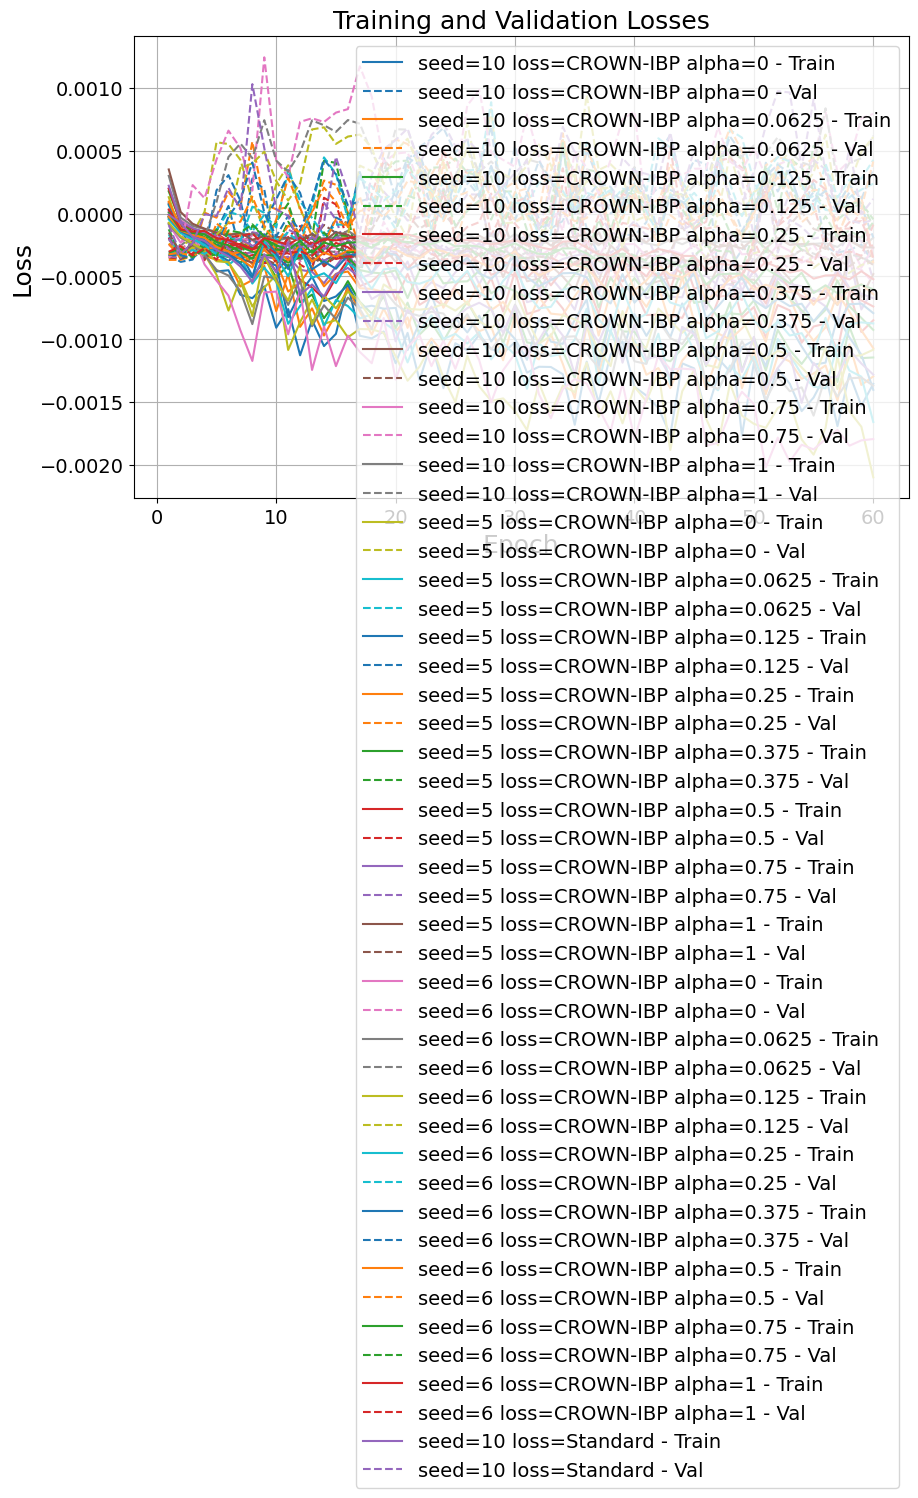

In [96]:
display_train_results(experiments)

test


/tmp/ipykernel_3239423/1234283294.py:25: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(range(len(cum_returns)), cum_returns, label=label)


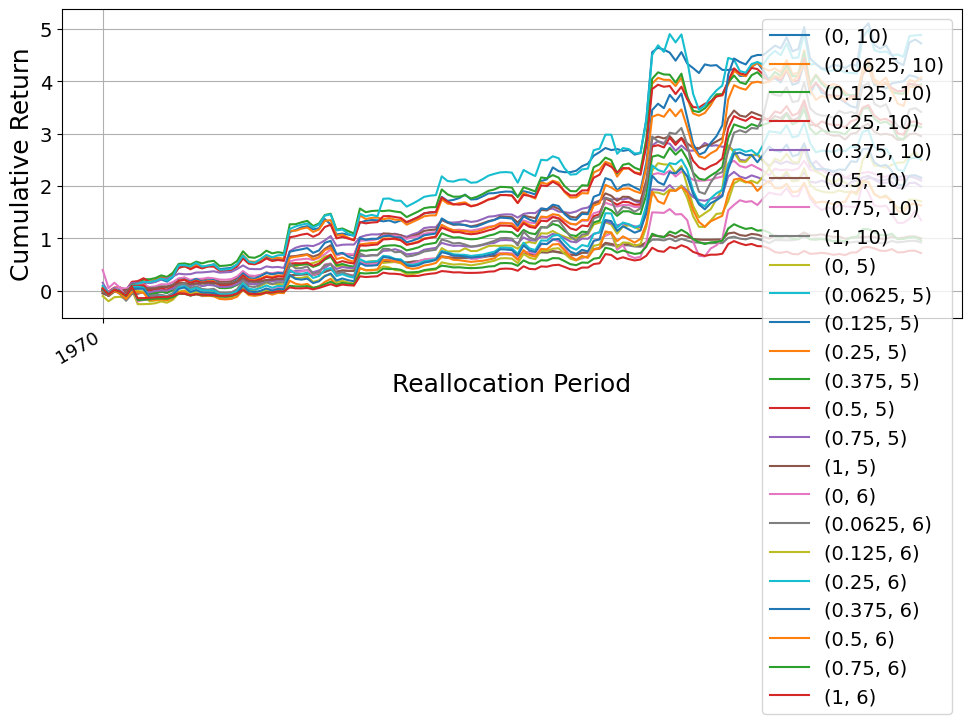

val


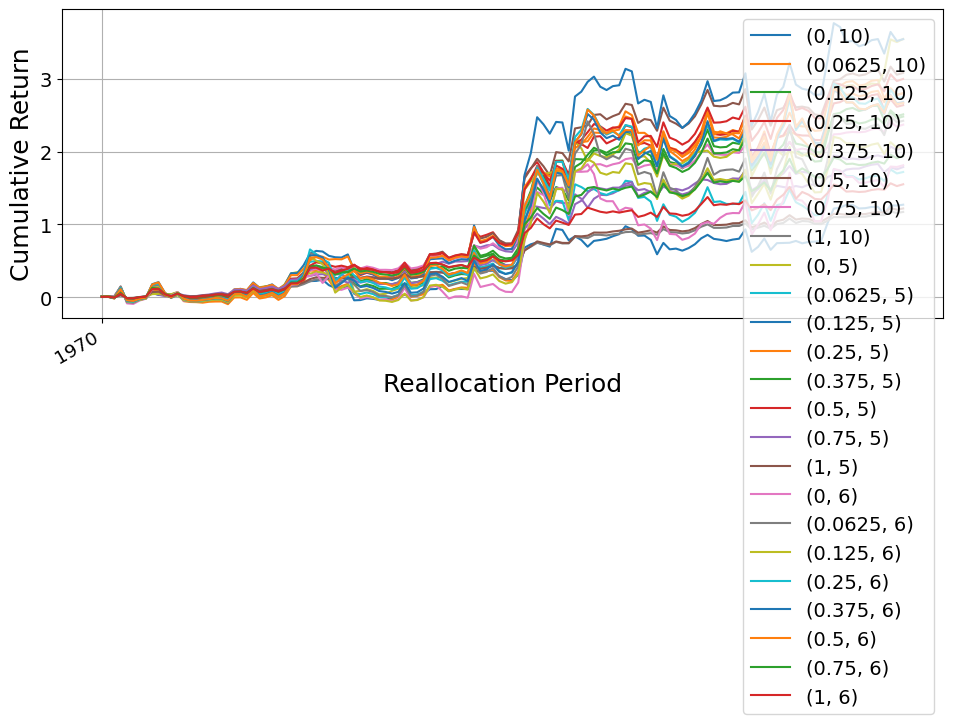

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# crs_ = { e["params"]["robust_eps"]: e["results"]["test"]["raw"]["cum_returns"] for ek,e in CNN_experiments.items() if (e["params"]["checkpoint"] == 75)}

for dataset in ["test", "val"]:
    print(dataset)
    crs = { (e["params"].get("alpha",0), e["params"]["seed"]) : e["results"][dataset]["raw"]["cum_returns"][::5] for ek, e in experiments.items()}

    # crs = { e["params"]["alpha"]: e["results"]["test"]["raw"]["cum_returns"][::5] for ek, e in CNN_experiments.items() if (e["params"]["checkpoint"] == 60)}

    # crs = {"Standard (Train ε=0)": standard_experiment["results"]["test"]["raw"]["cum_returns"][::5]}

    # for eps in train_eps:#[0.001, 0.01, 0.015]:
    #    crs[ f'Robust (Train ε={eps})'] = crs_[eps]

    cumulative_returns_dict = crs

    # Example: use same dates array from previous step if available, else use integer index
    # dates = [...]  # array of datetime objects
    time_points = test_indices[50:-5][::5]#range(1, len(next(iter(cumulative_returns_dict.values()))) + 1)

    plt.figure(figsize=(10, 6))
    for label, cum_returns in cumulative_returns_dict.items():
        plt.plot(range(len(cum_returns)), cum_returns, label=label)

    plt.xlabel("Reallocation Period")
    plt.ylabel("Cumulative Return")
    # plt.ylim(bottom=0)  # Ensure returns start at zero or above
    plt.legend()
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    plt.setp(plt.gca().get_xticklabels(), rotation=30, ha="right", fontsize='small')

    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [57]:
# import matplotlib.pyplot as plt
# import numpy as np

# # crs_ = { e["params"]["robust_eps"]: e["results"]["test"]["raw"]["cum_returns"] for ek,e in CNN_experiments.items() if (e["params"]["checkpoint"] == 75)}

# for seed in [0,1]:
#     for dataset in ["test", "val"]:
#         print(dataset)
#         crs = { (e["params"]["alpha"],e["params"]["seed"]) : e["results"][dataset]["raw"]["cum_returns"][::5] for ek, e in CNN_experiments.items() if (e["params"]["checkpoint"] == 60 and e["params"]["seed"] == seed)}

#         # crs = { e["params"]["alpha"]: e["results"]["test"]["raw"]["cum_returns"][::5] for ek, e in CNN_experiments.items() if (e["params"]["checkpoint"] == 60)}

#         # crs = {"Standard (Train ε=0)": standard_experiment["results"]["test"]["raw"]["cum_returns"][::5]}

#         # for eps in train_eps:#[0.001, 0.01, 0.015]:
#         #    crs[ f'Robust (Train ε={eps})'] = crs_[eps]

#         cumulative_returns_dict = crs

#         # Example: use same dates array from previous step if available, else use integer index
#         # dates = [...]  # array of datetime objects
#         time_points = test_indices[50:-5][::5]#range(1, len(next(iter(cumulative_returns_dict.values()))) + 1)

#         plt.figure(figsize=(10, 6))
#         for label, cum_returns in cumulative_returns_dict.items():
#             plt.plot(range(len(cum_returns)), cum_returns, label=label)

#         plt.xlabel("Reallocation Period")
#         plt.ylabel("Cumulative Return")
#         # plt.ylim(bottom=0)  # Ensure returns start at zero or above
#         plt.legend()
#         plt.gca().xaxis.set_major_locator(mdates.YearLocator())
#         plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
#         plt.setp(plt.gca().get_xticklabels(), rotation=30, ha="right", fontsize='small')

#         plt.grid(True)
#         plt.tight_layout()
#         plt.show()


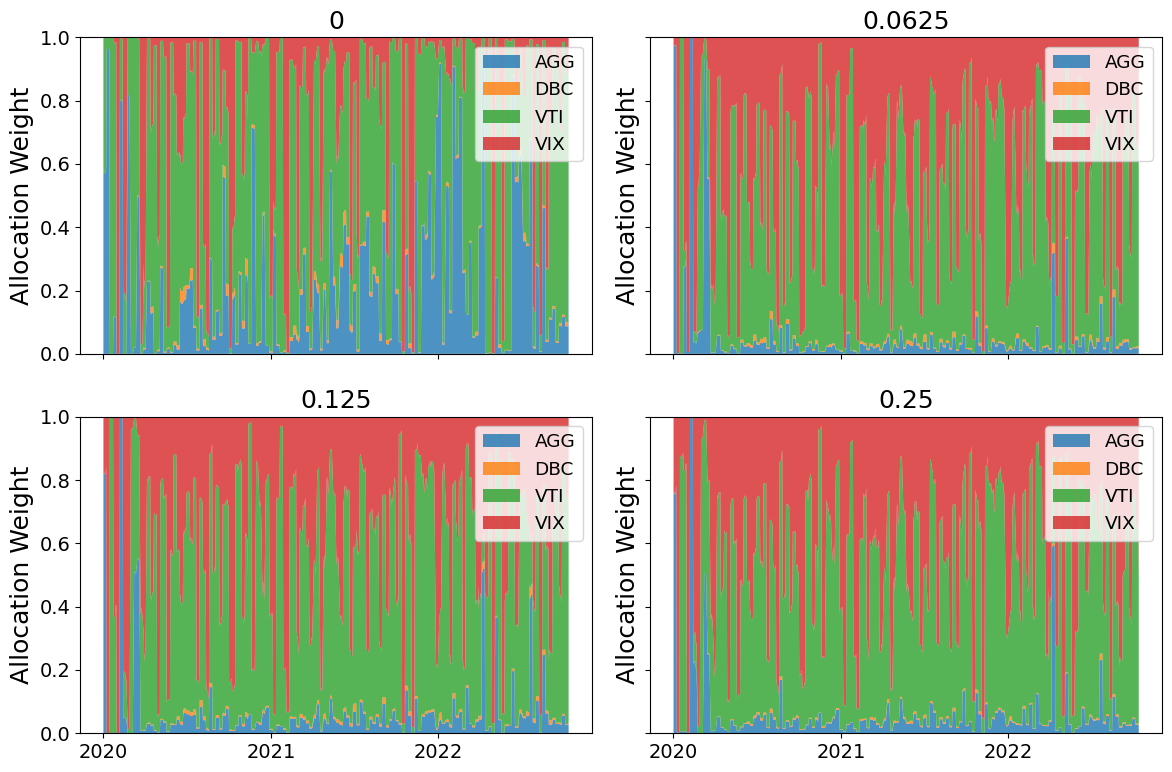

In [58]:
# robust_weights = { e["params"]["seed"]: e["results"]["test"]["raw"]["weights"] for ek,e in experiments.items()}
# robust_weights = {"Standard (Train ε=0)": standard_experiment["results"]["test"]["raw"]["weights"]}
# for eps in [0.001, 0.01, 0.015]:
#    robust_weights[ f'Robust (Train ε={eps})'] = robust_weights_[eps]
robust_weights = { e["params"].get("alpha", 0): e["results"]["test"]["raw"]["weights"] for ek,e in experiments.items() }


weights_dict = robust_weights


asset_labels = asset_names
time_points = test_indices[:-55]  # 1 to 151 periods


fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()


for ax, (label, weights) in zip(axes, weights_dict.items()):
   # Create a stackplot: weights[:,0], weights[:,1], weights[:,2], weights[:,3]
   ax.stackplot(time_points,
                weights[:, 0],
                weights[:, 1],
                weights[:, 2],
           weights[:, 3],
                labels=asset_labels,
                alpha=0.8)
   ax.set_title(label)
   # ax.set_xlabel("Date")
   ax.set_ylabel("Allocation Weight")
   ax.set_ylim(0, 1)
   ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=1, maxticks=6))
   ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
   ax.legend(loc='upper right', fontsize='small')


fig.tight_layout()
plt.show()


#### Effect on allocations

In [59]:
mean_entropies = { e["params"].get("alpha",0): entropy(e["results"]["test"]["raw"]["weights"]).mean() for ek,e in experiments.items()}
# mean_entropies[0] = entropy(standard_experiment["results"]["test"]["raw"]["weights"]).mean()
mean_entropies

{0: tensor(0.6059),
 0.0625: tensor(0.6215),
 0.125: tensor(0.6787),
 0.25: tensor(0.7014),
 0.375: tensor(0.7065),
 0.5: tensor(0.7402),
 0.75: tensor(0.7026),
 1: tensor(0.7256)}

In [60]:
# robust_weights_ = { e["params"]["robust_eps"]: e["results"]["test"]["raw"]["weights"] for ek,e in CNN_experiments.items() if (e["params"]["checkpoint"] == 75)}
# robust_weights = {"Standard (Train ε=0)": standard_experiment["results"]["test"]["raw"]["weights"]}
# for eps in [0.001, 0.01, 0.015]:
#    robust_weights[ f'Robust (Train ε={eps})'] = robust_weights_[eps]


# weights_dict = robust_weights


# asset_labels = asset_names
# time_points = test_indices[:-55]  # 1 to 151 periods


# fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
# axes = axes.flatten()


# for ax, (label, weights) in zip(axes, weights_dict.items()):
#    # Create a stackplot: weights[:,0], weights[:,1], weights[:,2], weights[:,3]
#    ax.stackplot(time_points,
#                 weights[:, 0],
#                 weights[:, 1],
#                 weights[:, 2],
#            weights[:, 3],
#                 labels=asset_labels,
#                 alpha=0.8)
#    ax.set_title(label)
#    # ax.set_xlabel("Date")
#    ax.set_ylabel("Allocation Weight")
#    ax.set_ylim(0, 1)
#    ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=1, maxticks=6))
#    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
#    ax.legend(loc='upper right', fontsize='small')


# fig.tight_layout()
# plt.show()


In [61]:
# X_t

In [62]:
# best_robust_exps = {}

# for eps in train_eps:
#     print(eps)
#     eps_experiements = { ek: e for ek,e in CNN_experiments.items() if eps == e["params"]["robust_eps"] and e["params"]["checkpoint"] >= e["params"]["warmup"] }
#     best_params = hyperparam_search(eps_experiements)
#     exp = { ek: e for ek,e in CNN_experiments.items() if all([(best_params[pk] == e["params"][pk]) for pk in best_params])}
#     assert len(exp.keys()) == 1
#     best_robust_exps[eps] = list(exp.values())[0]
    



In [63]:
# import matplotlib.pyplot as plt
# import numpy as np

# # crs_ = { e["params"]["robust_eps"]: e["results"]["test"]["raw"]["cum_returns"] for ek,e in CNN_experiments.items() if (e["params"]["checkpoint"] == 75)}

# crs_ = { e["params"]["robust_eps"]: e["results"]["test"]["raw"]["cum_returns"][::5] for ek, e in best_robust_exps.items()}

# crs = {"Standard (Train ε=0)": standard_experiment["results"]["test"]["raw"]["cum_returns"][::5]}

# for eps in train_eps:#[0.001, 0.01, 0.015]:
#    crs[ f'Robust (Train ε={eps})'] = crs_[eps]

# cumulative_returns_dict = crs

# # Example: use same dates array from previous step if available, else use integer index
# # dates = [...]  # array of datetime objects
# time_points = test_indices[50:-5][::5]#range(1, len(next(iter(cumulative_returns_dict.values()))) + 1)

# plt.figure(figsize=(10, 6))
# for label, cum_returns in cumulative_returns_dict.items():
#     plt.plot(time_points, cum_returns, label=label)

# plt.xlabel("Reallocation Period")
# plt.ylabel("Cumulative Return")
# # plt.ylim(bottom=0)  # Ensure returns start at zero or above
# plt.legend()
# plt.gca().xaxis.set_major_locator(mdates.YearLocator())
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
# plt.setp(plt.gca().get_xticklabels(), rotation=30, ha="right", fontsize='small')

# plt.grid(True)
# plt.tight_layout()
# plt.show()


In [64]:
import numpy as np

def performance_metrics(daily_returns):

    # Convert to numpy array
    r = np.asarray(daily_returns, dtype=float)
    n = len(r)
    if n == 0:
        raise ValueError("daily_returns array is empty")
    
    # 1. Annualized return: compound over entire period, then annualize
    cumulative_return = np.prod(1 + r) - 1
    years = n / 252.0
    annual_return = (1 + cumulative_return) ** (1 / years) - 1
    
    # 2. Annualized volatility: std of daily returns * sqrt(252)
    vol_daily = np.std(r, ddof=0)
    annual_volatility = vol_daily * np.sqrt(252)
    
    # 3. Sharpe ratio (zero risk-free rate)
    if annual_volatility != 0:
        sharpe_ratio = annual_return / annual_volatility
    else:
        sharpe_ratio = np.nan
    
    # 4. Maximum drawdown
    # Compute cumulative wealth index
    wealth_index = np.cumprod(1 + r)
    # Running peak of wealth
    running_max = np.maximum.accumulate(wealth_index)
    # Drawdown series
    drawdowns = (running_max - wealth_index) / running_max
    max_drawdown = np.max(drawdowns)
    
    return {
        'annual_return': annual_return,
        'annual_volatility': annual_volatility,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown
    }


In [65]:

# metrics = { e["params"]["robust_eps"]: performance_metrics(e["results"]["test"]["raw"]["returns"]) for ek, e in best_robust_exps.items()}

# metrics[0] = performance_metrics(standard_experiment["results"]["test"]["raw"]["returns"])

# for eps in [0, 0.001, 0.01, 0.015]:
#    print(eps, metrics[eps])
#    # metrics[ f'Robust (Train ε={eps})'] = crs_[eps]


In [66]:
# for model_name, experiment in CNN_experiments.items():
#     model = experiment["model"]
#     # experiment["results"]["train"] = run_experiment(model, (X_train_tensor, y_train_tensor[:, 0:1, :].squeeze(1)), experiment)
#     experiment["results"]["val"] = run_experiment(model, (X_val_tensor, y_val_tensor[:, 0:1, :].squeeze(1)), experiment)
#     experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)
# best_params = best_CNN_params = hyperparam_search(CNN_experiments)
# filtered_experiements_robust = { ek: e for ek,e in CNN_experiments.items() if all([(best_params[pk] == e["params"][pk] or pk == "seed") for pk in best_params])}
# display_train_results(filtered_experiements_robust)
# # filtered_experiements = experiments
# for dataset_key, dataset_idx in zip(["test", "val", ], [test_idx,val_idx]):
#     print("-"*20)
#     print(dataset_key.capitalize() + " RESULTS")
#     print("-"*20)
#     display_experiment_results(filtered_experiements_robust, dataset_key, dataset_idx )

In [67]:

# # robust_experiment = list(filtered_experiements_robust.values())[0]
# robust_cnn_path = os.path.join(experiment_path, model_file_name(robust_experiment["params"]))

In [68]:
model_paths = []#[standard_cnn_path]

to_model = {
    # standard_cnn_path: standard_experiment["model"]
}
namer = {
    # standard_cnn_path: 0,
    # robust_cnn_path: "robust"
}


for k,v  in experiments.items():
# for eps in [0, 0.25, 0.5]:
    robust_cnn_path = os.path.join(experiment_path, model_file_name(v["params"]))
    model_paths.append(robust_cnn_path)
    namer[robust_cnn_path] = f'{v["params"].get("alpha", 0)},{v["params"].get("seed", 0)}'
    to_model[robust_cnn_path] = v["model"]

In [69]:
# model_path = "alpha-beta-CROWN/complete_verifier/trained_models/seed=0,epochs=10,lambda_entropy=0.025,model=LSTM_Unrolled,learning_rate=0.001,jitter=0.03,checkpoint=10.pth"
# model_paths = [model_path]
# to_model = {model_path: experiment["model"]}
# namer = {model_path: "lstm"}

# model_paths[0]

In [70]:
default_params = {
    "config": "jamie.yaml",
    "device": "cuda",
    "start": "0",
    "end": "151",
    "conv_mode": "matrix",
}

results = {}#20

force_run = False

test_eps = [0.01, 0.02, 0.05, 0.1]
test_delta = [0.05, 0.1, 0.2, 0.3]


# These are for sensitvity analysis iirc
test_eps = [0.1]
test_delta = [0.3]



# test_eps = [0.1, 0.05]
# test_delta = [0.1]

# to_model = {
#     standard_cnn_path: standard_experiment["model"],
#     robust_cnn_path: robust_experiment["model"]
# }

for model_path in model_paths:
    # model = 
    results[model_path] = {}

    # if float(namer[model_path].split(",")[0]) not in [0, 0.125, 0.25]:
    #     continue

    # if namer[model_path] in [0, 0.125, 0.25]:
    #     continue

    # print(model_path)
    
    for eps in test_eps:
        results[model_path][eps] = {}
        for delta in test_delta:
            path = model_path[:-4] + f"_e={eps}_d={delta}"
            output_path = path + "_output.pkl"
            results_path = path + "_results.txt" 
            cex_path = path + "_cex.json"
            debug_path = path + "_debug.txt"  

            if not os.path.isfile(output_path) or not os.path.isfile(results_path) or force_run:
                print(f"No results found, running at {eps}, {delta}")
                args = default_params | {
                    "epsilon": eps,
                    "delta": delta,
                    "output_file": output_path,
                    "results_file": results_path,
                    "cex_path": cex_path,
                    "load_model": model_path,
                }
                run_abcrown_from_dict_ipython(args, debug_path)

            
            if os.path.isfile(output_path) and os.path.isfile(results_path) and os.path.isfile(cex_path):
                print("loading results")
                with open(output_path, "rb") as f:
                    output_data = pickle.load(f)
                with open(results_path, "rb") as f:
                    results_data = pickle.load(f)  
                with open(cex_path, "r") as f:
                    cex_data = json.load(f)
            else:
                print("failed to load results")
                output_data = None
                results_data = None    

            results[model_path][eps][delta] = {"results_data": results_data, "output_data": output_data, "cex_data": cex_data}

to_df = []
for model_path, model_path_dict in results.items():
    for eps, eps_dict in model_path_dict.items():
        for delta, delta_dict in eps_dict.items():

            # curr_result = results[model_path][eps][delta]


            # current_result = results[0.1][0.1]
            Xc_test_tensor = X_test_tensor.clone()
            c = 0

            # print(summary["results_data"]["summary"]["unsafe-pgd"])
            for i in range(0,Xc_test_tensor.shape[0], 5):
                if i // 5 in delta_dict["results_data"]["summary"]["unsafe-pgd"]:
                    avd = torch.tensor(delta_dict["cex_data"]["x"][c]).reshape(50,4)
                    c += 1
                    Xc_test_tensor[i] = avd

            # print(Xc_test_tensor)
            true_run = run_experiment(to_model[model_path], (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)
            fake_run = run_experiment(to_model[model_path], (Xc_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

            cp = round((fake_run["metrics"]["expected_return"] - true_run["metrics"]["expected_return"]) / true_run["metrics"]["expected_return"], 2)
            
            


            summary_agg = {}
            if delta_dict["results_data"] is not None:
                summary = delta_dict["results_data"]["summary"]
                for k, v in summary.items():
                    summary_agg[k] = len(v)

            to_df.append({
                "model_path": namer[model_path],
                "eps": eps,
                "delta": delta,
                "cp": cp,
                # "fake": fake_run["metrics"]["expected_return"],
                "true": true_run["metrics"]["expected_return"]
            } | summary_agg)

display(pd.DataFrame(to_df))


No results found, running at 0.1, 0.3


failed to load results


NameError: name 'cex_data' is not defined

/tmp/ipykernel_2330948/2184587332.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_eps_02['safe-incomplete'].fillna(0, inplace=True)


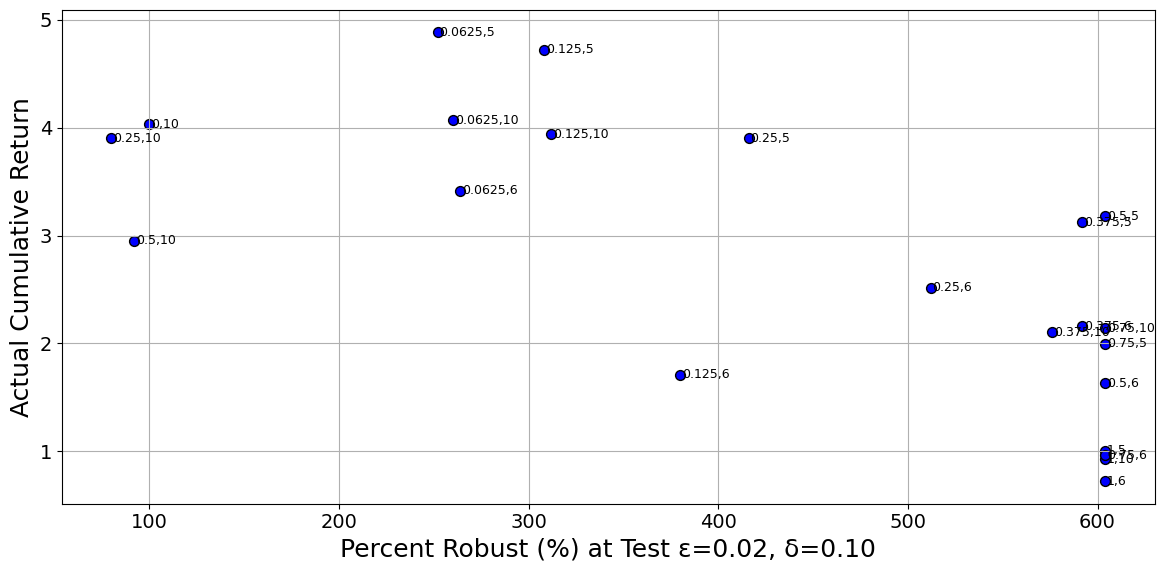

In [ ]:
df = pd.DataFrame(to_df)

# 1) Filter rows where eps == 0.02
df_eps_02 = df[df['eps'] == 0.1].copy()

# 2) Replace NaN in 'safe-incomplete' with zero so percentage calc is correct
df_eps_02['safe-incomplete'].fillna(0, inplace=True)

# 3) Compute percent_robust = (safe-incomplete / 25) * 100
df_eps_02['percent_robust'] = df_eps_02['safe-incomplete'] / 25 * 100

# 4) Plot percent_robust vs true
plt.figure(figsize=(12, 6))
plt.scatter(
    df_eps_02['percent_robust'],
    df_eps_02['true'],
    s=50,
    color='blue',
    edgecolor='k'
)
for i, row in df_eps_02.iterrows():
    plt.text(
        row['percent_robust'] + 1,
        row['true'],
        f"{row['model_path']}",
        fontsize=9,
        va='center'
    )
plt.xlabel('Percent Robust (%) at Test ε=0.02, δ=0.10')
plt.ylabel('Actual Cumulative Return')
# plt.title('Robustness vs. Clean P&L (Test ε=0.02, δ=0.10)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# df = pd.DataFrame(to_df)

# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns


# # 1) Replace NaNs with zero for counts
# df['safe-incomplete'].fillna(0, inplace=True)
# df['unsafe-pgd'].fillna(0, inplace=True)
# df['unknown'].fillna(0, inplace=True)

# # 2) Compute percentages out of total test samples (151)
# total = 25
# df['percent_robust'] = df['safe-incomplete'] / total * 100
# df['percent_non_robust'] = df['unsafe-pgd'] / total * 100

# # 3) Pivot into matrices (rows: train ε, cols: test ε)
# pivot_robust = df.pivot(index='eps', columns='model_path', values='percent_robust')
# pivot_non_robust = df.pivot(index='eps', columns='model_path', values='percent_non_robust')

# # 4) Sort both axes to ensure ascending order
# pivot_robust = pivot_robust.sort_index().sort_index(axis=1)
# pivot_non_robust = pivot_non_robust.sort_index().sort_index(axis=1)

# # 5) Plot side-by-side heatmaps
# # fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# # sns.heatmap(
# #     pivot_robust,
# #     ax=axes[0],
# #     annot=True,
# #     fmt=".0f",
# #     cmap="Greens",
# #     cbar=False,
# #     linewidths=0.5
# # )
# # axes[0].set_title("Percent Robust (\%)")
# # axes[0].set_xlabel("Test ε")
# # axes[0].set_ylabel("Train ε")

# # sns.heatmap(
# #     pivot_non_robust,
# #     ax=axes[1],
# #     annot=True,
# #     fmt=".0f",
# #     cmap="Reds",
# #     cbar=False,
# #     linewidths=0.5
# # )
# # axes[1].set_title("Percent Non‐Robust (\%)")
# # axes[1].set_xlabel("Test ε")
# # axes[1].set_ylabel("")  # omit repeated y-label

# # plt.tight_layout()
# # plt.show()


In [ ]:
pivot_robust

NameError: name 'pivot_robust' is not defined

/tmp/ipykernel_834323/1487388561.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['safe-incomplete'].fillna(0, inplace=True)


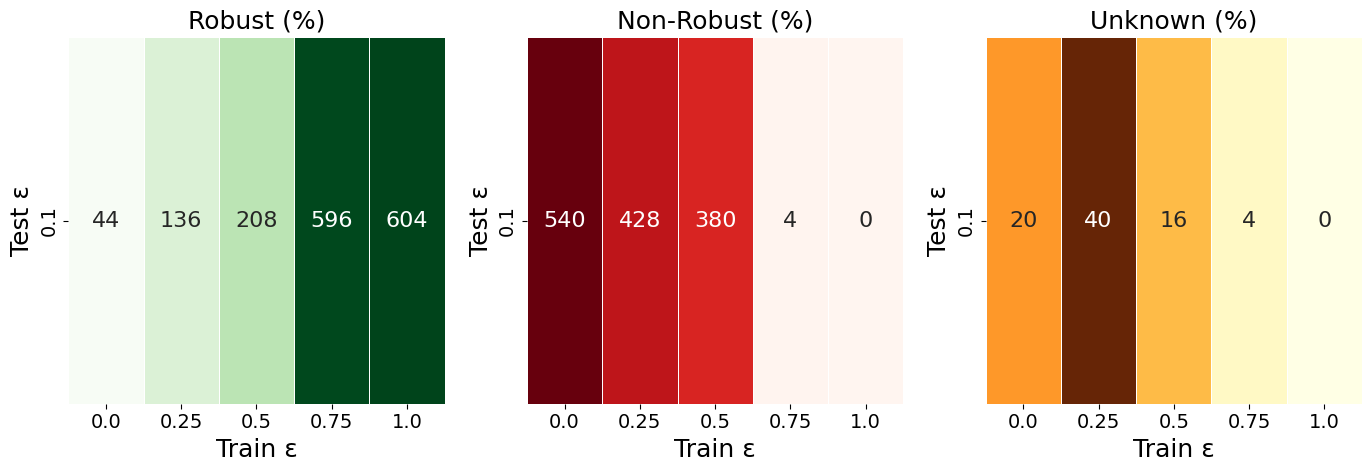

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.DataFrame(to_df)
# (Assume `df` is already defined and preprocessed as before)

# 1) Replace NaNs with zero for counts
df['safe-incomplete'].fillna(0, inplace=True)
df['unsafe-pgd'].fillna(0, inplace=True)
df['unknown'].fillna(0, inplace=True)

# 2) Compute percentages out of total test samples (151)
total = 25
df['percent_robust']     = df['safe-incomplete'] / total * 100
df['percent_non_robust'] = df['unsafe-pgd'] / total * 100
df['percent_unknown']    = df['unknown'] / total * 100

# 3) Pivot into matrices (rows: train ε, cols: test ε)
pivot_robust     = df.pivot(index='eps', columns='model_path', values='percent_robust')
pivot_non_robust = df.pivot(index='eps', columns='model_path', values='percent_non_robust')
pivot_unknown    = df.pivot(index='eps', columns='model_path', values='percent_unknown')

# 4) Sort both axes
pivot_robust     = pivot_robust.sort_index(ascending=False).sort_index(axis=1)
pivot_non_robust = pivot_non_robust.sort_index(ascending=False).sort_index(axis=1)
pivot_unknown    = pivot_unknown.sort_index(ascending=False).sort_index(axis=1)

# 5) Plot three narrower heatmaps side by side
#    Reduce figure width so each cell is less wide
fig, axes = plt.subplots(1, 3, figsize=(14, 5))  # narrower total width

for ax, (data, cmap, title) in zip(
    axes,
    [
        (pivot_robust,     "Greens",  "Robust (%)"),
        (pivot_non_robust, "Reds",    "Non‐Robust (%)"),
        (pivot_unknown,    "YlOrBr",  "Unknown (%)")
    ]
):
    sns.heatmap(
        data,
        ax=ax,
        annot=True,
        fmt=".0f",
        cmap=cmap,
        cbar=False,
        linewidths=0.5,
        square=False,         # allow rectangular cells
        xticklabels=True,
        yticklabels=True
    )
    ax.set_title(title)
    ax.set_xlabel("Train ε")
    ax.set_ylabel("Test ε")

plt.tight_layout()
plt.show()


In [ ]:
# 	model_path	eps	delta	cp	safe-incomplete	unsafe-pgd	unknown
# 0	standard	0.01	0.05	0.30	16.0	9	NaN
# 1	standard	0.01	0.10	-0.27	18.0	6	1.0
# 2	standard	0.01	0.20	-0.25	21.0	3	1.0
# 3	standard	0.01	0.30	0.00	24.0	0	1.0
# 4	standard	0.02	0.05	0.36	6.0	18	1.0
# 5	standard	0.02	0.10	0.62	13.0	9	3.0
# 6	standard	0.02	0.20	-0.29	16.0	8	1.0
# 7	standard	0.02	0.30	-0.49	16.0	6	3.0
# 8	standard	0.05	0.05	0.02	2.0	23	NaN
# 9	standard	0.05	0.10	0.90	2.0	20	3.0
# 10	standard	0.05	0.20	-0.33	5.0	16	4.0
# 11	standard	0.05	0.30	-0.37	6.0	15	4.0
# 12	standard	0.10	0.05	0.38	NaN	23	2.0
# 13	standard	0.10	0.10	-0.01	NaN	23	2.0
# 14	standard	0.10	0.20	1.03	NaN	21	4.0
# 15	standard	0.10	0.30	-0.48	1.0	19	5.0
# 16	robust	0.01	0.05	0.00	25.0	0	NaN
# 17	robust	0.01	0.10	0.00	25.0	0	NaN
# 18	robust	0.01	0.20	0.00	25.0	0	NaN
# 19	robust	0.01	0.30	0.00	25.0	0	NaN
# 20	robust	0.02	0.05	0.00	25.0	0	NaN
# 21	robust	0.02	0.10	0.00	25.0	0	NaN
# 22	robust	0.02	0.20	0.00	25.0	0	NaN
# 23	robust	0.02	0.30	0.00	25.0	0	NaN
# 24	robust	0.05	0.05	-0.03	18.0	7	NaN
# 25	robust	0.05	0.10	0.00	25.0	0	NaN
# 26	robust	0.05	0.20	0.00	25.0	0	NaN
# 27	robust	0.05	0.30	0.00	25.0	0	NaN
# 28	robust	0.10	0.05	-0.06	10.0	15	NaN
# 29	robust	0.10	0.10	-0.05	18.0	7	NaN
# 30	robust	0.10	0.20	0.00	25.0	0	NaN
# 31	robust	0.10	0.30	0.00	25.0	0	NaN


5
5


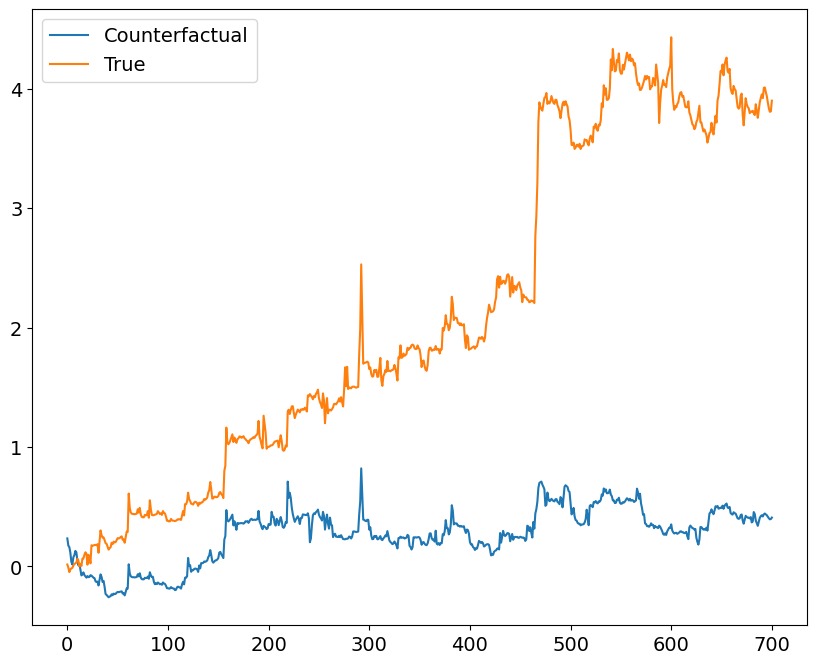

5
5


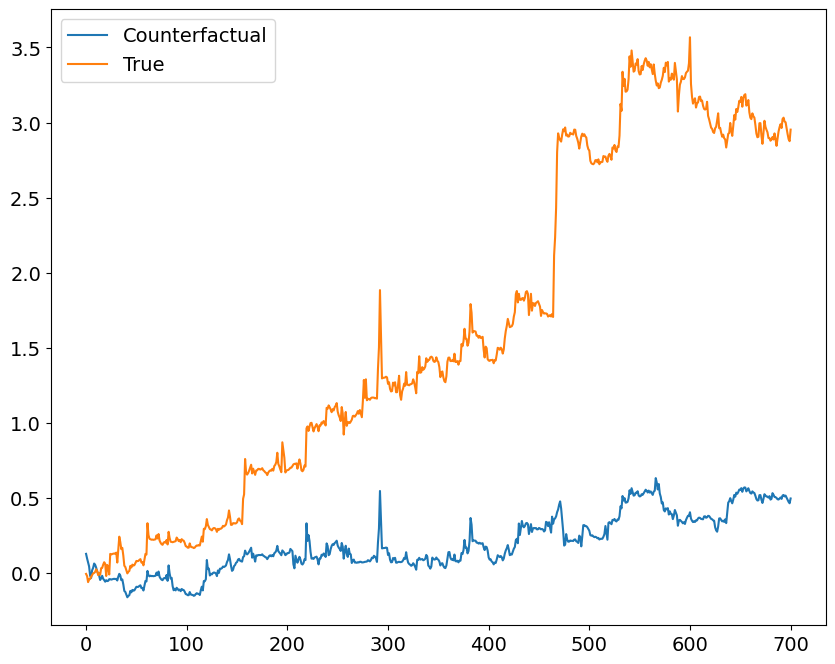

5
5


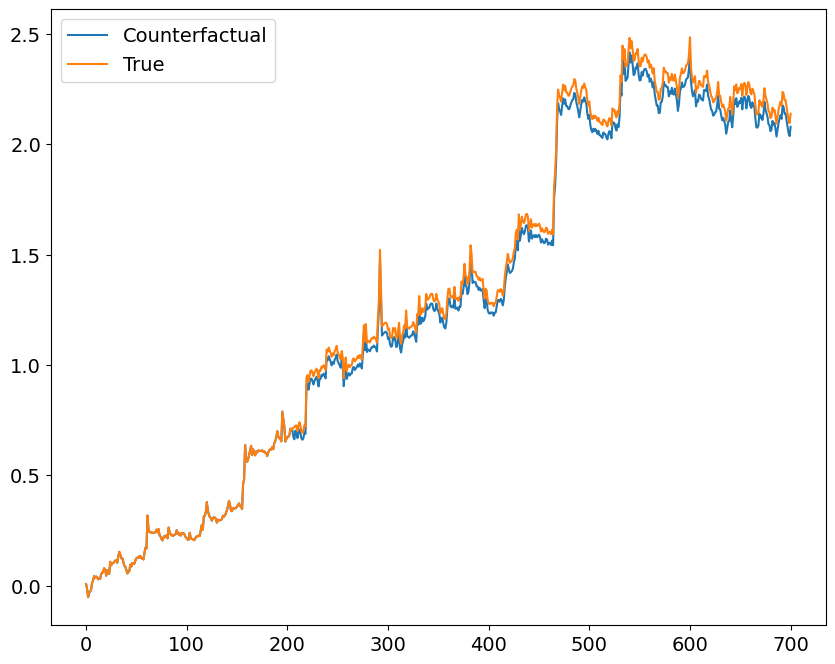

5
5


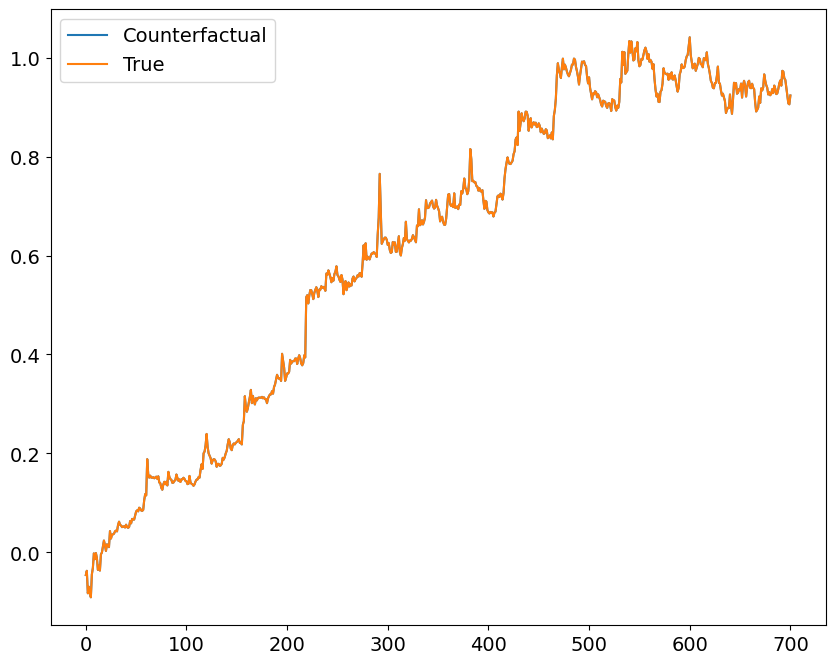

5
5


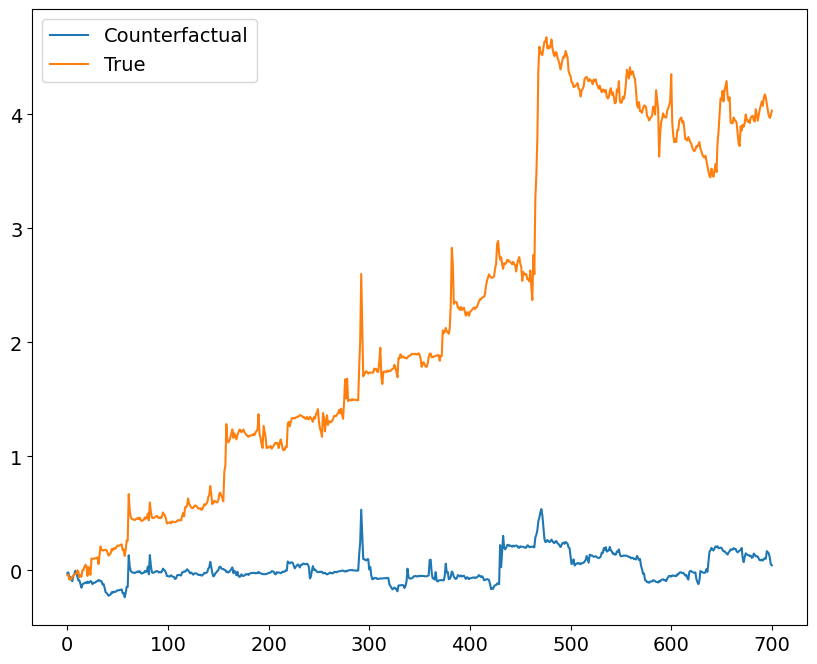

[{'model_path': 0.25,
  'eps': 0.1,
  'delta': 0.1,
  'cp': -0.9,
  'true': 3.901090145111084,
  'unsafe-pgd': 107,
  'safe-incomplete': 34,
  'unknown': 10},
 {'model_path': 0.5,
  'eps': 0.1,
  'delta': 0.1,
  'cp': -0.83,
  'true': 2.9529924392700195,
  'unsafe-pgd': 95,
  'unknown': 4,
  'safe-incomplete': 52},
 {'model_path': 0.75,
  'eps': 0.1,
  'delta': 0.1,
  'cp': -0.03,
  'true': 2.1381351947784424,
  'safe-incomplete': 149,
  'unsafe-pgd': 1,
  'unknown': 1},
 {'model_path': 1,
  'eps': 0.1,
  'delta': 0.1,
  'cp': 0.0,
  'true': 0.9236958026885986,
  'safe-incomplete': 151,
  'unsafe-pgd': 0},
 {'model_path': 0,
  'eps': 0.1,
  'delta': 0.1,
  'cp': -0.99,
  'true': 4.032696723937988,
  'unsafe-pgd': 135,
  'safe-incomplete': 11,
  'unknown': 5},
 {'model_path': 0.25,
  'eps': 0.1,
  'delta': 0.1,
  'cp': -0.9,
  'fake': 0.40864992141723633,
  'true': 3.901090145111084,
  'unsafe-pgd': 107,
  'safe-incomplete': 34,
  'unknown': 10},
 {'model_path': 0.5,
  'eps': 0.1,
  'de

In [ ]:
for model_path, model_path_dict in results.items():
    for eps, eps_dict in model_path_dict.items():
        for delta, delta_dict in eps_dict.items():

            if eps != 0.1 or delta != 0.1:
                continue

            # curr_result = results[model_path][eps][delta]


            # current_result = results[0.1][0.1]
            Xc_test_tensor = X_test_tensor.clone()
            c = 0

            # print(summary["results_data"]["summary"]["unsafe-pgd"])
            for i in range(0,Xc_test_tensor.shape[0], 5):
                if i // 5 in delta_dict["results_data"]["summary"]["unsafe-pgd"]:
                    avd = torch.tensor(delta_dict["cex_data"]["x"][c]).reshape(50,4)
                    c += 1
                    Xc_test_tensor[i] = avd

            # print(Xc_test_tensor)
            true_run = run_experiment(to_model[model_path], (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)
            fake_run = run_experiment(to_model[model_path], (Xc_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

            cp = round((fake_run["metrics"]["expected_return"] - true_run["metrics"]["expected_return"]) / true_run["metrics"]["expected_return"], 2)

            plt.figure(figsize=(10,8))
            plt.plot(fake_run["raw"]["cum_returns"], label="Counterfactual")
            plt.plot(true_run["raw"]["cum_returns"], label="True")
            plt.legend()
            plt.show()
                        
            


            summary_agg = {}
            if delta_dict["results_data"] is not None:
                summary = delta_dict["results_data"]["summary"]
                for k, v in summary.items():
                    summary_agg[k] = len(v)

            to_df.append({
                "model_path": namer[model_path],
                "eps": eps,
                "delta": delta,
                "cp": cp,
                "fake": fake_run["metrics"]["expected_return"],
                "true": true_run["metrics"]["expected_return"]
            } | summary_agg)

to_df

In [ ]:
current_result = results["alpha-beta-CROWN/complete_verifier/trained_models/seed=2,epochs=55,lambda_entropy=0.025,model=CNN,learning_rate=0.001,checkpoint_freq=10,rebalance_freq=5,jitter=0.03,checkpoint=20.pth"][0.1][0.2]
Xc_test_tensor = X_test_tensor.clone()
c = 0
for i in range(0,Xc_test_tensor.shape[0], 5):
    if i // 5 in current_result["results_data"]["summary"]["unsafe-pgd"]:
        avd = torch.tensor(current_result["cex_data"]["x"][c]).reshape(50,4)
        c += 1
        Xc_test_tensor[i] = avd
  

In [ ]:
model = standard_experiment["model"]

In [ ]:
# for model_name, experiment in Stan.items():

standard_experiment["results"]["fake"] = run_experiment(model, (Xc_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), standard_experiment)

In [ ]:
standard_experiment["results"]["fake"]["metrics"]["expected_return"]

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(standard_experiment["results"]["fake"]["raw"]["cum_returns"], label="Counterfactual")
plt.plot(standard_experiment["results"]["test"]["raw"]["cum_returns"], label="True")
plt.legend()
plt.show()

In [ ]:
# for dataset_key, dataset_idx in zip(["test", "fake"], [test_idx,test_idx]):
#     print("-"*20)
#     print(dataset_key.capitalize() + " RESULTS")
#     print("-"*20)
#     display_experiment_results(filtered_experiements_robust, dataset_key, dataset_idx )

In [ ]:
torch.tensor(results[0.1][0.1]["cex_data"]["x"][0]).reshape(50,4)-X_test_tensor[0]

In [ ]:
# Best results so far

# 	eps	delta	unsafe-pgd	unknown	safe-incomplete
# 0	0.005	0.05	45.0	34.0	72.0
# 1	0.005	0.10	9.0	12.0	130.0
# 2	0.005	0.20	NaN	1.0	150.0
# 3	0.005	0.30	NaN	NaN	151.0
# 4	0.010	0.05	72.0	75.0	4.0
# 5	0.010	0.10	45.0	70.0	36.0
# 6	0.010	0.20	8.0	50.0	93.0
# 7	0.010	0.30	NaN	32.0	119.0
# 8	0.020	0.05	125.0	26.0	NaN
# 9	0.020	0.10	76.0	75.0	NaN
# 10	0.020	0.20	NaN	NaN	NaN


In [ ]:
# 	eps	delta	unsafe-pgd	unknown	safe-incomplete
# 0	0.005	0.05	45.0	34.0	72.0
# 1	0.005	0.10	9.0	12.0	130.0
# 2	0.005	0.20	NaN	1.0	150.0
# 3	0.005	0.30	NaN	NaN	151.0
# 4	0.010	0.05	72.0	75.0	4.0
# 5	0.010	0.10	45.0	70.0	36.0
# 6	0.010	0.20	8.0	50.0	93.0
# 7	0.010	0.30	NaN	32.0	119.0
# 8	0.020	0.05	125.0	26.0	NaN

In [ ]:
# default_params = {
#     "config": "jamie.yaml",
#     "device": "cuda",
#     "start": "0",
#     "end": "64",
#     "conv_mode": "patches",
#     "load_model": model_path,
# }

# results = {}#20

# force_run = True


# for eps in [0.01]:
#     results[eps] = {}
#     for delta in tqdm([0.1, 0.5, 0.25, 0.01]):
#         path = model_path[:-4] + f"_e={eps}_d={delta}"
#         output_path = path + "_output.pkl"
#         results_path = path + "_results.txt" 
#         debug_path = path + "_debug.txt"  

#         print(debug_path)

#         if not os.path.isfile(output_path) or not os.path.isfile(results_path) or force_run:
#             print(f"No results found, running at {eps}, {delta}")
#             args = default_params | {
#                 "epsilon": eps,
#                 "delta": delta,
#                 "output_file": output_path,
#                 "results_file": results_path,
#             }
#             run_abcrown_from_dict_ipython(args, debug_path)

        
#         if os.path.isfile(output_path) and os.path.isfile(results_path):
#             print("loading results")
#             with open(output_path, "rb") as f:
#                 output_data = pickle.load(f)
#             with open(results_path, "rb") as f:
#                 results_data = pickle.load(f)   
#         else:
#             print("failed to load results")
#             output_data = None
#             results_data = None    

#         results[eps][delta] = {"results_data": results_data, "output_data": output_data}

In [ ]:
torch.tensor([0.1, 1, 2, 3, 5, 10]) * (saved_std/0.0128 * 0.041)[1]

In [ ]:
torch.tensor([0.1, 1, 2, 3, 5, 10]) *  0.041 /0.0128 #* (saved_std/ )[1]

In [ ]:
# to_df = []

# for eps, eps_dict in results.items():
#     for delta, delta_dict in eps_dict.items():
#         summary_agg = {}
#         if delta_dict["results_data"] is not None:
#             summary = delta_dict["results_data"]["summary"]
#             for k, v in summary.items():
#                 summary_agg[k] = len(v)

#         to_df.append({
#             "eps": eps,
#             "delta": delta,
#         } | summary_agg)

# pd.DataFrame(to_df)

In [ ]:
# 	eps	delta	unsafe-pgd	unknown	safe-incomplete
# 0	0.10	0.05	35.0	NaN	NaN
# 1	0.10	0.10	34.0	1.0	NaN
# 2	0.10	0.20	31.0	4.0	NaN
# 3	0.10	0.30	30.0	5.0	NaN
# 4	0.50	0.05	35.0	NaN	NaN
# 5	0.50	0.10	35.0	NaN	NaN
# 6	0.50	0.20	35.0	NaN	NaN
# 7	0.50	0.30	35.0	NaN	NaN
# 8	0.25	0.05	35.0	NaN	NaN
# 9	0.25	0.10	35.0	NaN	NaN
# 10	0.25	0.20	35.0	NaN	NaN
# 11	0.25	0.30	35.0	NaN	NaN
# 12	0.01	0.05	14.0	21.0	NaN
# 13	0.01	0.10	10.0	18.0	7.0
# 14	0.01	0.20	1.0	10.0	24.0
# 15	0.01	0.30	NaN	7.0	28.0


In [ ]:
%ls

In [ ]:
import torch
import re

# Replace with your actual filename
filename = "test_cex.txt"

# Read the entire file as text
with open(filename, "r") as f:
    text = f.read()

# Use regex to grab all X_i values (in order) and all Y_j values
# This pattern looks for "(X_<digits> <float>)"
x_matches = re.findall(r'\(X_\d+\s+([-+]?\d*\.\d+|\d+)\)', text)
y_matches = re.findall(r'\(Y_\d+\s+([-+]?\d*\.\d+|\d+)\)', text)

# Convert to floats
x_vals = [float(v) for v in x_matches]
y_vals = [float(v) for v in y_matches]

# Sanity check lengths
if len(x_vals) != 200:
    raise ValueError(f"Expected 200 X-values but found {len(x_vals)}")
if len(y_vals) != 4:
    raise ValueError(f"Expected 4 Y-values but found {len(y_vals)}")

# Create 1‐D tensors
X = torch.tensor(x_vals)   # shape: (200,)
Y = torch.tensor(y_vals)   # shape: (4,)

# Reshape X into (50, 4)
X = X.view(50, 4)

print("X shape:", X.shape)  # torch.Size([50, 4])
print("Y shape:", Y.shape)  # torch.Size([4])


In [ ]:
Y 

In [ ]:
X_np = X.numpy()
X_true = X_test_tensor[0].numpy()
# ---------------------------------------------------
# STEP 4: Plot each of the 4 columns of X
# ---------------------------------------------------
plt.figure()
for i in range(1):
    plt.plot(X_np[:, i], label=f"Column {i}")
    plt.plot(X_true[:, i], label=f"Column {i}")
    # plt.plot()

plt.xlabel("Row Index (0 to 49)")
plt.ylabel("X Value")
plt.title("Plot of X (shape 50×4)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# import subprocess

# def run_abcrown(epsilon, delta, model_path, config_file="jamie.yaml", device="cpu", start=0, end=5):
#     abcrown_cmd = [
#         "conda", "run", "-n", "abcrown3", "python",
#         "alpha-beta-CROWN/complete_verifier/abcrown.py",
#         "--config", str(config_file),
#         "--device", str(device),
#         "--epsilon", str(epsilon),
#         "--delta", str(delta),
#         "--start", str(start),
#         "--end", str(end),
#         "--load_model", str(model_path)
#     ]

#     result = subprocess.run(abcrown_cmd, capture_output=True, text=True)
#     print("STDOUT:\n", result.stdout)
#     print("STDERR:\n", result.stderr)
#     return result.returncode == 0
  

# # Example usage:
# # success = run_abcrown("config.yaml", "cuda", 0.1, 1e-5, 0, 100, "model.pth")
# # print("Run successful:", success)

# run_abcrown(0.01, 0.01, model_path)



In [ ]:
# # epsilon = 1e-6
# config_file = "jamie.yaml"
# # model_path = 

# !python alpha-beta-CROWN/complete_verifier/abcrown.py \
#     --config {config_file} \
#     --device {device} \
#     --epsilon {epsilon} 

In [ ]:
def hyperparam_search(experiments, metric="val_expected_return"):
    params_df = pd.DataFrame({k: v['params'] for k, v in experiments.items()}).T
    results_df = params_df
    for df_name in ["val", "test"]:
        df  = pd.DataFrame({k: v['results'][df_name]["metrics"] for k, v in experiments.items()}).T
        df = df.add_prefix(f'{df_name}_')
        results_df = pd.concat([results_df, df], axis=1)

    metric = "val_expected_return"
    params = params_df.columns 
    group_by_params = [p for p in params if p!= "seed"]
    agg_results_df = results_df.groupby(group_by_params)[metric].mean().reset_index().sort_values(metric, ascending=False).dropna().rename(columns={metric: f"mean_{metric}"})
    print("Hyperparam Search over seeds")
    display(agg_results_df)
    best_params = agg_results_df[group_by_params].iloc[0].to_dict()

    for col, val in best_params.items():
        results_df = results_df[results_df[col] == val]

    results_df = results_df.sort_values(metric, ascending=False)[params].iloc[0]
    return results_df.to_dict()


## MLP - Param Tuning

In [ ]:
params_grids = [{
    "seed": [1,2,3,4,5],
    "epochs": [50],
    "lambda_entropy": [0.025],#, 0.4],#, 0.0025],#[0.0001, 0.001, 0.01, 0.025, 0.05, 0.1],
    "model": ["MLP"],
    "learning_rate": [1e-3],
    "checkpoint_freq": [5],
    "rebalance_freq": [5],
    "jitter" : [1.5]
}
]

experiment_path = "fyp3/experiments/standard_model/"
experiments = get_experiment_model(standard_model_fn, experiment_path, params_grids, loss_fn_fn, dataset_fn)

for model_name, experiment in experiments.items():
    model = experiment["model"]
    experiment["results"]["val"] = run_experiment(model, (X_val_tensor, y_val_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

In [ ]:
best_params = best_MLP_params = hyperparam_search(experiments)
filtered_experiements = { ek: e for ek,e in experiments.items() if all([(best_params[pk] == e["params"][pk] or pk == "seed") for pk in best_params])}
display_train_results(filtered_experiements)
for dataset_key, dataset_idx in zip(["test", "val"], [test_idx,val_idx]):
    print("-"*20)
    print(dataset_key.capitalize() + " RESULTS")
    print("-"*20)
    display_experiment_results(filtered_experiements, dataset_key, dataset_idx )

## LSTM Hyperparameter tuning

In [ ]:
params_grids = [{
    "seed": [0, 20],
    "epochs": [100],
    "lambda_entropy": [0.025],
    "model": ["LSTM"],
    "lstm_layers" : [4],
    "lstm_hidden_layers": [1],
    "learning_rate": [1e-3],
    "rebalance_freq": [5],
    "checkpoint_freq": [8]
}
]

experiment_path = "fyp3/experiments/standard_model/"
experiments = get_experiment_model(standard_model_fn, experiment_path, params_grids, loss_fn_fn, dataset_fn)

for model_name, experiment in experiments.items():
    model = experiment["model"]
    experiment["results"]["val"] = run_experiment(model, (X_val_tensor, y_val_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

In [ ]:
best_params = best_lstm_params = hyperparam_search(experiments)
filtered_experiements = { ek: e for ek,e in experiments.items() if all([(best_params[pk] == e["params"][pk] or pk == "seed") for pk in best_params])}
display_train_results(filtered_experiements)
for dataset_key, dataset_idx in zip(["test", "val"], [test_idx,val_idx]):
    print("-"*20)
    print(dataset_key.capitalize() + " RESULTS")
    print("-"*20)
    display_experiment_results(filtered_experiements, dataset_key, dataset_idx )

## Transformer Hyperparameter tuning



In [ ]:
params_grids = [{
    "seed": [0, 1, 2],
    "epochs": [20],
    "lambda_entropy": [0.025],
    "model": ["Transformer"],
    "learning_rate": [1e-3],
    "rebalance_freq": [5],
    "checkpoint_freq": [3]
}
]

experiment_path = "fyp3/experiments/standard_model/"
experiments = get_experiment_model(standard_model_fn, experiment_path, params_grids, loss_fn_fn, dataset_fn)

for model_name, experiment in experiments.items():
    model = experiment["model"]
    experiment["results"]["val"] = run_experiment(model, (X_val_tensor, y_val_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

In [ ]:
best_params = best_transformer_params = hyperparam_search(experiments)
filtered_experiements = { ek: e for ek,e in experiments.items() if all([(best_params[pk] == e["params"][pk] or pk == "seed") for pk in best_params])}
display_train_results(filtered_experiements)
for dataset_key, dataset_idx in zip(["test", "val"], [test_idx,val_idx]):
    print("-"*20)
    print(dataset_key.capitalize() + " RESULTS")
    print("-"*20)
    display_experiment_results(filtered_experiements, dataset_key, dataset_idx )

## Comparison of models

In [ ]:
best_lstm_unrolled_params = {k: v for k,v in best_lstm_params.items()}
best_lstm_unrolled_params["model"] = "LSTM_Unrolled"
params_grids = [{k: [v] for k,v in ps.items()} for ps in [best_MLP_params, best_CNN_params, best_lstm_params, best_transformer_params, best_lstm_unrolled_params]]

experiment_path = "fyp3/experiments/standard_model/"
experiments = get_experiment_model(standard_model_fn, experiment_path, params_grids, loss_fn_fn, dataset_fn)

for model_name, experiment in experiments.items():
    model = experiment["model"]
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["val"] = run_experiment(model, (X_val_tensor, y_val_tensor[:, 0:1, :].squeeze(1)), experiment)


def custom_label_from_params(params, _):
    if params["model"] == "Transformer":
        return "Transformer"
    return params["model"].upper()

for dataset_key, dataset_idx in zip(["test", "val"], [test_idx, val_idx]):
    print("-"*20)
    print(dataset_key.capitalize() + " RESULTS")
    print("-"*20)
    display_experiment_results(experiments, dataset_key, dataset_idx)

# Standard Training - Robust Analysis 

In [ ]:
from auto_LiRPA import BoundedTensor, PerturbationLpNorm,BoundedModule

In [ ]:
def bound_model(model, x, eps, method, batch_size=1):
    upper_batches = []
    lower_batches = []
    x = x.to(device)
    N = x.shape[0]


    
    if method in ["a-CROWN", "b-CROWN", "ab-CROWN", "CROWN-Optimized"]:
        bound_args = model.bound_opts["optimize_bound_args"]
        bound_args["enable_alpha_crown"] = method in ["a-CROWN", "ab-CROWN"]
        bound_args["enable_beta_crown"] = method in ["b-CROWN", "ab-CROWN"]
        method = "CROWN-Optimized"
        # print(model.bound_opts)

    if method == "CROWN-Optimized":
        model.get_split_nodes()

    out_shape = (N, 4)

    for i in tqdm(range(0, N, batch_size)):
        x_batch = x[i: i+batch_size]
        eps_vector = torch.tensor(eps, dtype=torch.float32, device=device)  # One ε per asset
        eps_tensor = eps_vector.view(1, 1, -1).expand_as(x_batch) 

        perturbation = PerturbationLpNorm(norm=np.inf, eps=eps_tensor)
        x_perturbed = BoundedTensor(x_batch, perturbation)
        try:
            lb, ub = model.compute_bounds(x=(x_perturbed,), method=method)
            lb = lb.cpu()
            ub = ub.cpu()
        except Exception as e:
            print(e)
            lb, ub = torch.tensor([torch.nan]*4).unsqueeze(0), torch.tensor([torch.nan]*4).unsqueeze(0)
             
        lower_batches.append(lb)
        upper_batches.append(ub)

        # print(lb.shape)
    # print(lower_batches)

    lower_all = torch.cat(lower_batches, 0).nan_to_num(nan=0).clamp_min(0)
    upper_all = torch.cat(upper_batches, 0).nan_to_num(nan=1).clamp_max(1)

    return lower_all, upper_all

# torch.tensor([torch.nan]*4).unsqueeze(0).shape
# 

In [ ]:
def pgd_attack(model, x_init, y, eps, loss_fn, n_steps=20, step_size=0.1, device='cuda:0'):
    # 0/0
    model.eval()
    x0 = x_init.to(device)
    y0 = y.to(device)
    eps = eps.to(device) if torch.is_tensor(eps) else eps

    # start from the clean example, one tensor that always requires grad
    adv = x0.clone().detach().requires_grad_(True)
    best_loss = torch.full((x0.size(0),), -float('inf'), device=device)
    with torch.enable_grad():
        for _ in range(n_steps):
            # zero the gradient from the previous step
            if adv.grad is not None:
                adv.grad.zero_()
            # forward + objective (we do -loss because we want the *worst* point)
            logits = model(adv)
            obj = -loss_fn(logits, y0)            # this must be a Tensor, not a float

            # keep the best‐so‐far point per example
            mask = (obj >= best_loss).view(-1, *([1] * (adv.dim()-1)))
            best_loss = torch.where(obj >= best_loss, obj.detach(), best_loss)
            # you can store best‐so‐far inputs if needed, same pattern

            # compute gradient w.r.t. adv
            obj.sum().backward()                  # builds d(obj)/d(adv)
            # PGD step: modify adv.data in‐place, then clamp
            adv.data = (adv.data + step_size * adv.grad.data.sign())
            adv.data = adv.data.clamp(x0 - eps, x0 + eps)

    # at the end, adv contains your adversarial examples
    return adv.detach()

def pgd_attack_loss(x, y):
    loss = ((1 + y).prod(1) * x).sum(1)
    return loss

In [ ]:
def get_bounded_model(experiment):
    model_type = experiment["params"]["model"]
    model = experiment["model"]

    model = model.to(device)

    beta_crown_args = {
                "enable_alpha_crown": True,   # α-CROWN
                "enable_beta_crown": True,    # β-CROWN (branch-and-bound)
                "optimizer": "adam",          
                "iteration": 5,              # α/β optimization steps
                "lr_alpha": 0.5,
                "lr_beta": 0.05,
                "pruning_in_iteration": True
            }
    if model_type == "MLP" or model_type == "LSTM":
        bound_opts = {
                "optimize_bound_args": beta_crown_args,
        }
    else:
        bound_opts = {
                "optimize_bound_args": beta_crown_args,
                "conv_mode": "matrix"
            }
    return BoundedModule(model, X_train_tensor, bound_opts=bound_opts)

In [ ]:
def pgd_attack_experiments(experiments, x, y, test_eps, loss_fn=pgd_attack_loss):
    for model_name, experiment in experiments.items():
        if "epochs" not in experiment["params"]:
            continue
        model = experiment["model"]

        experiment["results"]["test"]["PGD"] = {}
        experiment["results"]["test"]["PGD_AdvX"]  = {}
        experiment["results"]["test"]["PGD_AdvY"]  = {}
        for eps in test_eps:
            attack_point = pgd_attack(model, x, y, eps, loss_fn)
            experiment["results"]["test"]["PGD_AdvX"][eps] = attack_point.cpu()
            experiment["results"]["test"]["PGD_AdvY"][eps] = model(attack_point).cpu()

In [ ]:
def deltas_experiments(experiments):
    for model_name, experiment in experiments.items():
        returns = experiment["results"]["test"]["returns"] 
        deltas = experiment["results"]["test"]["deltas"] = {}
        model_returns = returns["None"]

        for method, return_dict in returns.items():
            if method == "None":
                continue
            deltas[method] = {}
            for eps, ret in return_dict.items():
                deltas[method][eps] = ((ret + 1) -(model_returns+1))/ (model_returns+1)  


In [ ]:
def get_experiment_returns(experiments, y):
    for model_name, experiment in experiments.items():
        # model = experiment["model"]

        model_weights = experiment["results"]["test"]["bounds"]["None"]
        returns = experiment["results"]["test"]["returns"] = {}
        asset_returns = (y+1).prod(1)-1

        returns["None"] = (asset_returns * model_weights).sum(1)#.cpu()

        for method in experiment["results"]["test"]["bounds"].keys():


            if method == "PGD" or method =="None": #TODO delete
                continue

            # print(method)

            returns[method] = {}
            for eps, bounds in experiment["results"]["test"]["bounds"][method].items():
                ub, lb = bounds
                # print(lb.shape, asset_returns.shape)
                returns[method][eps] = torch.min(asset_returns * lb, asset_returns * ub).sum(1)#.cpu()

        if "epochs" not in experiment["params"]:
            continue

        returns["PGD"] = {}

        for eps, weights in experiment["results"]["test"]["PGD_AdvY"].items():
            returns["PGD"][eps] = (asset_returns * weights).sum(1)#cpu()
            # print(returns["PGD"][eps])
# get_experiment_returns(exps, y)

In [ ]:
def bound_experiments(experiments, methods, x, test_eps):
    for model_name, experiment in experiments.items():
        model = experiment["bounded_model"]
        
        if "bounds" not in experiment["results"]["test"]:
            experiment["results"]["test"]["bounds"] = {}
        experiment["results"]["test"]["bounds"]["None"] = model(x.to(device)).cpu()
        
        for method in methods:
            experiment["results"]["test"]["bounds"][method] = {}
            for eps in test_eps:
                experiment["results"]["test"]["bounds"][method][eps] = bound_model(model, x, eps, method, batch_size=1)

# bound_experiments({"mlp": mlp}, ["IBP"], x[:5], [0.001])

## Adversarial Attacks

In [ ]:
mlp = experiments["seed=0,epochs=30,lambda_entropy=0.001,model=MLP,learning_rate=0.001,checkpoint_freq=3,rebalance_freq=5,checkpoint=3.pth"]
cnn = experiments["seed=0,epochs=30,lambda_entropy=0.0025,model=CNN,learning_rate=0.001,checkpoint_freq=10,rebalance_freq=5,checkpoint=10.pth"]
LSTM_Unrolled = experiments["seed=0,epochs=100,lambda_entropy=0.025,model=LSTM_Unrolled,lstm_layers=4,lstm_hidden_layers=1,learning_rate=0.001,rebalance_freq=5,checkpoint_freq=8,checkpoint=64.pth"]
transformer = experiments["seed=0,epochs=20,lambda_entropy=0.025,model=Transformer,learning_rate=0.001,rebalance_freq=5,checkpoint_freq=3,checkpoint=15.pth"]
lstm = experiments["seed=0,epochs=100,lambda_entropy=0.025,model=LSTM,lstm_layers=4,lstm_hidden_layers=1,learning_rate=0.001,rebalance_freq=5,checkpoint_freq=8,checkpoint=64.pth"]

exps = {"MLP": mlp, "CNN": cnn, "Transformer": transformer, "LSTM": LSTM_Unrolled}

In [ ]:
for model_name, model in exps.items():
    model["bounded_model"] = get_bounded_model(model)

In [ ]:
test_eps = [0.05]
x = X_test_tensor[::horizon]
y = y_test_tensor[::horizon]
pgd_attack_experiments(exps, x, y, test_eps)
bound_experiments(exps, [], x, [])
get_experiment_returns(exps, y)
deltas_experiments(exps)

In [ ]:
model_names = ["CNN"]
for model_name in model_names:
    first = exps[model_names[0]]["results"]["test"]["deltas"]["PGD"]
    thresholds = sorted(first.keys())
    for eps in test_eps:
        deltas = exps[model_name]["results"]["test"]["deltas"]["PGD"][eps]
        returns = exps[model_name]["results"]["test"]["returns"]


        model_returns = returns["None"]
        pgd_returns = returns["PGD"][eps]

        model = exps[model_name]["model"]

        mask_pos_in_a = model_returns > 0.04       # True where 'a' is positive
        mask_neg_in_b = pgd_returns < 0       # True where 'b' is negative

        # 2) Combine them: only indices where BOTH are True
        combined_mask = mask_pos_in_a & mask_neg_in_b

        # 3) Extract the integer indices where combined_mask is True
        #    torch.nonzero(...) returns a tensor of shape (N, 1) for a 1D mask, so we .flatten() or .squeeze().
        intersection_idx = torch.nonzero(combined_mask)
        # print(intersection_idx)
        # print(model_returns[:5])
        # print(pgd_returns)
        # print(pgd_returns[:5])
        # print(deltas[intersection_idx])
        # 0/0
        


      

        # print(deltas[intersection_idx])

        test = deltas[intersection_idx]
        

        # print(torch.argmin(test))


        min_idx = torch.argmin(pgd_returns[intersection_idx])
        min_idx = intersection_idx[min_idx].cpu().detach().numpy()[0]
        # print(min_idx)
        # print(deltas[min_idx])
        print("Clean return", returns["None"][min_idx].cpu().detach().numpy())
        print("Adversarial return", returns["PGD"][eps][min_idx].cpu().detach().numpy())

    
        adv_X = exps[model_name]["results"]["test"]["PGD_AdvX"][eps]

        

        
        adv_Y = exps[model_name]["results"]["test"]["PGD_AdvY"][eps]
        deltas = exps[model_name]["results"]["test"]["deltas"]["PGD"][eps]

        model_weights = exps[model_name]["results"]["test"]["bounds"]["None"]

        data_np = X_test_tensor[::5][min_idx].numpy()
        data_np2 = adv_X[min_idx].cpu().numpy()

        time = range(data_np.shape[0])  # 0,1,…,49

        # Create a 2×2 grid of subplots
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), sharex=True)

        # Flatten the axes array for easy iteration
        axes = axes.flatten()

        for i, ax in enumerate(axes):

            print(data_np[:, i].shape)
            ax.plot(time, torch.tensor(data_np[:, i]) * saved_std[i] + saved_mean[i],  linestyle='-')
            ax.plot(time, torch.tensor(data_np2[:, i]) * saved_std[i] + saved_mean[i], linestyle='--')
            ax.set_title(f'{asset_names[i]}')
            ax.set_ylabel('Value')
            ax.grid(True, linestyle='--', alpha=0.5)

        # Label the shared x-axis on the bottom row
        for ax in axes[2:]:
            ax.set_xlabel('Time')

        # fig.suptitle(f'Tensor Data over Time (2×2 Grid) {label_from_params(eps[model_name]["params"], exps)} {eps}', y=0.95)
        plt.tight_layout()
        plt.show()


        weights_clean = model(X_test_tensor[::5][min_idx].to(device).unsqueeze(0)).cpu().detach().numpy().squeeze(0)
        weights_adv   = model(adv_X[min_idx].to(device).unsqueeze(0)).cpu().detach().numpy().squeeze(0)

        # X-axis positions for the two scenarios
        x = np.arange(2)

        # Compute cumulative bottoms for stacking
        bottom_idx0 = np.zeros(2)
        bottom_idx1 = np.zeros(2)
        bottom_idx2 = np.zeros(2)

        # Plot stacked bar chart
        plt.figure(figsize=(6, 5))

        # Index 0
        plt.bar(x,
                [weights_clean[0], weights_adv[0]],
                label=asset_names[0])

        # Index 1 on top of Index 0
        bottom_idx0 = [weights_clean[0], weights_adv[0]]
        plt.bar(x,
                [weights_clean[1], weights_adv[1]],
                bottom=bottom_idx0,
                label=asset_names[1])

        # Index 2 on top of Index 0 + Index 1
        bottom_idx1 = [weights_clean[0] + weights_clean[1],
                    weights_adv[0]   + weights_adv[1]]
        plt.bar(x,
                [weights_clean[2], weights_adv[2]],
                bottom=bottom_idx1,
                label=asset_names[2])

        # Index 3 on top of Index 0 + Index 1 + Index 2
        bottom_idx2 = [weights_clean[0] + weights_clean[1] + weights_clean[2],
                    weights_adv[0]   + weights_adv[1]   + weights_adv[2]]
        plt.bar(x,
                [weights_clean[3], weights_adv[3]],
                bottom=bottom_idx2,
                label=asset_names[3])

        # Labels, ticks, title, and legend
        plt.xticks(x, ['Clean Output', 'Adversarial Output'])
        plt.xlabel('Output Type')
        plt.ylabel('Weight Value')
        plt.title('Stacked Bar Plot: Clean vs. Adversarial Weights')
        plt.legend(title='Weight Index')
        plt.tight_layout()
        plt.show()

        

In [ ]:
exps = {"MLP": mlp, "CNN": cnn, "Transformer": transformer, "LSTM": LSTM_Unrolled}
# exps = {"LSTM": }
test_eps = [0.05, 0.01, 0.25, 0.1]
test_delta = [0.01, 0.025, 0.05, 0.1]
x = X_test_tensor[::horizon]
y = y_test_tensor[::horizon]
pgd_attack_experiments(exps, x, y, test_eps)
bound_experiments(exps, [], x, [])
get_experiment_returns(exps, y)
deltas_experiments(exps)

def find_counterexamples(exps, test_delta):
    counterexamples = []
    for model_name, model in exps.items():
        for e in test_eps:
            for d in test_delta:
                true_deltas = model["results"]["test"]["deltas"]["PGD"][e]
                num_counterexamples = torch.abs(true_deltas) > d
                num_examples = num_counterexamples.shape[0]
                counterexamples.append({
                    "model": model_name,
                    "epsilon": e,
                    "delta": d,
                    "counterexamples": round((float((sum(num_counterexamples)/ num_examples).cpu().detach().numpy())),2)
                })

    counterexamples_df = pd.DataFrame(counterexamples)  

    counterexamples_df = counterexamples_df.pivot(index=["epsilon", 'delta'], columns='model', values='counterexamples')
    counterexamples_df = counterexamples_df.reset_index()
    counterexamples_df.columns.name = None
    counterexamples_df

    return counterexamples_df

PGD_results_table = find_counterexamples(exps, test_delta)
print("PGD Results table")
display(PGD_results_table)

test_delta_graph = np.array(list(range(31)))/100

PGD_results_graph = find_counterexamples(exps, test_delta_graph)

for eps, df_eps in PGD_results_graph.groupby("epsilon"):
    plt.figure(figsize=(12, 8))
    for model in exps.keys():
        plt.plot(df_eps["delta"], df_eps[model], label=model)
    plt.xlabel("Test δ")
    plt.ylabel("% Counterexample")
    plt.title(f"% known adversarial examples with a reduction in returns worse than test δ for ε={eps}")
    plt.grid(True)
    plt.legend()
    plt.show()

## Verified bounds

In [ ]:
def get_robust(deltas, exps):
    robust = []
  


    for model_name, model in exps.items():

        # print(model_name)
        # print(model["results"]["test"]["deltas"])

        for method_name, method in model["results"]["test"]["deltas"].items():
            # print(method_name)
            if method_name in ["PGD", "None"]:
                continue

            # print(method)
            
            for eps, true_deltas in method.items():
                # for e in test_eps:
                    # true_deltas = model["results"]["test"]["deltas"][method][e]
                for d in deltas:
                    num_counterexamples = torch.abs(true_deltas) <= d
                    num_examples = num_counterexamples.shape[0]
                    robust.append({
                        "model": model_name,
                        "method": method_name,
                        "epsilon": eps,
                        "delta": d,
                        "robust": round((float((sum(num_counterexamples)/ num_examples).cpu().detach().numpy())),2)
                    })
    return robust

# pd.DataFrame(get_robust(table_test_delta, exps))  


### IBP

In [ ]:
x = X_test_tensor[::horizon][:30]
y = y_test_tensor[::horizon][:30]

In [ ]:
test_eps = [0.001, 0.005, 0.01]
exps = {"MLP": mlp, "CNN": cnn, "Transformer": transformer, "LSTM": LSTM_Unrolled}
methods = ["IBP"]
pgd_attack_experiments(exps, x, y, test_eps)
bound_experiments(exps, methods, x, test_eps)
get_experiment_returns(exps, y)
deltas_experiments(exps)

In [ ]:
table_test_delta = [0.01, 0.025, 0.05, 0.1]

df = pd.DataFrame(get_robust(table_test_delta, exps))  
df = df[df["method"] == "IBP"]
df = df.pivot(index=["epsilon", 'delta'], columns='model', values='robust')
df = df.reset_index()
df.columns.name = None
df

In [ ]:
graph_test_delta = np.array(list(range(31)))/100
df = pd.DataFrame(get_robust(graph_test_delta, exps))
method = "IBP"
df = df[df["method"] == method]
for eps, df_eps in df.groupby("epsilon"):
    # for method, df_eps_method in df_eps.groupby("method"):
    plt.figure()
    for model_name, df_model in df_eps.groupby("model"):
        plt.plot(df_model["delta"], df_model["robust"], label=model_name)
    plt.xlabel("Test δ")
    plt.ylabel("% Certified Robust")
    plt.title(f"Certified Robustness under {method} of models tested at ε={eps}")
    plt.grid(True)
    plt.legend()
    plt.show()

### CROWN

In [ ]:
test_eps = [0.01, 0.025, 0.05, 0.1]
exps = {"MLP": mlp, "CNN": cnn} #"LSTM TODO"#, "Transformer": transformer, "LSTM": LSTM_Unrolled}
methods = ["CROWN"]
pgd_attack_experiments(exps, x, y, test_eps)
bound_experiments(exps, methods, x, test_eps)
get_experiment_returns(exps, y)
deltas_experiments(exps)

In [ ]:
table_test_delta = [0.01, 0.025, 0.05, 0.1]
df = pd.DataFrame(get_robust(table_test_delta, {"MLP": mlp, "CNN": cnn}))  
df = df[df["method"] == "CROWN"]
df = df.pivot(index=["epsilon", 'delta'], columns='model', values='robust')
df = df.reset_index()
df.columns.name = None
df

In [ ]:
graph_test_delta = np.array(list(range(31)))/100
df = pd.DataFrame(get_robust(graph_test_delta, exps))

method = "CROWN"
df = df[df["method"] == method]

for eps, df_eps in df.groupby("epsilon"):
    # for method, df_eps_method in df_eps.groupby("method"):
    plt.figure()
    for model_name, df_model in df_eps.groupby("model"):
        plt.plot(df_model["delta"], df_model["robust"], label=model_name)
    plt.xlabel("Test δ")
    plt.ylabel("% Certified Robust")
    plt.title(f"Certified Robustness under {method} of models tested at ε={eps}")
    plt.grid(True)
    plt.legend()
    plt.show()

### ab-CROWN

In [ ]:
test_eps = [0.01, 0.025, 0.05, 0.1]
exps =  {"MLP": mlp, "CNN": cnn}
methods = ["ab-CROWN"]
pgd_attack_experiments(exps, x, y, test_eps)
# bound_experiments(exps, methods, x, test_eps)
get_experiment_returns(exps, y)
deltas_experiments(exps)

In [ ]:
table_test_delta = [0.01, 0.025, 0.05, 0.1]
df = pd.DataFrame(get_robust(table_test_delta, exps))  
df = df[df["method"] == "ab-CROWN"]
df = df.pivot(index=["epsilon", 'delta'], columns='model', values='robust')
df = df.reset_index()
df.columns.name = None
df

In [ ]:
graph_test_delta = np.array(list(range(61)))/240
df = pd.DataFrame(get_robust(graph_test_delta, exps))
method = "ab-CROWN"
df = df[df["method"] == method]

for eps, df_eps in df.groupby("epsilon"):
    # for method, df_eps_method in df_eps.groupby("method"):
    plt.figure(figsize=(10,6))
    for model_name, df_model in df_eps.groupby("model"):
        plt.plot(df_model["delta"], df_model["robust"], label=model_name)
    plt.xlabel("Test δ")
    plt.ylabel("% Certified Robust")
    plt.title(f"Certified Robustness under α,β-CROWN of models tested at ε={eps}")
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
# df_tables = pd.DataFrame(get_robust(table_test_delta))  
# for method_name, df_table in df_tables.groupby("method"):
#     display(df_table)

In [ ]:
# graph_test_delta = np.array(list(range(31)))/100
# df_graphs = pd.DataFrame(get_robust(graph_test_delta))

# for eps, df_eps in df_graphs.groupby("epsilon"):
#     for method, df_eps_method in df_eps.groupby("method"):
#         plt.figure()
#         for model_name, df_model in df_eps_method.groupby("model"):
#             plt.plot(df_model["delta"], df_model["robust"], label=model_name)
#         plt.xlabel("test_delta")
#         plt.ylabel("% Certified Robust")
#         plt.title(f"{method} {eps}")
#         plt.grid(True)
#         plt.legend()
#         plt.show()

## Runtime Analysis

In [ ]:
import time as time

In [ ]:
N = 1

exps = {"MLP": mlp, "CNN": cnn, "Transformer": transformer, "LSTM": LSTM_Unrolled}


bound_performance_path = os.path.join(experiment_path, "bound_performance8.csv")
os.makedirs(os.path.dirname(bound_performance_path), exist_ok=True)
if os.path.exists(bound_performance_path):
    with open(bound_performance_path, 'r') as file:
        bound_performance = json.load(file)
else:
    bound_performance = {}

methods = ["IBP", "PGD", "CROWN-IBP", "CROWN", "ab-CROWN"]
skip = {
    "MLP": [],
    "CNN": [],
    "Transformer": methods,#["CROWN", "CROWN-IBP", "ab-CROWN"],
    "LSTM": methods#["ab-CROWN", "CROWN"],

}


for N in [1]:
    x = X_test_tensor[:N]
    y = y_test_tensor[:N]
    N = str(N)
    if N not in bound_performance :
        bound_performance[N] = {}
    for method in methods:
        if method not in bound_performance[N] :
            bound_performance[N][method] = {}
        for model_name, model_dict in exps.items():
            if model_name in bound_performance[N][method]:
                print(f"Already tested {model_name} {method} {N}")
                continue 

            if method in skip[model_name]:
                print(f"Skipping {model_name} {method} {N}")
                continue 

            
            if ("model_bounded" not in model_dict):
                print(f"Loading bounded model for {model_name}")
                model_dict["model_bounded"] = get_bounded_model(model_dict)
            bounded_model = model_dict["model_bounded"]
            
            bounds = None
            start_time = time.time()
            if method == "PGD":
                pgd_attack(bounded_model, x.to(device), y.to(device), 0.1, pgd_attack_loss, step_size=20, device=device)
            else:
                bounds = bound_model(bounded_model, x.to(device), 0.1, method)
            time_taken = time.time() - start_time
            print(f"{model_name} {method} {N} - {time_taken}")
            mean_width = None
            if bounds is not None:     
                mean_width = torch.mean(torch.abs(bounds[1] - bounds[0]))
            bound_performance[N][method][model_name] = {"time_taken": time_taken, "mean_width": mean_width}


            print(bound_performance)
            # print(bound_performance[N][method][model_name])
            with open(bound_performance_path, 'w') as file: 
                json.dump(bound_performance, file, indent=4)

In [ ]:
import pandas as pd


# Convert to DataFrame
rows = []
for run, methods in bound_performance.items():
    for method, models in methods.items():
        for model, value in models.items():
            rows.append({
                'N': int(run),
                'method': method,
                'model': model,
                'value': value*100 / int(run)
            })

df = pd.DataFrame(rows)
df = df[df["N"] == 8]
# Aggregate value over runs (compute mean)
# agg_df = df.groupby(['method', 'model'], as_index=False)['value'].mean()

# Pivot so that 'model' remains rows and 'method' become columns
df =  df.pivot(index=['model',"N"], columns='method', values='value').reset_index()

df

In [ ]:
import pandas as pd


# Convert to DataFrame
rows = []
for run, methods in bound_performance.items():
    for method, models in methods.items():
        for model, value in models.items():
            rows.append({
                'run#': int(run),
                'method': method,
                'model': model,
                'value': value
            })

df = pd.DataFrame(rows)

# Aggregate value over runs (compute mean)
agg_df = df.groupby(['method', 'model'], as_index=False)['value'].mean()

# Pivot so that 'model' remains rows and 'method' become columns
pivot_df = agg_df.pivot(index='model', columns='method', values='value').reset_index()

pivot_df

In [ ]:
bounds_dict = []
for model_name, model in exps.items():
    for method in model["results"]["test"]["deltas"].keys():
        if method in ["PGD", "None"]:
            continue
        for e in model["results"]["test"]["deltas"][method].keys():
            true_deltas = model["results"]["test"]["deltas"][method][e]
            bounds = model["results"]["test"]["bounds"][method][e]

            mean_bound_width = torch.mean(torch.abs(bounds[1] - bounds[0]))
            mean_delta = torch.mean(true_deltas)

            bounds_dict.append({
                    "model": model_name,
                    "method": method,
                    "epsilon": e,
                    "mean_bound_width": round(float(mean_bound_width.cpu()),2),
                    "mean_delta": round(float(mean_delta.cpu()),2),
                })
print("Mean bound width. Mean delta")
df = pd.DataFrame(bounds_dict)  
display(df)

In [ ]:
exp = {"ml"}

In [ ]:
import time

In [ ]:
exp = experiments["seed=0,epochs=30,lambda_entropy=0.001,model=MLP,learning_rate=0.001,checkpoint_freq=3,rebalance_freq=5,checkpoint=3.pth"]
exp2 = experiments["seed=0,epochs=30,lambda_entropy=0.0025,model=CNN,learning_rate=0.001,checkpoint_freq=10,rebalance_freq=5,checkpoint=10.pth"]
exp3 = experiments["seed=0,epochs=100,lambda_entropy=0.025,model=LSTM_Unrolled,lstm_layers=4,lstm_hidden_layers=1,learning_rate=0.001,rebalance_freq=5,checkpoint_freq=8,checkpoint=64.pth"]
# device = "cpu"
bound_performance_path = os.path.join(experiment_path, "bound_performance.csv")
os.makedirs(os.path.dirname(bound_performance_path), exist_ok=True)
if os.path.exists(bound_performance_path):
    with open(bound_performance_path, 'r') as file:
        bound_performance = json.load(file)
else:
    bound_performance = {}

eps = {"mlp": exp, "cnn": exp2, "lstm": exp3}

for run in range(3):
    run = str(run)
    if run not in bound_performance:
        bound_performance[run] = {}
    for method in ["IBP", "PGD", "CROWN-IBP", "CROWN"]:
        if method not in bound_performance[run] :
            bound_performance[run][method] = {}
        for model_name, model_dict in eps.items():
            if model_name in bound_performance[run][method]:
                print(f"Already tested {model_name} {method} {run}")
                continue 
            
            if ("model_bounded" not in model_dict):
                print(f"Loading bounded model for {model_name}")
                model_dict["model_bounded"] = get_bounded_model(model_dict)
            bounded_model = model_dict["model_bounded"]

            start_time = time.time()
            if method == "PGD":
                pgd_attack(bounded_model, X_test_tensor[::horizon].to(device), y_test_tensor[::horizon].to(device), 0.1, pgd_attack_loss, step_size=20, device=device)
            else:
                bound_model(bounded_model, X_test_tensor[::horizon].to(device), 0.1, method)
            time_taken = time.time() - start_time
            print(f"{model_name} {method} {run} - {time_taken}")

            bound_performance[run][method][model_name] = time_taken
            with open(bound_performance_path, 'w') as file: 
                json.dump(bound_performance, file, indent=4)


In [ ]:
import pandas as pd


# Convert to DataFrame
rows = []
for run, methods in bound_performance.items():
    for method, models in methods.items():
        for model, value in models.items():
            rows.append({
                'run#': int(run),
                'method': method,
                'model': model,
                'value': value
            })

df = pd.DataFrame(rows)

# Aggregate value over runs (compute mean)
agg_df = df.groupby(['method', 'model'], as_index=False)['value'].mean()

# Pivot so that 'model' remains rows and 'method' become columns
pivot_df = agg_df.pivot(index='model', columns='method', values='value').reset_index()

pivot_df

In [ ]:
# def loss_fn_fn(params):
#     lambda_entropy = params["lambda_entropy"]
#     def loss_fn(x, y, model):
#         weights = model(x)

#         asset_returns = ((1 + y).prod(1)-1)
#         portfolio_returns = (asset_returns*weights).sum(1)
#         natural_loss = -portfolio_returns.mean() 
#         clamped_weights = weights.clamp(min=1e-8)
#         entropy_loss = lambda_entropy * (-(clamped_weights * clamped_weights.log()).sum(dim=1).mean())
#         return natural_loss -  entropy_loss
#     return loss_fn 
    
# def model_fn(params):
#     if params["model"] == "CNN":
#         model = CNNAllocatorCausal(4, lookback, dropout_rate=params["dropout"]).to(device)
#     else:
#         model = SimpleAssetAllocationModel(4*lookback)

#     return model

# params_grids = [{
#     "seed": [0],
#     "epochs": [10, 20, 30],
#     "lambda_entropy": [1e-4, 1e-3, 1e-2, 0.05, 0.1],
#     "model": ["CNN"],
#     "dropout": [0.1],
#     "learning_rate": [1e-3],
#     "rebalance_freq": [5],
# },
# ]

# experiment_path = "fyp3/experiments/standard_model/"
# experiments = get_experiment_model(model_fn, experiment_path, params_grids, loss_fn_fn)
# experiments["Uniform Baseline"] = {"model": UniformModel(), "params": {"label": "Uniform Baseline"}, "results": {}}

# for model_name, experiment in experiments.items():
#     model = experiment["model"]
#     experiment["results"]["train"] = run_experiment(model, (X_train_tensor, y_train_tensor[:, 0:1, :].squeeze(1)), experiment)
#     experiment["results"]["val"] = run_experiment(model, (X_val_tensor, y_val_tensor[:, 0:1, :].squeeze(1)), experiment)
#     experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

# display_train_results(experiments)
# for dataset_key, dataset_idx in zip(["test", "val", "train",], [test_idx, val_idx, train_idx]):
#     print("-"*20)
#     print(dataset_key.capitalize() + " RESULTS")
#     print("-"*20)
#     display_experiment_results(experiments, dataset_key, dataset_idx )

In [ ]:

def loss_fn_fn(params):
    lambda_risk = 1.5
    lambda_entropy = params["lambda_entropy"]


    def loss_fn(x, y, model):
        weights_ = model(x)
        
        weights = weights_.unsqueeze(1).repeat(1, horizon, 1)

        portfolio_returns = (weights * y).sum(1).sum(1)

        natural_loss = -portfolio_returns.mean() 

        clamped_weights = weights.clamp(min=1e-8)
        entropy_loss = lambda_entropy * (-(clamped_weights * clamped_weights.log()).sum(dim=1).mean())

        return natural_loss -  entropy_loss
    return loss_fn
    

def model_fn(params):
    if params["model"] == "CNN":
        model = CNNAllocatorCausal(4, lookback, dropout_rate=params["dropout"]).to(device)
    else:
        model = SimpleAssetAllocationModel(4*lookback)

    return model

params_grids = [{
    "seed": [441],
    "epochs": [10],
    "lambda_entropy": [1e-4, 1e-3, 1e-2, 0.05, 0.1, 0.5, 1.0],
    # "lambda_entropy": [0.0],
    "model": ["CNN"],
    "dropout": [0.1],
    "learning_rate": [1e-3],
    "rebalance_freq": [5],
},
]

experiment_path = "fyp3/experiments/standard_model/"
experiments = get_experiment_model(model_fn, experiment_path, params_grids, loss_fn_fn)
experiments["Uniform Baseline"] = {"model": UniformModel(), "params": {"label": "Uniform Baseline"}, "results": {}}


for model_name, experiment in experiments.items():
    model = experiment["model"]
    experiment["results"]["train"] = run_experiment(model, (X_train_tensor, y_train_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

display_train_results(experiments)
for dataset_key, dataset_idx in zip(["test", "train"], [test_idx, train_idx]):
    print("-"*20)
    print(dataset_key.capitalize() + " RESULTS")
    print("-"*20)
    display_experiment_results(experiments, dataset_key, dataset_idx )

In [ ]:
params_grids = [{
    "seed": [441,2,3],
    "epochs": [10, 20, 30],
    "lambda_entropy": [1e-2],
    "model": ["CNN"],
    "dropout": [0.1, 0],
    "learning_rate": [1e-3],
    "rebalance_freq": [5],
},
]

experiment_path = "fyp2/experiments/standard_model/"

experiments = get_experiment_model(model_fn, experiment_path, params_grids, loss_fn_fn)
experiments["Uniform Baseline"] = {"model": UniformModel(), "params": {"label": "Uniform Baseline"}, "results": {}}


for model_name, experiment in experiments.items():
    model = experiment["model"]
    experiment["results"]["train"] = run_experiment(model, (X_train_tensor, y_train_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

display_train_results(experiments)
for dataset_key, dataset_idx in zip(["test", "train"], [test_idx, train_idx]):
    print("-"*20)
    print(dataset_key.capitalize() + " RESULTS")
    print("-"*20)
    display_experiment_results(experiments, dataset_key, dataset_idx )

# Robust Analysis (old)

In [ ]:
# def model_fn(params):
#     if params["model"] == "CNN":
#         model = CNNAllocatorCausal(4, lookback, dropout_rate=params["dropout"])
#         bound_opts = {
#             "optimize_bound_args": {
#                 "enable_alpha_crown": True,   # α-CROWN
#                 "enable_beta_crown": True,    # β-CROWN (branch-and-bound)
#                 "optimizer": "adam",          
#                 "iteration": 5,              # α/β optimization steps
#                 "lr_alpha": 0.5,
#                 "lr_beta": 0.05,
#                 "pruning_in_iteration": True
#             },
#             "verbose":True,
#             "conv_mode": "matrix"
#         }
#         model = BoundedModule(model.to(device), X_train_tensor.to(device), bound_opts=bound_opts).to(device)

#     else:
#         model = SimpleAssetAllocationModel(4*lookback) 
#         model = BoundedModule(model, X_train_tensor).to(device)
        
#     return model


# params_grids = [{
#     "seed": [0],
#     "epochs": [10, 20],
#     "model": ["CNN"],
#     "alpha": [0.5],
#     "robust_eps": [0.0005],
#     "dropout": [0.1],
#     "learning_rate": [1e-3],
#     "rebalance_freq": [5],
#     "loss": ["CROWN-IBP"],
#     "lambda_entropy": [0.025]
# },
# {
#     "seed": [0],
#     "epochs": [10],
#     "model": ["CNN"],
#     "alpha": [0],
#     "robust_eps": [0.0000],
#     "dropout": [0.1],
#     "learning_rate": [1e-3],
#     "rebalance_freq": [5],
#     "loss": ["Standard"],
#     "lambda_entropy": [0.025]
# },
# ]

# experiment_path = "fyp3/experiments/robust_models2/"
# experiments = get_experiment_model(model_fn, experiment_path, params_grids, robust_loss_fn_fn)
# experiments["Uniform Baseline"] = {"model": BoundedModule(UniformModel(), X_train_tensor), "params": {"label": "Uniform Baseline"}, "results": {}}

# for model_name, experiment in experiments.items():
#     model = experiment["model"]
#     experiment["results"]["train"] = run_experiment(model, (X_train_tensor, y_train_tensor[:, 0:1, :].squeeze(1)), experiment)
#     experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

# display_train_results(experiments)
# for dataset_key, dataset_idx in zip(["test", "train"], [test_idx, train_idx]):
#     print("-"*20)
#     print(dataset_key.capitalize() + " RESULTS")
#     print("-"*20)
#     display_experiment_results(experiments, dataset_key, dataset_idx )

In [ ]:
# def bound_model(model, x, eps, method, batch_size=1):
#     upper_batches = []
#     lower_batches = []
#     x = x.to(device)
#     N = x.shape[0]

#     if method == "CROWN-Optimized":
#         model.get_split_nodes()

#     out_shape = (N, 4)

#     for i in tqdm(range(0, N, batch_size)):
#         x_batch = x[i: i+batch_size]
#         eps_vector = torch.tensor(eps, dtype=torch.float32, device=device)  # One ε per asset
#         eps_tensor = eps_vector.view(1, 1, -1).expand_as(x_batch) 

#         perturbation = PerturbationLpNorm(norm=np.inf, eps=eps_tensor)
#         x_perturbed = BoundedTensor(x_batch, perturbation)
#         lb, ub = model.compute_bounds(x=(x_perturbed,), method=method)
#         lower_batches.append(lb.to(device))
#         upper_batches.append(ub.to(device))

#     lb_out = torch.zeros(out_shape, device=device)
#     ub_out = torch.ones(out_shape, device=device)

#     lower_all = torch.cat(lower_batches, dim=0)
#     upper_all = torch.cat(upper_batches, dim=0)

#     lower_all = torch.max(lower_all, lb_out)
#     upper_all = torch.min(upper_all, ub_out)

#     return lower_all, upper_all

In [ ]:

# def loss_fn(x, y):
#     loss = ((1 + y).prod(1) * x).sum(1)
#     return loss

In [ ]:
# test_period = 20
# test_eps = [1/100, 1/200]


In [ ]:
# eps_tensor = torch.tensor(e, dtype=torch.float32, device=device)

In [ ]:
# def bound_experiments(experiments, methods, x, test_eps):
#     for model_name, experiment in experiments.items():
#         model = experiment["model"]
        
#         experiment["results"]["test"]["bounds"] = {}
#         experiment["results"]["test"]["bounds"]["None"] = model(x)
        
#         for method in methods:
#             experiment["results"]["test"]["bounds"][method] = {}
#             for eps in test_eps:
#                 print(f"{method} {eps}")
#                 experiment["results"]["test"]["bounds"][method][eps] = bound_model(model, x, eps_tensor * eps, method, batch_size=1)

In [ ]:
# def pgd_attack_experiments(experiments, x, y, test_eps):
#     for model_name, experiment in experiments.items():
#         if "epochs" not in experiment["params"]:
#             continue
#         model = experiment["model"]

#         experiment["results"]["test"]["PGD"] = {}
#         experiment["results"]["test"]["PGD_AdvX"]  = {}
#         experiment["results"]["test"]["PGD_AdvY"]  = {}
#         for eps in test_eps:
#             attack_point = pgd_attack(model, x, y, (eps * eps_tensor), loss_fn)
#             experiment["results"]["test"]["PGD_AdvX"][eps] = attack_point
#             experiment["results"]["test"]["PGD_AdvY"][eps] = model(attack_point)

In [ ]:
# test_period = 10
# test_eps = [1/200, 1/500, 1/1000]
# x = X_test_tensor[::horizon].to(device)
# y = y_test_tensor[::horizon].to(device)
# pgd_attack_experiments(experiments, x, y, test_eps)

In [ ]:
# bound_experiments(experiments, ["IBP", "CROWN"], x ,test_eps)

In [ ]:
# def get_experiment_returns(experiments, y):
#     for model_name, experiment in experiments.items():
#         model = experiment["model"]

#         model_weights = experiment["results"]["test"]["bounds"]["None"].to(device)
#         returns = experiment["results"]["test"]["returns"] = {}
#         asset_returns = (y+1).prod(1)-1

#         returns["None"] = (asset_returns * model_weights).sum(1)

#         for method in ["IBP", "CROWN"]:
#             returns[method] = {}
#             for eps, bounds in experiment["results"]["test"]["bounds"][method].items():
#                 ub, lb = bounds
#                 returns[method][eps] = torch.min(asset_returns * lb, asset_returns * ub).sum(1)

#         if "epochs" not in experiment["params"]:
#             continue

#         returns["PGD"] = {}

#         for eps, weights in experiment["results"]["test"]["PGD_AdvY"].items():
#             returns["PGD"][eps] = (asset_returns * weights).sum(1)
#             # print(returns["PGD"][eps])

In [ ]:
# get_experiment_returns(experiments, y)

In [ ]:
# for model_name, experiment in experiments.items():
#     model = experiment["model"]
#     y = y_test_tensor[::5][:test_period]

#     model_weights = experiment["results"]["test"]["bounds"]["None"]
#     returns = experiment["results"]["test"]["returns"] = {}
#     asset_returns = (y+1).prod(1)-1

#     returns["None"] = (asset_returns * model_weights).sum(1)

#     for method in ["IBP", "CROWN"]:
#         returns[method] = {}
#         for eps, bounds in experiment["results"]["test"]["bounds"][method].items():
#             ub, lb = bounds
#             returns[method][eps] = torch.min(asset_returns * lb, asset_returns * ub).sum(1)

#     if "epochs" not in experiment["params"]:
#         continue

#     returns["PGD"] = {}

#     for eps, weights in experiment["results"]["test"]["PGD_AdvY"].items():
#         returns["PGD"][eps] = (asset_returns * weights).sum(1)
#         print(returns["PGD"][eps])
        

In [ ]:
# def deltas_experiments(experiments):
#     for model_name, experiment in experiments.items():
#         returns = experiment["results"]["test"]["returns"] 
#         deltas = experiment["results"]["test"]["deltas"] = {}
#         model_returns = returns["None"]

#         for method, return_dict in returns.items():
#             if method == "None":
#                 continue
#             deltas[method] = {}
#             for eps, ret in return_dict.items():
#                 deltas[method][eps] = ((ret + 1) -(model_returns+1))/ (model_returns+1)  

# deltas_experiments(experiments)

In [ ]:
# model_names = list(experiments.keys())
# model_names.remove("Uniform Baseline")
# model_names

In [ ]:
# experiments.keys()

# experiments_to_display = {k: experiments[k] for k in experiments.keys() if k != "Uniform Baseline"}

In [ ]:

# def box_plot_experiment(experiments, method):
#     model_names = list(experiments.keys())
#     first = experiments[model_names[0]]["results"]["test"]["deltas"][method]
#     thresholds = sorted(first.keys())
#     n_thresh = len(thresholds)
#     model_labels = [label_from_params(experiments[m]["params"], experiments) for m in model_names]

#     # prepare figure
#     fig, ax = plt.subplots(figsize=(12,6))
    
#     # width of each box, total span = width * n_models
#     n_models = len(model_names)
#     width = 0.8 / n_models
#     ind = np.arange(n_thresh)
    
#     # define a color cycle or list here if you like
#     colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
#     # plot each model
#     box_handles = []
#     for i, model_name in enumerate(model_names):
#         data = experiments[model_name]["results"]["test"]["deltas"][method]

#         vals = [data[t].detach().cpu() for t in thresholds]
        
#         pos = ind - 0.4 + width*(i + 0.5)
#         b = ax.boxplot(
#             vals,
#             positions=pos,
#             widths=width,
#             patch_artist=True,
#             boxprops=dict(facecolor=colors[i % len(colors)], alpha=0.6),
#             medianprops=dict(color='black'),
#             manage_ticks=False
#         )
#         # grab one of the boxes for the legend
#         box_handles.append(b["boxes"][0])
    
#     # labels & legend
#     ax.set_xticks(ind)
#     ax.set_xticklabels([str(t) for t in thresholds])
#     ax.set_xlabel('Threshold')
#     ax.set_ylabel('Max change in returns')
#     ax.set_title(f'Model Comparison at Different Thresholds ({method})')
#     ax.legend(box_handles, model_labels, loc='upper left')
    
#     plt.tight_layout()
#     plt.show()

# for method in ["IBP", "CROWN", "PGD"]:
#     box_plot_experiment(experiments_to_display, method)

In [ ]:
# def plot_experiment_delta_returns_vs_epsilon(experiments):
#     model_names = list(experiments.keys())
#     fig, ax = plt.subplots(figsize=(12, 6))
#     first = experiments[model_names[0]]["results"]["test"]["deltas"]["CROWN"]
#     thresholds = sorted(first.keys())
#     model_labels = ["CROWN", "IBP", "PGD"]

#     for i, (model_name, model_label) in enumerate(zip(model_names, model_labels)):
#         crown_bounds = [torch.mean(experiments[model_name]["results"]["test"]["deltas"]["CROWN"][eps].cpu()) for eps in thresholds]
#         IBP_bounds = [torch.mean(experiments[model_name]["results"]["test"]["deltas"]["IBP"][eps].cpu()) for eps in thresholds]

#         # print(experiments[model_name]["results"]["test"]["deltas"]["PGD"].keys(), thresholds)
#         PGD_bounds = [torch.mean(experiments[model_name]["results"]["test"]["deltas"]["PGD"][eps].cpu()) for eps in thresholds]
#         plt.plot(thresholds, crown_bounds, color = colors(i), linestyle='-', label=f"{model_label} CROWN")
#         plt.plot(thresholds, IBP_bounds, color = colors(i),  linestyle='dashdot', label=f"{model_label} IBP")
#         plt.plot(thresholds, PGD_bounds, color = colors(i),  linestyle='dotted', alpha=0.7, label=f"{model_label} PGD")
#     plt.xlabel('Epsilon')
#     plt.legend()
#     plt.ylabel('Delta Returns')
#     plt.show()

# plot_experiment_delta_returns_vs_epsilon(experiments_to_display)

In [ ]:
# def plot_experiment_delta_returns_vs_time(experiments, model_labels, max_points=30):
#     model_names = list(experiments.keys())
#     first = experiments[model_names[0]]["results"]["test"]["deltas"]["CROWN"]
#     thresholds = sorted(first.keys())

#     for eps in thresholds:
#         fig, ax = plt.subplots(figsize=(12, 6))
#         #   model_labels = [label_from_params(experiments[m]["params"], experiments) for m in model_names]

#         for i, (model_name, model_label) in enumerate(zip(model_names, model_labels)):
#             #     print(model_label)
#                 data = experiments[model_name]["results"]["test"]["deltas"]["CROWN"][eps].cpu()[:max_points]
                
#                 ax.plot(data, '-', label=f'{model_label} Verified Bound', color = colors(i))

#                 data = experiments[model_name]["results"]["test"]["deltas"]["PGD"][eps].cpu()[:max_points]
#                 ax.plot(data, '--', label=f'{model_label} Adverserial Attack', alpha=0.5, color = colors(i))

#         ax.set_xlabel('Date')
#         ax.set_ylabel('Max change in returns')
#         ax.set_title(f'Model Comparison Over Time {eps} {method}')
#         ax.legend(loc='best')
#         ax.grid(True)
#         ax.set_yscale('symlog', linthresh=0.001, base=10)


#         plt.tight_layout()
#         plt.show()

# plot_experiment_delta_returns_vs_time(experiments_to_display, ["Robust Model", "Standard Model"])

In [ ]:
# def plot attack ###
# for model_name in model_names:
#     first = experiments[model_names[0]]["results"]["test"]["deltas"]["PGD"]
#     thresholds = sorted(first.keys())
#     for eps in [0.002]:
#         deltas = experiments[model_name]["results"]["test"]["deltas"]["PGD"][eps]

#         min_idx = torch.argmin(deltas)


#         adv_X = experiments[model_name]["results"]["test"]["PGD_AdvX"][eps]
#         adv_Y = experiments[model_name]["results"]["test"]["PGD_AdvY"][eps]
#         deltas = experiments[model_name]["results"]["test"]["deltas"]["PGD"][eps]

#         model_weights = experiments[model_name]["results"]["test"]["bounds"]["None"]

#         data_np = X_test_tensor[::5][min_idx].numpy()
#         data_np2 = adv_X[min_idx].cpu().numpy()

#         time = range(data_np.shape[0])  # 0,1,…,49

#         # Create a 2×2 grid of subplots
#         fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), sharex=True)

#         # Flatten the axes array for easy iteration
#         axes = axes.flatten()

#         for i, ax in enumerate(axes):
#             ax.plot(time, data_np[:, i], marker='o', linestyle='-')
#             ax.plot(time, data_np2[:, i], marker='o', linestyle='-')
#             ax.set_title(f'{asset_names[i]}')
#             ax.set_ylabel('Value')
#             ax.grid(True, linestyle='--', alpha=0.5)

#         # Label the shared x-axis on the bottom row
#         for ax in axes[2:]:
#             ax.set_xlabel('Time')

#         fig.suptitle(f'Tensor Data over Time (2×2 Grid) {label_from_params(experiments[model_name]["params"], experiments)} {eps}', y=0.95)
#         plt.tight_layout()
#         plt.show()

# Robust Training

In [ ]:
from tqdm import tqdm

In [ ]:
standard_param_grid = [{
    "seed": [44, 1,2],
    "epochs": [10],
    "model": ["CNN"],
    "dropout": [0.1],
    "learning_rate": [1e-3],
    "rebalance_freq": [5],
    "lambda_entropy": [0.025],
    "loss": ["Standard"]
}]
robust_eps = [0.001, 0.0005, 0.0001, 0.00001, 0.00001, 0.00005, 0.000001]

In [ ]:
params_grids = standard_param_grid 

experiment_path = "fyp3/experiments/robust_models2/"
experiments = get_experiment_model(model_fn, experiment_path, params_grids, robust_loss_fn_fn)
experiments["Uniform Baseline"] = {"model": BoundedModule(UniformModel(), X_train_tensor), "params": {"label": "Uniform Baseline"}, "results": {}}

for model_name, experiment in experiments.items():
    model = experiment["model"]
    experiment["results"]["train"] = run_experiment(model, (X_train_tensor, y_train_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

display_train_results(experiments)
for dataset_key, dataset_idx in zip(["test", "train"], [test_idx, train_idx]):
    print("-"*20)
    print(dataset_key.capitalize() + " RESULTS")
    print("-"*20)
    display_experiment_results(experiments, dataset_key, dataset_idx)

In [ ]:
def linestyle_map(params):
    if "robust_eps" in params:
        return "-"
    else:
        return "--"

### IBP

In [ ]:
IBP_param_grid = [
{
    "seed": [3],
    "epochs": [10],
    "model": ["CNN"],
    "alpha": [0.5],
    "robust_eps": robust_eps,
    "dropout": [0.1],
    "learning_rate": [1e-3],
    "rebalance_freq": [5],
    "lambda_entropy": [0.025],
    "loss": ["IBP"],
}
]

params_grids = standard_param_grid + IBP_param_grid

experiment_path = "fyp3/experiments/robust_models2/"
experiments = get_experiment_model(model_fn, experiment_path, params_grids, robust_loss_fn_fn)
experiments["Uniform Baseline"] = {"model": BoundedModule(UniformModel(), X_train_tensor), "params": {"label": "Uniform Baseline"}, "results": {}}

for model_name, experiment in experiments.items():
    model = experiment["model"]
    experiment["results"]["train"] = run_experiment(model, (X_train_tensor, y_train_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

display_train_results(experiments)
for dataset_key, dataset_idx in zip(["test", "train"], [test_idx, train_idx]):
    print("-"*20)
    print(dataset_key.capitalize() + " RESULTS")
    print("-"*20)
    display_experiment_results(experiments, dataset_key, dataset_idx)

### CROWN-IBP

In [ ]:
robust_eps2 = [0.001, 0.0005, 0.0001, 0.00001, 0.00001, 0.000001]

CROWN_IBP_param_grid =[
{
    "seed": [3],
    "epochs": [10],
    "model": ["CNN"],
    "alpha": [0.5],
    "robust_eps": robust_eps2,
    "dropout": [0.1],
    "learning_rate": [1e-3],
    "rebalance_freq": [5],
    "lambda_entropy": [0.025],
    "loss": ["CROWN-IBP"],
}
]

params_grids = CROWN_IBP_param_grid

params_grids += [{
    "seed": [3],
    "epochs": [10],
    "model": ["CNN"],
    "dropout": [0.1],
    "learning_rate": [1e-3],
    "rebalance_freq": [5],
    "lambda_entropy": [0.025],
    "loss": ["Standard"]
}]


def labeler(params, _):
    if "robust_eps" in params:
        return f"Robust Model (train eps={params['robust_eps']})"
    elif "epochs" in params:
        return "Standard Model"
    else:
        return "Uniform Baseline"
    
experiment_path = "fyp3/experiments/robust_models2/"
experiments = get_experiment_model(model_fn, experiment_path, params_grids, robust_loss_fn_fn)
experiments["Uniform Baseline"] = {"model": BoundedModule(UniformModel(), X_train_tensor), "params": {"label": "Uniform Baseline"}, "results": {}}

for model_name, experiment in experiments.items():
    model = experiment["model"]
    experiment["results"]["train"] = run_experiment(model, (X_train_tensor, y_train_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

display_train_results(experiments)
for dataset_key, dataset_idx in zip(["test", "train"], [test_idx, train_idx]):
    if dataset_key == "train":
        continue
    print("-"*20)
    print(dataset_key.capitalize() + " RESULTS")
    print("-"*20)
    display_experiment_results(experiments, dataset_key, dataset_idx, linestyle_map, labeler)

In [ ]:
test_eps = [0.001, 0.002, 0.003, 0.004, 0.005]
test_period = 100
x = X_test_tensor[::horizon].to(device)[:test_period]
y = y_test_tensor[::horizon].to(device)[:test_period]
pgd_attack_experiments(experiments, x, y, test_eps)
bound_experiments(experiments, ["IBP", "CROWN"], x ,test_eps)
get_experiment_returns(experiments, y)
deltas_experiments(experiments)

In [ ]:
len(experiments_to_display.keys())

In [ ]:
experiments_to_display = {k: experiments[k] for k in experiments.keys() if k != "Uniform Baseline"}

model_names = list(experiments_to_display.keys())
fig, ax = plt.subplots(figsize=(12, 8))
first = experiments_to_display[model_names[0]]["results"]["test"]["deltas"]["CROWN"]
thresholds = sorted(first.keys())

def labeler(params):
    if "robust_eps" in params:
        return f"Robust Model (train eps={params['robust_eps']})"
    elif "epochs" in params:
        return "Standard Model"
    else:
        return "Uniform Baseline"

model_labels = [labeler(exp["params"]) for exp in experiments_to_display.values()]

for i, (model_name, model_label) in enumerate(zip(model_names, model_labels)):
    crown_bounds = [torch.mean(experiments_to_display[model_name]["results"]["test"]["deltas"]["CROWN"][eps].cpu()) for eps in thresholds]
    IBP_bounds = [torch.mean(experiments_to_display[model_name]["results"]["test"]["deltas"]["IBP"][eps].cpu()) for eps in thresholds]

    PGD_bounds = [torch.mean(experiments_to_display[model_name]["results"]["test"]["deltas"]["PGD"][eps].cpu()) for eps in thresholds]
    plt.plot(thresholds, crown_bounds, color = colors(i), linestyle='-', label=f"{model_label} Verified Bound")
    plt.plot(thresholds, PGD_bounds, color = colors(i),  linestyle='dotted', alpha=0.7, label=f"{model_label} Worst PGD Attack")
plt.xlabel('Test Epsilon')
plt.legend()
plt.title("Mean Delta Returns By Test Epsilon (Test Data)")
plt.ylabel('Mean Delta Return')
plt.show()

In [ ]:
experiments_to_display = {k: experiments[k] for k in experiments.keys() if k != "Uniform Baseline"}

model_names = list(experiments_to_display.keys())
fig, ax = plt.subplots(figsize=(16, 10))
first = experiments_to_display[model_names[0]]["results"]["test"]["deltas"]["CROWN"]
thresholds = sorted(first.keys())

def labeler(params):
    if "robust_eps" in params:
        return f"Robust Model (train eps={params['robust_eps']})"
    else:
        return "Standard Model"

model_labels = [labeler(exp["params"]) for exp in experiments_to_display.values()]

for i, (model_name, model_label) in enumerate(zip(model_names, model_labels)):

    # print([experiments_to_display[model_name]["results"]["test"]["metrics"].keys() for eps in thresholds])
    crown_bounds = [experiments_to_display[model_name]["results"]["test"]["metrics"]["expected_return"] for eps in thresholds]
    # IBP_bounds = [torch.mean(experiments_to_display[model_name]["results"]["test"]["deltas"]["IBP"][eps].cpu()) for eps in thresholds]

    # PGD_bounds = [torch.mean(experiments_to_display[model_name]["results"]["test"]["deltas"]["PGD"][eps].cpu()) for eps in thresholds]
    plt.plot(thresholds, crown_bounds, color = colors(i), linestyle='-', label=f"{model_label} Verified Bound")
    # plt.plot(thresholds, PGD_bounds, color = colors(i),  linestyle='dotted', alpha=0.7, label=f"{model_label} Worst PGD Attack")
plt.xlabel('Test Epsilon')
plt.legend()
plt.ylabel('Maximum Delta Returns')
plt.show()

### MLT-IBP

In [ ]:
MTL_IBP_param_grids = [
    {
    "seed": [3],
    "epochs": [10],
    "model": ["CNN"],
    "alpha": [0.25, 0.5, 0.75],
    "robust_eps": robust_eps,
    "dropout": [0.1],
    "learning_rate": [1e-3],
    "rebalance_freq": [5],
    "lambda_entropy": [0.025],
    "loss": ["MTL-IBP"],
}
]

params_grids = standard_param_grid + MTL_IBP_param_grids

experiment_path = "fyp3/experiments/robust_models2/"
experiments = get_experiment_model(model_fn, experiment_path, params_grids, robust_loss_fn_fn)
experiments["Uniform Baseline"] = {"model": BoundedModule(UniformModel(), X_train_tensor), "params": {"label": "Uniform Baseline"}, "results": {}}

for model_name, experiment in experiments.items():
    model = experiment["model"]
    experiment["results"]["train"] = run_experiment(model, (X_train_tensor, y_train_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

display_train_results(experiments)
for dataset_key, dataset_idx in zip(["test", "train"], [test_idx, train_idx]):
    print("-"*20)
    print(dataset_key.capitalize() + " RESULTS")
    print("-"*20)
    display_experiment_results(experiments, dataset_key, dataset_idx)

### CC-IBP

In [ ]:
# CC_IBP_param_grids = [
#     {
#     "seed": [3],
#     "epochs": [10],
#     "model": ["CNN"],
#     "alpha": [0.05],#[0, 0.25, 0.5, 0.75, 1],
#     "robust_eps": [0.00001],#[0.00001, 0.000005],
#     "dropout": [0.1],
#     "learning_rate": [1e-3],
#     "rebalance_freq": [5],
#     "lambda_entropy": [0.025],
#     "loss": ["CC-IBP"],
# }
# ]

# params_grids = standard_param_grid + CC_IBP_param_grids

# experiment_path = "fyp3/experiments/robust_models2/"
# experiments = get_experiment_model(model_fn, experiment_path, params_grids, robust_loss_fn_fn)
# experiments["Uniform Baseline"] = {"model": BoundedModule(UniformModel(), X_train_tensor), "params": {"label": "Uniform Baseline"}, "results": {}}

# for model_name, experiment in experiments.items():
#     model = experiment["model"]
#     experiment["results"]["train"] = run_experiment(model, (X_train_tensor, y_train_tensor[:, 0:1, :].squeeze(1)), experiment)
#     experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

# display_train_results(experiments)
# for dataset_key, dataset_idx in zip(["test", "train"], [test_idx, train_idx]):
#     print("-"*20)
#     print(dataset_key.capitalize() + " RESULTS")
#     print("-"*20)
#     display_experiment_results(experiments, dataset_key, dataset_idx)

## Model Comparison

In [ ]:
params_grids = standard_param_grid + IBP_param_grid + CROWN_IBP_param_grid + MTL_IBP_param_grids

experiment_path = "fyp3/experiments/robust_models2/"
experiments = get_experiment_model(model_fn, experiment_path, params_grids, robust_loss_fn_fn)
experiments["Uniform Baseline"] = {"model": BoundedModule(UniformModel(), X_train_tensor), "params": {"label": "Uniform Baseline"}, "results": {}}

In [ ]:
for model_name, experiment in experiments.items():
    model = experiment["model"]
    experiment["results"]["train"] = run_experiment(model, (X_train_tensor, y_train_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)


In [ ]:
# test_period = 10
test_eps = [1/500]
x = X_test_tensor[::horizon].to(device)[:test_period]
y = y_test_tensor[::horizon].to(device)[:test_period]
pgd_attack_experiments(experiments, x, y, test_eps)
bound_experiments(experiments, ["IBP", "CROWN"], x ,test_eps)
get_experiment_returns(experiments, y)
deltas_experiments(experiments)

In [ ]:
filtered_experiements = [
    # {k: experiments[k] for k in experiments.keys() if "loss" in experiments[k]["params"] and experiments[k]["params"]["loss"] == "Standard"},
    {k: experiments[k] for k in experiments.keys() if "loss" in experiments[k]["params"] and experiments[k]["params"]["loss"] == "IBP"},
    {k: experiments[k] for k in experiments.keys() if "loss" in experiments[k]["params"] and experiments[k]["params"]["loss"] == "CROWN-IBP"}   
]

for alpha in [0.25, 0.5, 0.75]:
    filtered_experiements.append({k: experiments[k] for k in experiments.keys() if "loss" in experiments[k]["params"] and experiments[k]["params"]["loss"] == "MTL-IBP" and experiments[k]["params"]["alpha"] == alpha})

model_names = ["IBP", "CROWN-IBP", "MTL-IBP α=0.25", "MTL-IBP α=0.5", "MTL-IBP α=0.75"]

In [ ]:
for metric in ["mean_return", "shape", "max_drawdown", "mean_entropy"]:
    plt.figure()
    for name, fs in zip(model_names, filtered_experiements):
        eps = [exp["params"]["robust_eps"] for exp in fs.values()]
        e_return = [exp["results"]["test"]["metrics"][metric] for exp in fs.values()]
        pairs = sorted(zip(eps, e_return), key=lambda x: x[0])
        eps, e_return =  zip(*pairs)
        plt.plot(eps, e_return, label = name)
    plt.title(metric)
    plt.xlabel("Train ε")
    plt.ylabel("Mean Test Return")
    plt.legend()
    plt.show()

In [ ]:
for metric in ["CROWN", "PGD"]:
    models = ["CROWN-IBP", "IBP"]
    plt.figure()
    for name, fs in zip(model_names, filtered_experiements):
        eps = [exp["params"]["robust_eps"] for exp in fs.values()]

        e_return = [torch.mean(exp["results"]["test"]["deltas"]["CROWN"][0.002].cpu()) for exp in fs.values()]#[exp["results"]["test"]["metrics"][metric] for exp in filtered_experiements.values()]
        pairs = sorted(zip(eps, e_return), key=lambda x: x[0])
        eps, e_return =  zip(*pairs)
        plt.plot(eps, e_return, label = name)
    plt.title(metric)
    plt.xlabel("Train ε")
    plt.ylabel("Worst Return")
    plt.legend()
    plt.show()

In [ ]:
# As train eps increaes, how does it affect the expected returns under CROWN?
# As train-eps increase, how does it affect the deltas
# Treat each alpha sepererately for the blended pgd-ibp
# Then is that MVP done?

# Email updates !!!
# Draft email
# Datasets
# Loss functions
# Standard model
# Checking Robustness 
# Comparision of models

